Available patients:
1. patient0001
2. patient0002
3. patient0003
4. patient0004
5. patient0005
6. patient0006
7. patient0007
8. patient0008
9. patient0009
10. patient0010

Processing Patient: patient0002

Processing 2CH ED...
View type: 2CH
Apex: (315, 188)
Septal: (234, 426)
Lateral: (367, 418)
Mitral Mid: (300.5, 422.0)


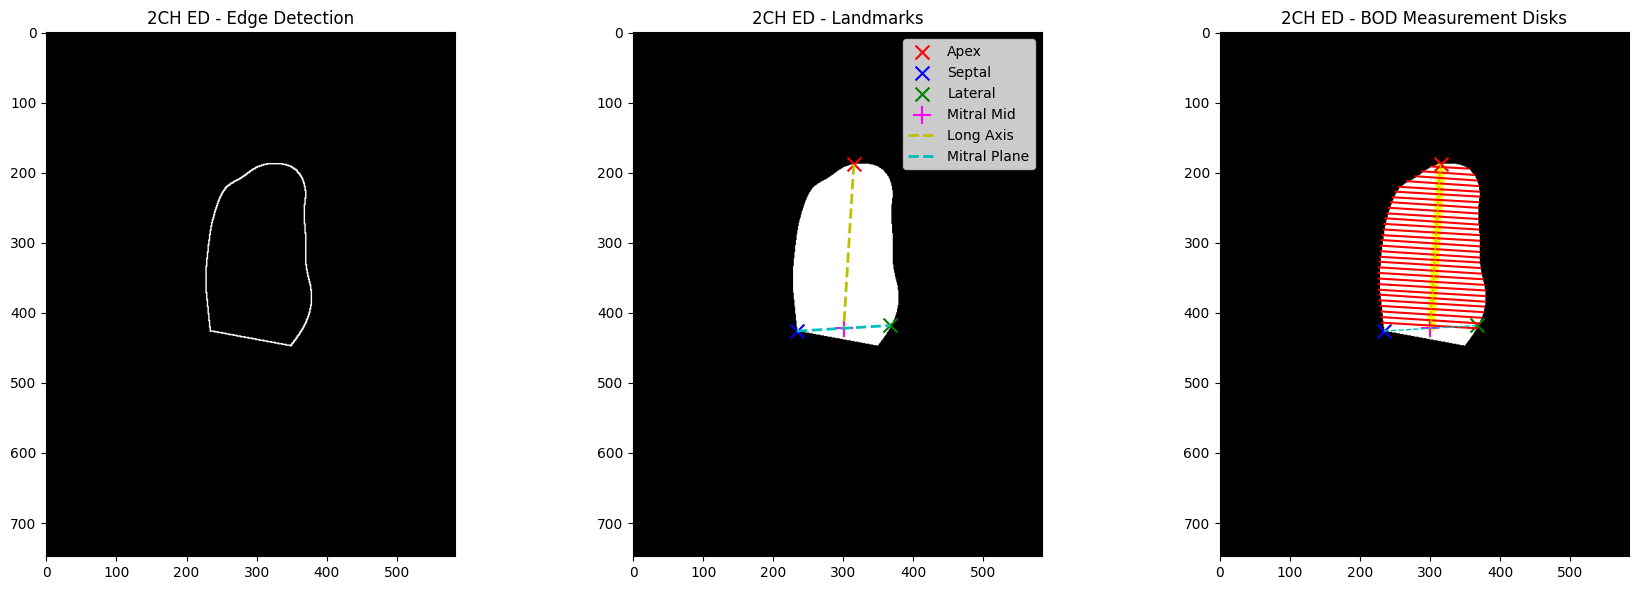


Processing 2CH ES...
View type: 2CH
Apex: (311, 203)
Septal: (246, 397)
Lateral: (331, 404)
Mitral Mid: (288.5, 400.5)


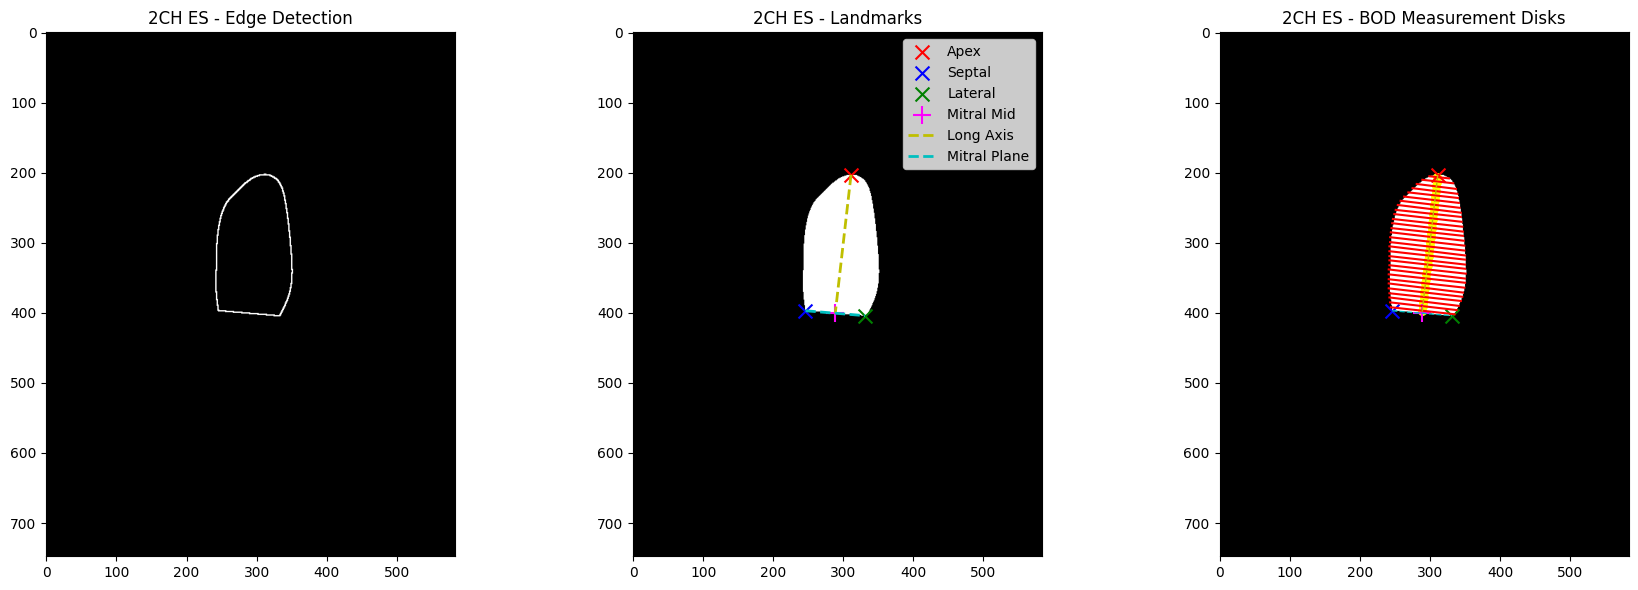


Processing 4CH ED...
View type: 2CH
Apex: (280, 188)
Septal: (320, 450)
Lateral: (199, 466)
Mitral Mid: (259.5, 458.0)


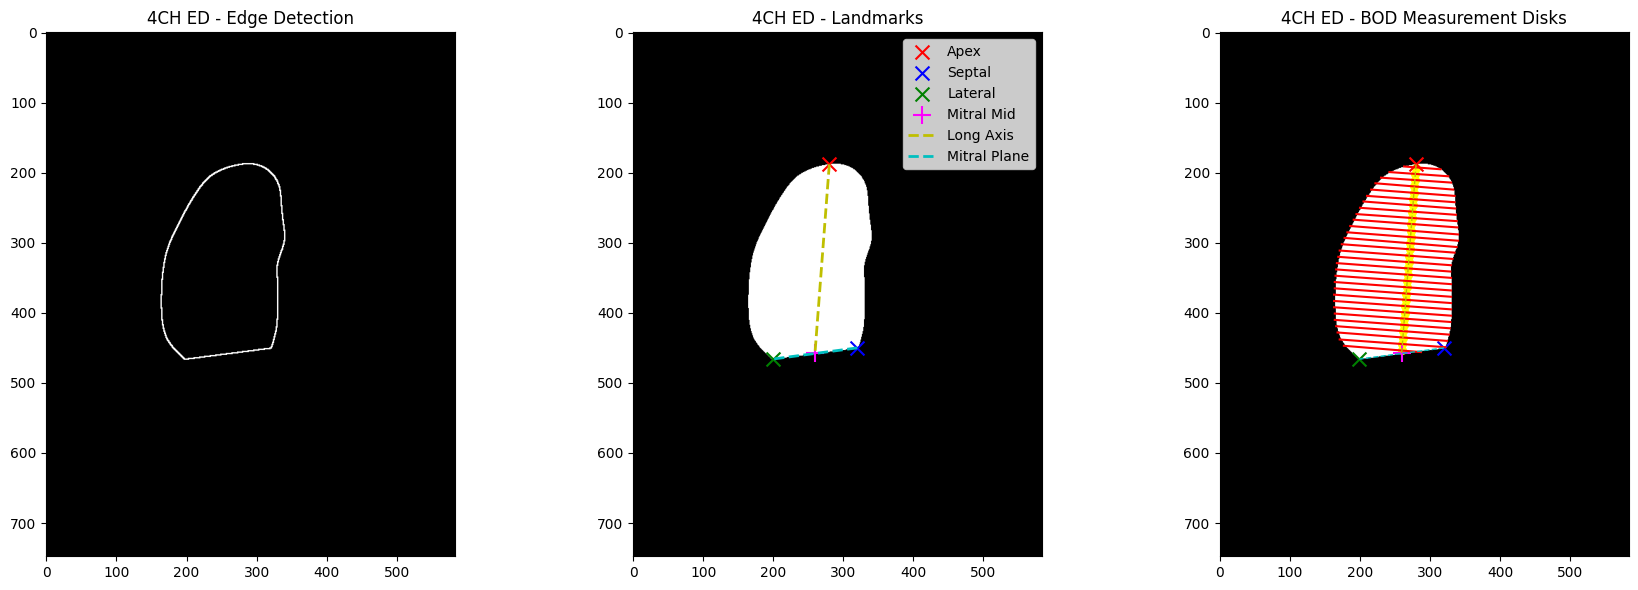


Processing 4CH ES...
View type: 2CH
Apex: (306, 194)
Septal: (230, 421)
Lateral: (348, 423)
Mitral Mid: (289.0, 422.0)


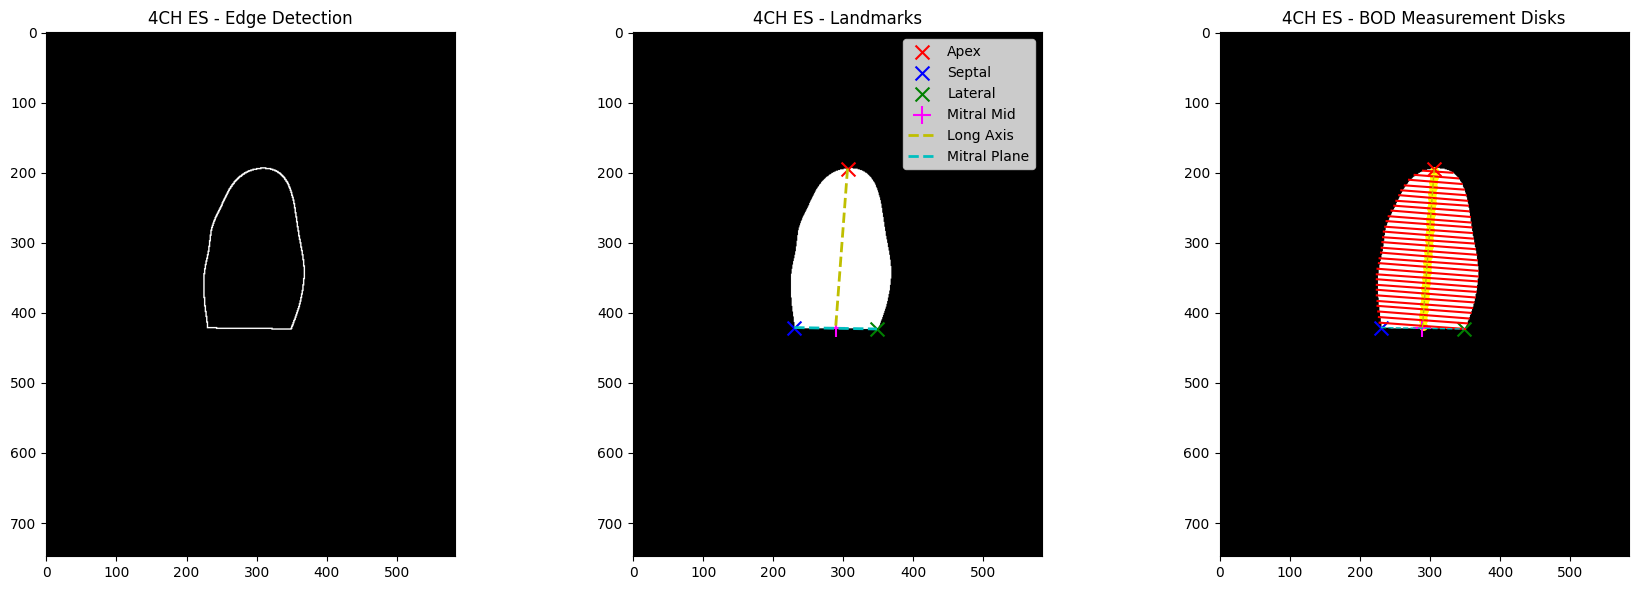


EF Calculation Successful:
EDV: 113608.08 ml
ESV: 57375.20 ml
EF: 49.50%


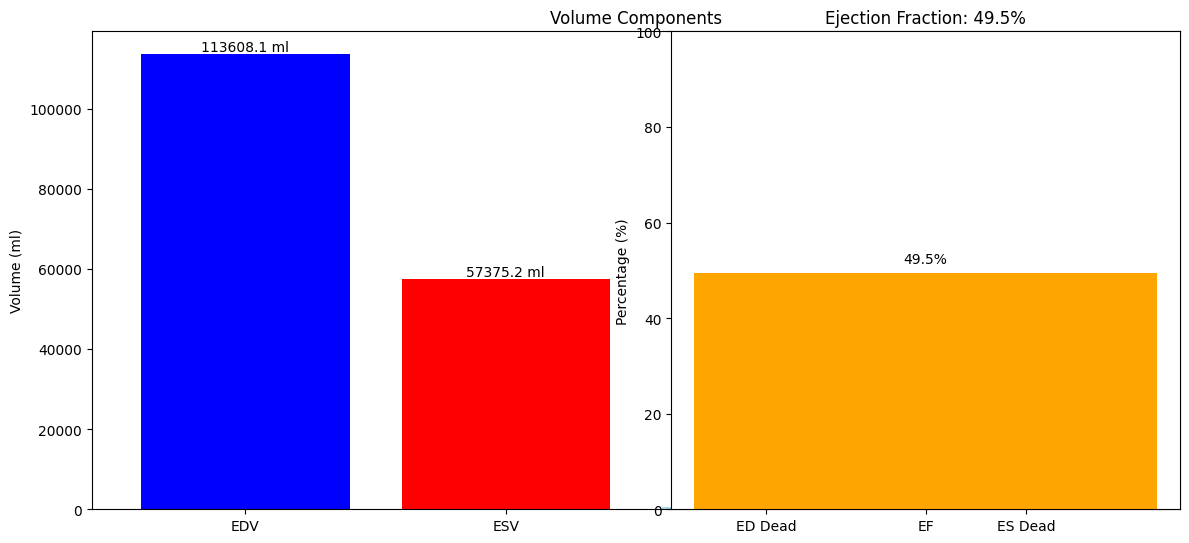

In [1]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import math
import gzip
import shutil
import tempfile
from skimage.filters import sobel
from skimage.feature import canny

def handle_compressed_file(filepath):
    """Handle both .nii.gz and .niigz files"""
    if filepath.endswith('.niigz'):
        with tempfile.NamedTemporaryFile(suffix='.nii.gz', delete=False) as tmp_file:
            with gzip.open(filepath, 'rb') as f_in:
                shutil.copyfileobj(f_in, tmp_file)
            return tmp_file.name
    return filepath

def rotate_image_clockwise(image, angle=90):
    """Rotate image clockwise with better boundary handling"""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def enhanced_edge_detection(seg_binary):
    """Improved edge detection using multiple methods"""
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    edges_canny = canny(seg_binary/255.0, sigma=1.5)
    edges_sobel = sobel(seg_binary/255.0) > 0.1
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    gradient = cv2.morphologyEx(seg_binary, cv2.MORPH_GRADIENT, kernel)
    combined_edges = (edges_canny | edges_sobel) | (gradient > 0)
    combined_edges = combined_edges.astype(np.uint8) * 255
    kernel = np.ones((3,3), np.uint8)
    combined_edges = cv2.morphologyEx(combined_edges, cv2.MORPH_CLOSE, kernel)
    return combined_edges

def detect_landmarks(seg_binary, delta_y_fraction=0.15, y_tolerance=20, curvature_threshold=0.2, min_x_separation=0.2):
    """Enhanced landmark detection combining view-specific and flexible logic."""
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    contours, _ = cv2.findContours(seg_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise ValueError("No LV contour found")
    contour = max(contours, key=cv2.contourArea).squeeze()
    x = contour[:, 0].astype(float)
    y = contour[:, 1].astype(float)
    img_width = seg_binary.shape[1]
    x_smooth = gaussian_filter1d(x, sigma=5, mode='wrap')
    y_smooth = gaussian_filter1d(y, sigma=5, mode='wrap')
    dx = np.gradient(x_smooth)
    dy = np.gradient(y_smooth)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2 + 1e-10)**1.5
    curvature = (curvature - np.min(curvature)) / (np.max(curvature) - np.min(curvature) + 1e-10)
    apex_idx = np.argmin(y)
    apex_point = (int(x[apex_idx]), int(y[apex_idx]))
    mean_x = np.mean(x)
    view_type = '2CH' if abs(np.median(x) - mean_x) < 0.3*img_width else '4CH'
    max_y = max(y)
    min_y = min(y)
    basal_threshold = max_y - delta_y_fraction * (max_y - min_y)
    peaks, _ = find_peaks(curvature, prominence=0.0005)
    basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
    if len(basal_peaks) < 2:
        basal_threshold = max_y - 2 * delta_y_fraction * (max_y - min_y)
        basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
    basal_points = [i for i in range(len(y)) if y[i] >= basal_threshold]
    if view_type == '4CH':
        if basal_points:
            sorted_by_y = sorted(basal_points, key=lambda i: -y[i])
            lateral_idx = sorted_by_y[0]
            mean_x = np.mean(x[basal_points])
            septal_candidates = [i for i in basal_points 
                                 if (x[i] - mean_x) * (x[lateral_idx] - mean_x) < 0
                                 and curvature[i] >= curvature_threshold]
            if septal_candidates:
                septal_idx = max(septal_candidates, key=lambda i: curvature[i])
            else:
                other_points = [i for i in basal_points if i != lateral_idx]
                if other_points:
                    septal_idx = max(other_points, key=lambda i: curvature[i])
                else:
                    septal_idx = lateral_idx
        else:
            raise ValueError("No basal points found for 4CH")
    else:
        if len(basal_peaks) >= 2:
            basal_peaks_sorted = sorted(basal_peaks, key=lambda i: curvature[i], reverse=True)
            septal_idx = basal_peaks_sorted[0]
            septal_side = "right" if x[septal_idx] > mean_x else "left"
            lateral_candidates = [i for i in basal_peaks_sorted[1:] 
                                  if ((x[i] > mean_x and septal_side == "left") or 
                                      (x[i] < mean_x and septal_side == "right")) 
                                  and curvature[i] >= curvature_threshold / 2]
            if lateral_candidates:
                scores = []
                for i in lateral_candidates:
                    curvature_score = curvature[i] * 0.6
                    y_alignment_score = (1 - min(1, abs(y[i] - y[septal_idx]) / y_tolerance)) * 0.4
                    scores.append(curvature_score + y_alignment_score)
                lateral_idx = lateral_candidates[np.argmax(scores)]
            else:
                lateral_idx = basal_peaks_sorted[1]
            min_x_dist = min_x_separation * img_width
            if abs(x[septal_idx] - x[lateral_idx]) < min_x_dist:
                outward_dir = 1 if x[lateral_idx] > mean_x else -1
                for i in basal_peaks_sorted[2:]:
                    if abs(x[i] - x[septal_idx]) > min_x_dist and \
                       ((x[i] > mean_x and outward_dir > 0) or (x[i] < mean_x and outward_dir < 0)):
                        lateral_idx = i
                        break
            if abs(x[septal_idx] - x[lateral_idx]) < min_x_dist:
                print(f"Warning: Points still close after fallback. Distance: {abs(x[septal_idx] - x[lateral_idx]):.1f} px")
        else:
            if basal_points:
                left_idx = basal_points[np.argmin(x[basal_points])]
                right_idx = basal_points[np.argmax(x[basal_points])]
                if curvature[left_idx] > curvature[right_idx]:
                    septal_idx = left_idx
                    lateral_idx = right_idx
                else:
                    septal_idx = right_idx
                    lateral_idx = left_idx
            else:
                raise ValueError("No basal points found for 2CH")
    septal_point = (int(x[septal_idx]), int(y[septal_idx]))
    lateral_point = (int(x[lateral_idx]), int(y[lateral_idx]))
    mitral_mid = ((septal_point[0] + lateral_point[0]) / 2, (septal_point[1] + lateral_point[1]) / 2)
    print(f"View type: {view_type}")
    print(f"Apex: {apex_point}")
    print(f"Septal: {septal_point}")
    print(f"Lateral: {lateral_point}")
    print(f"Mitral Mid: {mitral_mid}")
    return apex_point, septal_point, lateral_point, mitral_mid, curvature, contour

def compute_bod_diameters(seg_binary, apex, septal, lateral, mitral_mid, pixel_spacing=(0.1, 0.1), nr_disks=30):
    edges = enhanced_edge_detection(seg_binary)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return 0.0, [], [], 0.0, None, None
    max_contour = max(contours, key=cv2.contourArea)
    filled_mask = np.zeros_like(seg_binary, dtype=np.uint8)
    cv2.drawContours(filled_mask, [max_contour], -1, 1, thickness=cv2.FILLED)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    boundary = cv2.morphologyEx(filled_mask, cv2.MORPH_GRADIENT, kernel)
    dx_long = apex[0] - mitral_mid[0]
    dy_long = apex[1] - mitral_mid[1]
    L_cm = np.sqrt((dx_long * pixel_spacing[0])**2 + (dy_long * pixel_spacing[1])**2)
    if L_cm == 0:
        return L_cm, [], [], 0.0, None, None
    long_norm = np.sqrt(dx_long**2 + dy_long**2) + 1e-10
    perp_vector = np.array([dy_long / long_norm, -dx_long / long_norm])
    dx_mitral = lateral[0] - septal[0]
    dy_mitral = lateral[1] - septal[1]
    mit_plane_length_cm = np.sqrt((dx_mitral * pixel_spacing[0])**2 + (dy_mitral * pixel_spacing[1])**2)
    if mit_plane_length_cm == 0:
        return L_cm, [], [], 0.0, None, None
    max_dist = max(seg_binary.shape) // 2
    diameters_cm = []
    disk_info = []
    valid_disks = []
    for i in range(nr_disks):
        t = (i + 0.5) / nr_disks
        center_x = mitral_mid[0] + t * dx_long
        center_y = mitral_mid[1] + t * dy_long
        point1 = None
        point2 = None
        for direction in [-1, 1]:
            for dist in range(1, max_dist):
                px = int(round(center_x + direction * dist * perp_vector[0]))
                py = int(round(center_y + direction * dist * perp_vector[1]))
                if not (0 <= px < seg_binary.shape[1] and 0 <= py < seg_binary.shape[0]):
                    break
                if boundary[py, px]:
                    if direction == -1:
                        point1 = (px, py)
                    else:
                        point2 = (px, py)
                    break
        if point1 and point2:
            dx_px = point2[0] - point1[0]
            dy_px = point2[1] - point1[1]
            diameter_cm = np.sqrt((dx_px * pixel_spacing[0])**2 + (dy_px * pixel_spacing[1])**2)
            diameters_cm.append(diameter_cm)
            disk_info.append({
                'center': (center_x, center_y),
                'point1': point1,
                'point2': point2,
                'diameter_cm': diameter_cm
            })
            valid_disks.append(i)
        else:
            diameters_cm.append(0.0)
            disk_info.append({
                'center': (center_x, center_y),
                'point1': None,
                'point2': None,
                'diameter_cm': 0.0
            })
    dead_area_cm2 = 0.0
    dead_space_mask = None
    if len(valid_disks) >= 2:
        polygon_points = []
        for i in valid_disks:
            if disk_info[i]['point1']:
                polygon_points.append(disk_info[i]['point1'])
        for i in reversed(valid_disks):
            if disk_info[i]['point2']:
                polygon_points.append(disk_info[i]['point2'])
        if len(polygon_points) > 2:
            disk_area_mask = np.zeros_like(filled_mask, dtype=np.uint8)
            cv2.fillPoly(disk_area_mask, [np.array(polygon_points, dtype=np.int32)], 1)
            dead_space_mask = filled_mask - disk_area_mask
            dead_space_mask = np.clip(dead_space_mask, 0, 1)
            dead_area_px = np.sum(dead_space_mask)
            dead_area_cm2 = dead_area_px * pixel_spacing[0] * pixel_spacing[1]
    return L_cm, diameters_cm, disk_info, dead_area_cm2, dead_space_mask, filled_mask

def compute_biplane_volume(L4_cm, L2_cm, diameters4_cm, diameters2_cm, dead_area4_cm2, dead_area2_cm2, nr_disks=30, theta_deg=90):
    L_avg_cm = (L4_cm + L2_cm) / 2
    h_cm = L_avg_cm / nr_disks if nr_disks > 0 else 0
    sin_theta = np.sin(np.deg2rad(theta_deg))
    if sin_theta == 0:
        sin_theta = 1.0
    total_volume = 0.0
    disk_volumes = []
    for i in range(nr_disks):
        a_i = diameters4_cm[i] if i < len(diameters4_cm) else 0
        b_i = diameters2_cm[i] if i < len(diameters2_cm) else 0
        if a_i < 0.1 or b_i < 0.1:
            disk_volume = 0
        else:
            disk_volume = (np.pi / 4) * a_i * b_i * h_cm / sin_theta
        total_volume += disk_volume
        disk_volumes.append(disk_volume)
    valid_disks_4ch = sum(1 for d in diameters4_cm if d > 0.1)
    valid_disks_2ch = sum(1 for d in diameters2_cm if d > 0.1)
    if valid_disks_4ch > 0 and valid_disks_2ch > 0:
        coverage_ratio = min(valid_disks_4ch, valid_disks_2ch) / nr_disks
        dead_volume = (dead_area4_cm2 * (valid_disks_4ch/nr_disks) + 
                       dead_area2_cm2 * (valid_disks_2ch/nr_disks)) / 2 * h_cm * coverage_ratio
    else:
        dead_volume = 0
    total_volume_with_dead = total_volume + dead_volume
    return total_volume_with_dead, disk_volumes, dead_volume

def visualize_processing(seg_data, landmarks, disk_info, view, phase, pixel_spacing):
    apex, septal, lateral, mitral_mid = landmarks
    plt.figure(figsize=(18, 6))
    edges = enhanced_edge_detection(seg_data)
    plt.subplot(131)
    plt.imshow(edges, cmap='gray')
    plt.title(f'{view} {phase} - Edge Detection')
    plt.subplot(132)
    plt.imshow(seg_data, cmap='gray')
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x', label='Apex')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x', label='Septal')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x', label='Lateral')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+', label='Mitral Mid')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=2, label='Long Axis')
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=2, label='Mitral Plane')
    plt.legend(loc='upper right')
    plt.title(f'{view} {phase} - Landmarks')
    plt.subplot(133)
    plt.imshow(seg_data, cmap='gray')
    for disk in disk_info:
        if disk['point1'] and disk['point2']:
            plt.plot([disk['point1'][0], disk['point2'][0]], 
                     [disk['point1'][1], disk['point2'][1]], 
                     'r-', linewidth=1.5)
            plt.scatter(disk['center'][0], disk['center'][1], c='yellow', s=30)
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=1)
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=1)
    plt.title(f'{view} {phase} - BOD Measurement Disks')
    plt.tight_layout()
    plt.show()

def process_patient(patient_dir, visualize=False):
    patient_id = os.path.basename(patient_dir)
    print(f"\nProcessing Patient: {patient_id}")
    volumes = {'2CH': {'ED': None, 'ES': None}, '4CH': {'ED': None, 'ES': None}}
    all_landmarks = {}
    all_disk_info = {}
    try:
        for file in os.listdir(patient_dir):
            if not (file.endswith('_gt.niigz') or file.endswith('_gt.nii.gz')):
                continue
            view = None
            phase = None
            if '4ch' in file.lower():
                view = '4CH'
            elif '2ch' in file.lower():
                view = '2CH'
            if 'ed' in file.lower():
                phase = 'ED'
            elif 'es' in file.lower():
                phase = 'ES'
            if not view or not phase:
                continue
            print(f"\nProcessing {view} {phase}...")
            filepath = os.path.join(patient_dir, file)
            temp_file = None
            try:
                if file.endswith('.niigz'):
                    temp_file = handle_compressed_file(filepath)
                    gt_img = nib.load(temp_file)
                else:
                    gt_img = nib.load(filepath)
                gt_data = gt_img.get_fdata()
                pixel_spacing = gt_img.header.get_zooms()[:2]
                mask = np.zeros_like(gt_data, dtype=np.uint8)
                mask[gt_data == 1] = 255
                rotated_mask = rotate_image_clockwise(mask)
                try:
                    apex, septal, lateral, mitral_mid, _, _ = detect_landmarks(rotated_mask)
                    L_cm, diameters_cm, disk_info, dead_area_cm2, dead_mask, filled_mask = compute_bod_diameters(
                        rotated_mask, apex, septal, lateral, mitral_mid, pixel_spacing
                    )
                    volumes[view][phase] = {
                        'L_cm': L_cm,
                        'diameters_cm': diameters_cm,
                        'dead_area_cm2': dead_area_cm2,
                        'status': 'success'
                    }
                    all_landmarks[(view, phase)] = (apex, septal, lateral, mitral_mid)
                    all_disk_info[(view, phase)] = disk_info
                    if visualize:
                        visualize_processing(rotated_mask, (apex, septal, lateral, mitral_mid), 
                                             disk_info, view, phase, pixel_spacing)
                except Exception as landmark_error:
                    print(f"Landmark detection failed for {view} {phase}: {str(landmark_error)}")
                    volumes[view][phase] = {
                        'status': f'landmark_error: {str(landmark_error)}'
                    }
            except Exception as file_error:
                print(f"Error processing file {file}: {str(file_error)}")
                if view and phase:
                    volumes[view][phase] = {
                        'status': f'file_error: {str(file_error)}'
                    }
            finally:
                if temp_file and os.path.exists(temp_file):
                    os.unlink(temp_file)
    except Exception as patient_error:
        print(f"Error processing patient {patient_id}: {str(patient_error)}")
        return None, None, None
    missing = []
    for view in ['2CH', '4CH']:
        for phase in ['ED', 'ES']:
            if not volumes[view][phase] or volumes[view][phase].get('status') != 'success':
                missing.append(f"{view} {phase}")
    if missing:
        print(f"\nIncomplete data for EF calculation. Missing: {', '.join(missing)}")
    else:
        try:
            ed_vol, ed_disk_volumes, ed_dead_volume = compute_biplane_volume(
                volumes['4CH']['ED']['L_cm'],
                volumes['2CH']['ED']['L_cm'],
                volumes['4CH']['ED']['diameters_cm'],
                volumes['2CH']['ED']['diameters_cm'],
                volumes['4CH']['ED']['dead_area_cm2'],
                volumes['2CH']['ED']['dead_area_cm2']
            )
            es_vol, es_disk_volumes, es_dead_volume = compute_biplane_volume(
                volumes['4CH']['ES']['L_cm'],
                volumes['2CH']['ES']['L_cm'],
                volumes['4CH']['ES']['diameters_cm'],
                volumes['2CH']['ES']['diameters_cm'],
                volumes['4CH']['ES']['dead_area_cm2'],
                volumes['2CH']['ES']['dead_area_cm2']
            )
            ef = ((ed_vol - es_vol) / ed_vol) * 100 if ed_vol > 0 else 0
            volumes['EDV'] = ed_vol
            volumes['ESV'] = es_vol
            volumes['EF'] = ef
            volumes['ED_disk_volumes'] = ed_disk_volumes
            volumes['ES_disk_volumes'] = es_disk_volumes
            volumes['ED_dead_volume'] = ed_dead_volume
            volumes['ES_dead_volume'] = es_dead_volume
            print(f"\nEF Calculation Successful:")
            print(f"EDV: {ed_vol:.2f} ml")
            print(f"ESV: {es_vol:.2f} ml")
            print(f"EF: {ef:.2f}%")
            if visualize:
                plt.figure(figsize=(12, 6))
                volumes_data = [ed_vol, es_vol, ed_dead_volume, es_dead_volume]
                labels = ['EDV', 'ESV', 'ED Dead', 'ES Dead']
                colors = ['blue', 'red', 'lightblue', 'pink']
                bars = plt.bar(labels, volumes_data, color=colors)
                plt.ylabel('Volume (ml)')
                plt.title('Volume Components')
                for bar in bars:
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height,
                             f'{height:.1f} ml', ha='center', va='bottom')
                plt.subplot(122)
                plt.bar(['EF'], [ef], color='green' if ef > 50 else 'orange' if ef > 30 else 'red')
                plt.ylim(0, 100)
                plt.ylabel('Percentage (%)')
                plt.title(f'Ejection Fraction: {ef:.1f}%')
                plt.text(0, ef + 2, f'{ef:.1f}%', ha='center')
                plt.tight_layout()
                plt.show()
        except Exception as vol_error:
            print(f"Volume calculation error: {str(vol_error)}")
    return volumes, all_landmarks, all_disk_info

if __name__ == "__main__":
    base_dir = r"E:\echo heart\Resources"
    patient_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    if not patient_dirs:
        print("No patient directories found")
    else:
        print("Available patients:")
        for i, patient in enumerate(patient_dirs):
            print(f"{i+1}. {patient}")
        choice = input("Enter patient number to process (or 'all' for all patients): ")
        if choice.lower() == 'all':
            for patient_dir in patient_dirs:
                full_path = os.path.join(base_dir, patient_dir)
                process_patient(full_path, visualize=True)
        elif choice.isdigit():
            idx = int(choice) - 1
            if 0 <= idx < len(patient_dirs):
                full_path = os.path.join(base_dir, patient_dirs[idx])
                process_patient(full_path, visualize=True)
            else:
                print("Invalid patient number")
        else:
            print("Invalid input")

Available patients:
1. patient0001
2. patient0002
3. patient0003
4. patient0004
5. patient0005
6. patient0006
7. patient0007
8. patient0008
9. patient0009
10. patient0010

Processing Patient: patient0002

Processing 2CH ED...
View type: 2CH
Apex: (315, 188)
Septal: (234, 426)
Lateral: (367, 418)
Mitral Mid: (300.5, 422.0)


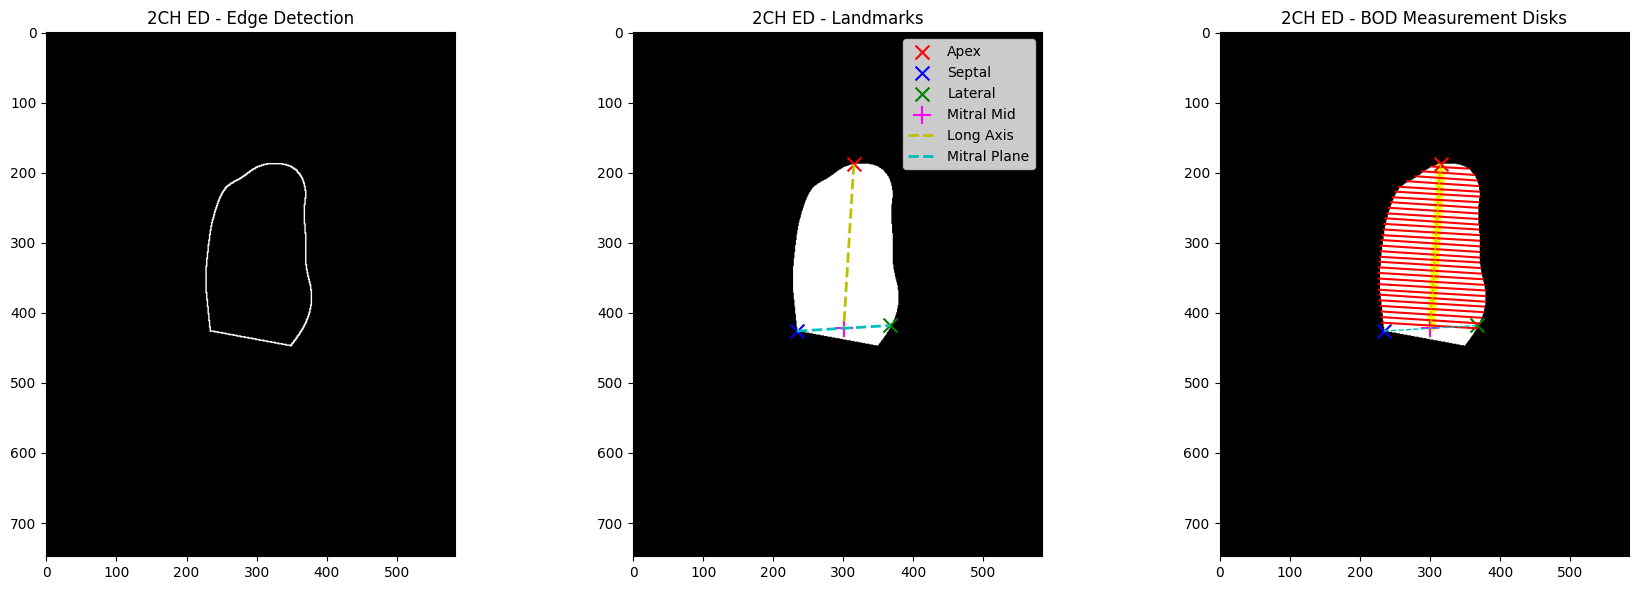


Processing 2CH ES...
View type: 2CH
Apex: (311, 203)
Septal: (246, 397)
Lateral: (331, 404)
Mitral Mid: (288.5, 400.5)


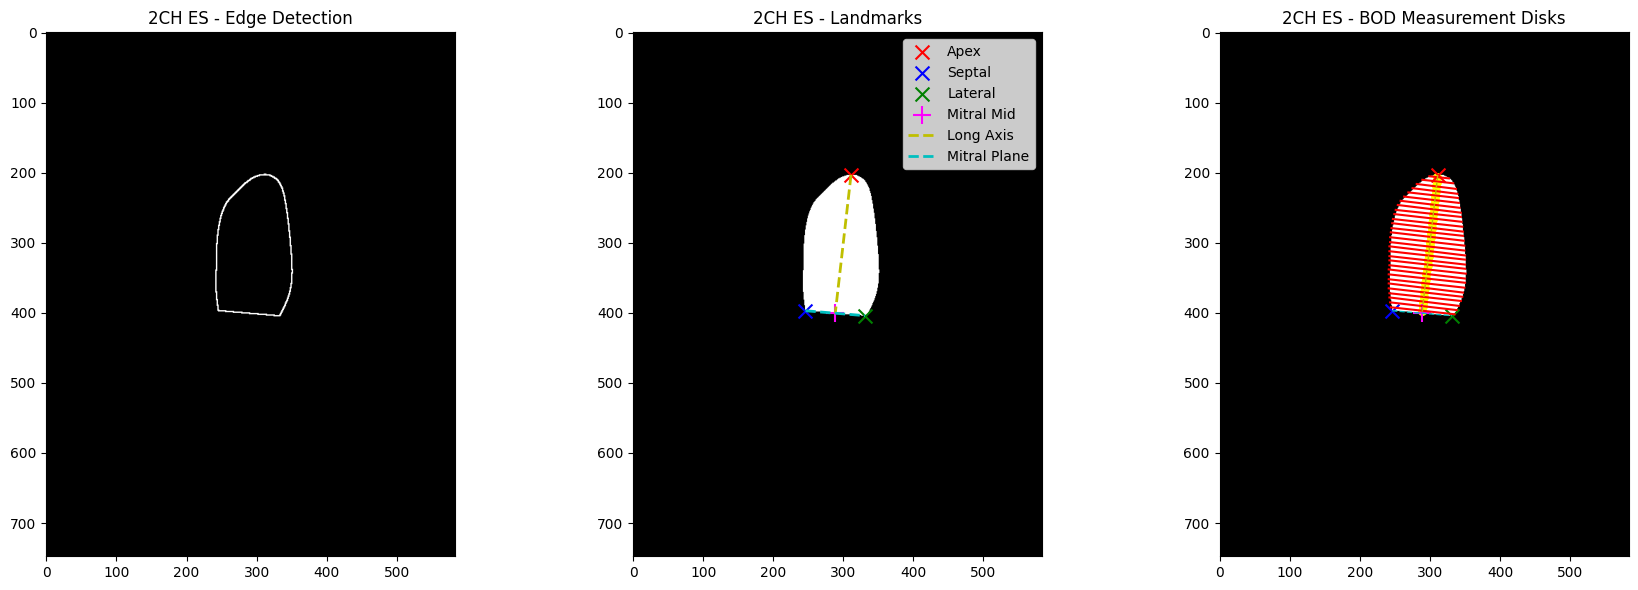


Processing 4CH ED...
View type: 2CH
Apex: (280, 188)
Septal: (320, 450)
Lateral: (199, 466)
Mitral Mid: (259.5, 458.0)


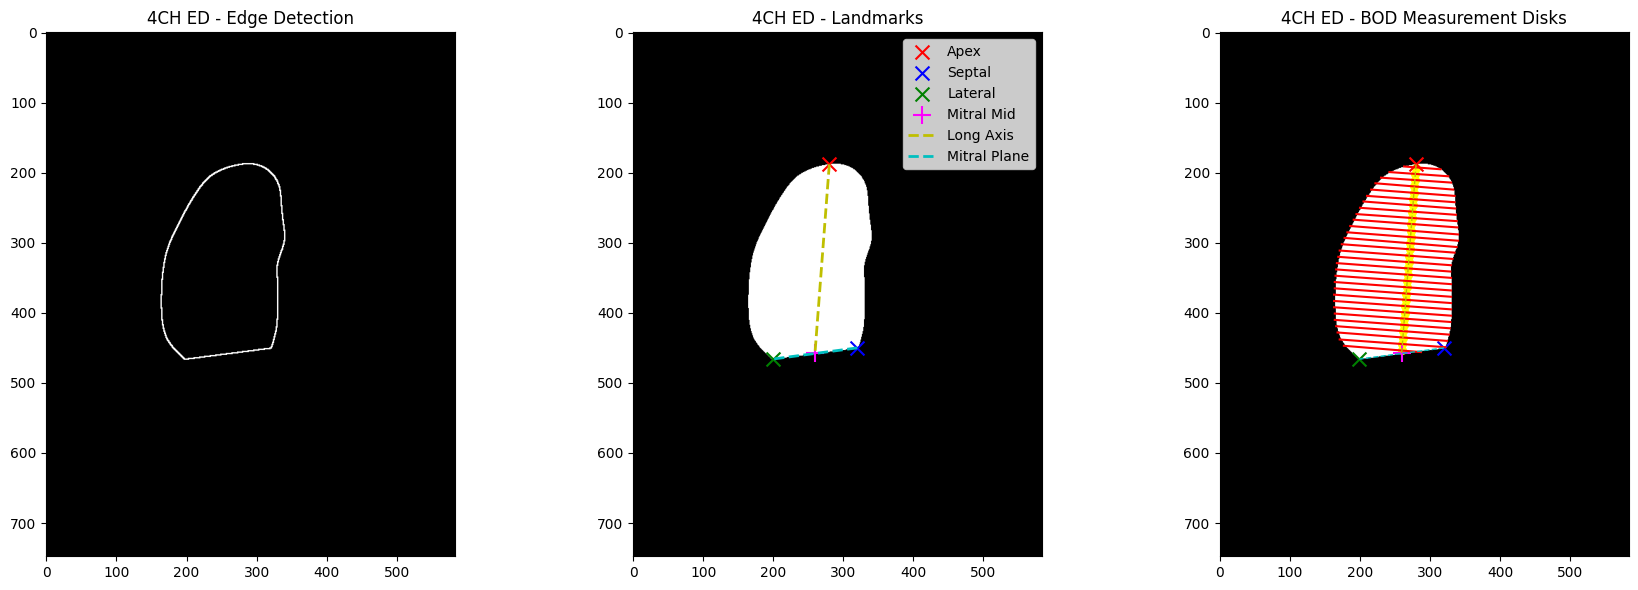


Processing 4CH ES...
View type: 2CH
Apex: (306, 194)
Septal: (230, 421)
Lateral: (348, 423)
Mitral Mid: (289.0, 422.0)


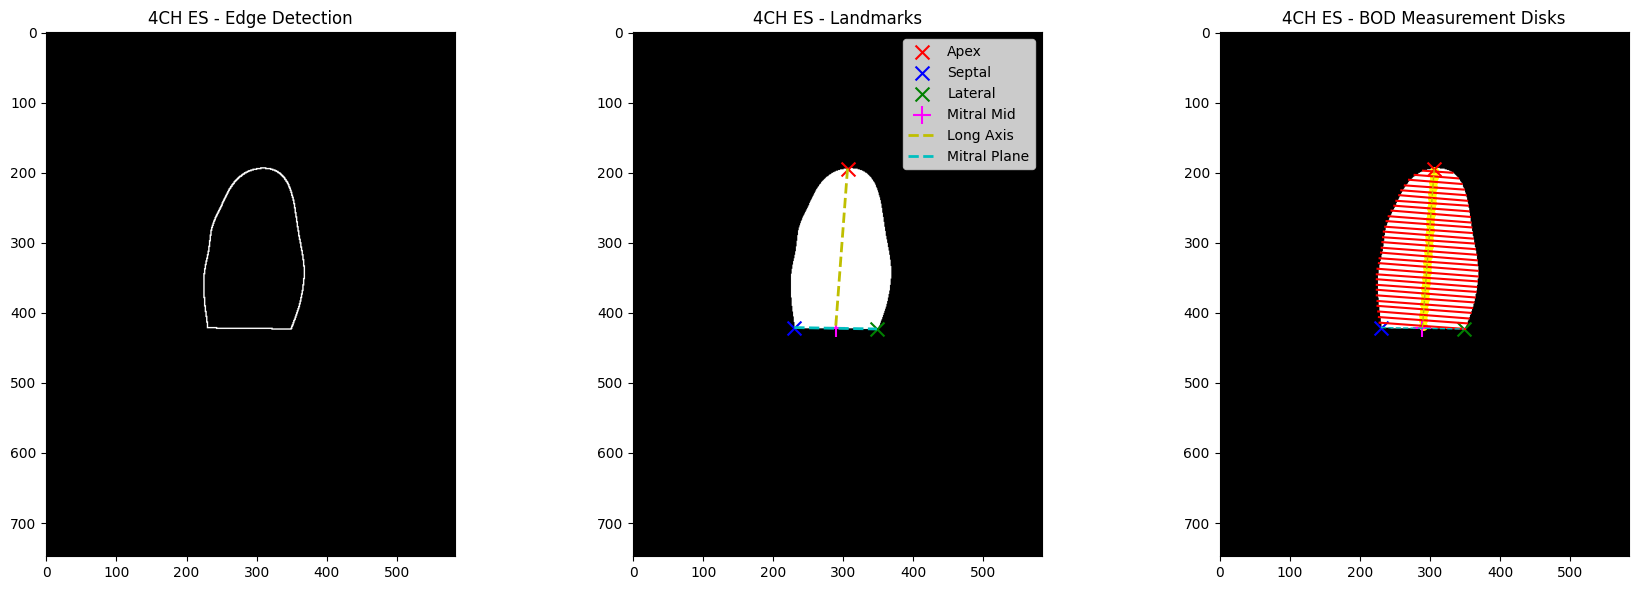


EF Calculation Successful:
EDV: 113085.03 ml
ESV: 57231.28 ml
EF: 49.39%


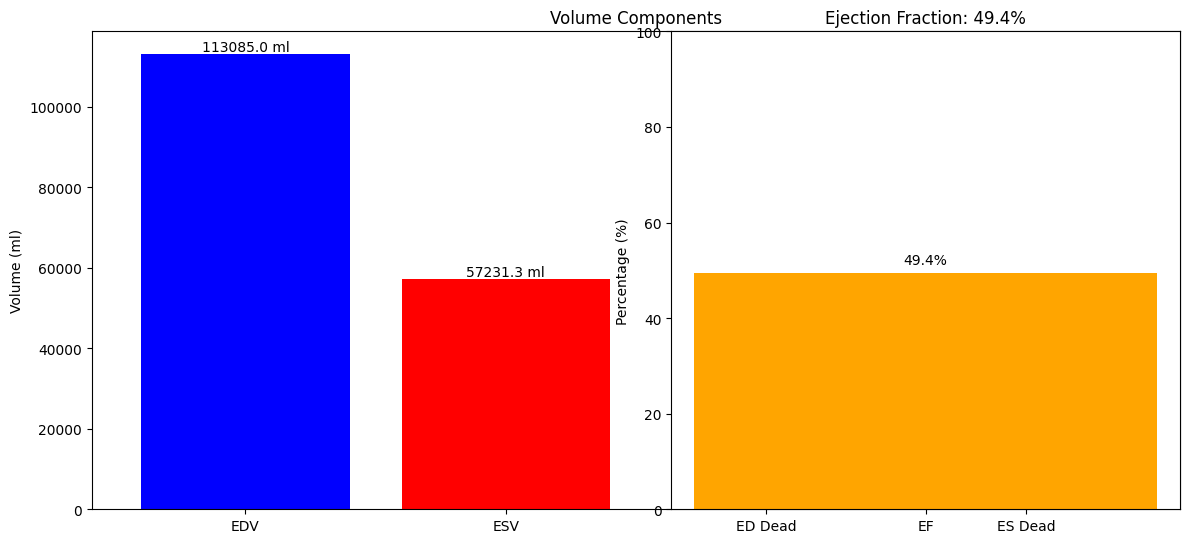

In [2]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import math
import gzip
import shutil
import tempfile
from skimage.filters import sobel
from skimage.feature import canny

def handle_compressed_file(filepath):
    """Handle both .nii.gz and .niigz files"""
    if filepath.endswith('.niigz'):
        with tempfile.NamedTemporaryFile(suffix='.nii.gz', delete=False) as tmp_file:
            with gzip.open(filepath, 'rb') as f_in:
                shutil.copyfileobj(f_in, tmp_file)
            return tmp_file.name
    return filepath

def rotate_image_clockwise(image, angle=90):
    """Rotate image clockwise with better boundary handling"""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def enhanced_edge_detection(seg_binary):
    """Improved edge detection using multiple methods"""
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    edges_canny = canny(seg_binary/255.0, sigma=1.5)
    edges_sobel = sobel(seg_binary/255.0) > 0.1
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    gradient = cv2.morphologyEx(seg_binary, cv2.MORPH_GRADIENT, kernel)
    combined_edges = (edges_canny | edges_sobel) | (gradient > 0)
    combined_edges = combined_edges.astype(np.uint8) * 255
    kernel = np.ones((3,3), np.uint8)
    combined_edges = cv2.morphologyEx(combined_edges, cv2.MORPH_CLOSE, kernel)
    return combined_edges

def detect_landmarks(seg_binary, delta_y_fraction=0.15, y_tolerance=20, curvature_threshold=0.2, min_x_separation=0.2):
    """Enhanced landmark detection combining view-specific and flexible logic."""
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    contours, _ = cv2.findContours(seg_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise ValueError("No LV contour found")
    contour = max(contours, key=cv2.contourArea).squeeze()
    x = contour[:, 0].astype(float)
    y = contour[:, 1].astype(float)
    img_width = seg_binary.shape[1]
    x_smooth = gaussian_filter1d(x, sigma=5, mode='wrap')
    y_smooth = gaussian_filter1d(y, sigma=5, mode='wrap')
    dx = np.gradient(x_smooth)
    dy = np.gradient(y_smooth)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2 + 1e-10)**1.5
    curvature = (curvature - np.min(curvature)) / (np.max(curvature) - np.min(curvature) + 1e-10)
    apex_idx = np.argmin(y)
    apex_point = (int(x[apex_idx]), int(y[apex_idx]))
    mean_x = np.mean(x)
    view_type = '2CH' if abs(np.median(x) - mean_x) < 0.3*img_width else '4CH'
    max_y = max(y)
    min_y = min(y)
    basal_threshold = max_y - delta_y_fraction * (max_y - min_y)
    peaks, _ = find_peaks(curvature, prominence=0.0005)
    basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
    if len(basal_peaks) < 2:
        basal_threshold = max_y - 2 * delta_y_fraction * (max_y - min_y)
        basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
    basal_points = [i for i in range(len(y)) if y[i] >= basal_threshold]
    if view_type == '4CH':
        if basal_points:
            sorted_by_y = sorted(basal_points, key=lambda i: -y[i])
            lateral_idx = sorted_by_y[0]
            mean_x = np.mean(x[basal_points])
            septal_candidates = [i for i in basal_points 
                                 if (x[i] - mean_x) * (x[lateral_idx] - mean_x) < 0
                                 and curvature[i] >= curvature_threshold]
            if septal_candidates:
                septal_idx = max(septal_candidates, key=lambda i: curvature[i])
            else:
                other_points = [i for i in basal_points if i != lateral_idx]
                if other_points:
                    septal_idx = max(other_points, key=lambda i: curvature[i])
                else:
                    septal_idx = lateral_idx
        else:
            raise ValueError("No basal points found for 4CH")
    else:
        if len(basal_peaks) >= 2:
            basal_peaks_sorted = sorted(basal_peaks, key=lambda i: curvature[i], reverse=True)
            septal_idx = basal_peaks_sorted[0]
            septal_side = "right" if x[septal_idx] > mean_x else "left"
            lateral_candidates = [i for i in basal_peaks_sorted[1:] 
                                  if ((x[i] > mean_x and septal_side == "left") or 
                                      (x[i] < mean_x and septal_side == "right")) 
                                  and curvature[i] >= curvature_threshold / 2]
            if lateral_candidates:
                scores = []
                for i in lateral_candidates:
                    curvature_score = curvature[i] * 0.6
                    y_alignment_score = (1 - min(1, abs(y[i] - y[septal_idx]) / y_tolerance)) * 0.4
                    scores.append(curvature_score + y_alignment_score)
                lateral_idx = lateral_candidates[np.argmax(scores)]
            else:
                lateral_idx = basal_peaks_sorted[1]
            min_x_dist = min_x_separation * img_width
            if abs(x[septal_idx] - x[lateral_idx]) < min_x_dist:
                outward_dir = 1 if x[lateral_idx] > mean_x else -1
                for i in basal_peaks_sorted[2:]:
                    if abs(x[i] - x[septal_idx]) > min_x_dist and \
                       ((x[i] > mean_x and outward_dir > 0) or (x[i] < mean_x and outward_dir < 0)):
                        lateral_idx = i
                        break
            if abs(x[septal_idx] - x[lateral_idx]) < min_x_dist:
                print(f"Warning: Points still close after fallback. Distance: {abs(x[septal_idx] - x[lateral_idx]):.1f} px")
        else:
            if basal_points:
                left_idx = basal_points[np.argmin(x[basal_points])]
                right_idx = basal_points[np.argmax(x[basal_points])]
                if curvature[left_idx] > curvature[right_idx]:
                    septal_idx = left_idx
                    lateral_idx = right_idx
                else:
                    septal_idx = right_idx
                    lateral_idx = left_idx
            else:
                raise ValueError("No basal points found for 2CH")
    septal_point = (int(x[septal_idx]), int(y[septal_idx]))
    lateral_point = (int(x[lateral_idx]), int(y[lateral_idx]))
    mitral_mid = ((septal_point[0] + lateral_point[0]) / 2, (septal_point[1] + lateral_point[1]) / 2)
    print(f"View type: {view_type}")
    print(f"Apex: {apex_point}")
    print(f"Septal: {septal_point}")
    print(f"Lateral: {lateral_point}")
    print(f"Mitral Mid: {mitral_mid}")
    return apex_point, septal_point, lateral_point, mitral_mid, curvature, contour

def compute_bod_diameters(seg_binary, apex, septal, lateral, mitral_mid, pixel_spacing=(0.1, 0.1), nr_disks=30):
    edges = enhanced_edge_detection(seg_binary)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return 0.0, [], [], 0.0, None, None
    max_contour = max(contours, key=cv2.contourArea)
    filled_mask = np.zeros_like(seg_binary, dtype=np.uint8)
    cv2.drawContours(filled_mask, [max_contour], -1, 1, thickness=cv2.FILLED)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    boundary = cv2.morphologyEx(filled_mask, cv2.MORPH_GRADIENT, kernel)
    dx_long = apex[0] - mitral_mid[0]
    dy_long = apex[1] - mitral_mid[1]
    L_cm = np.sqrt((dx_long * pixel_spacing[0])**2 + (dy_long * pixel_spacing[1])**2)
    if L_cm == 0:
        return L_cm, [], [], 0.0, None, None
    long_norm = np.sqrt(dx_long**2 + dy_long**2) + 1e-10
    perp_vector = np.array([dy_long / long_norm, -dx_long / long_norm])
    dx_mitral = lateral[0] - septal[0]
    dy_mitral = lateral[1] - septal[1]
    mit_plane_length_cm = np.sqrt((dx_mitral * pixel_spacing[0])**2 + (dy_mitral * pixel_spacing[1])**2)
    if mit_plane_length_cm == 0:
        return L_cm, [], [], 0.0, None, None
    max_dist = max(seg_binary.shape) // 2
    diameters_cm = []
    disk_info = []
    valid_disks = []
    for i in range(nr_disks):
        t = (i + 0.5) / nr_disks
        center_x = mitral_mid[0] + t * dx_long
        center_y = mitral_mid[1] + t * dy_long
        point1 = None
        point2 = None
        for direction in [-1, 1]:
            for dist in range(1, max_dist):
                px = int(round(center_x + direction * dist * perp_vector[0]))
                py = int(round(center_y + direction * dist * perp_vector[1]))
                if not (0 <= px < seg_binary.shape[1] and 0 <= py < seg_binary.shape[0]):
                    break
                if boundary[py, px]:
                    if direction == -1:
                        point1 = (px, py)
                    else:
                        point2 = (px, py)
                    break
        if point1 and point2:
            dx_px = point2[0] - point1[0]
            dy_px = point2[1] - point1[1]
            diameter_cm = np.sqrt((dx_px * pixel_spacing[0])**2 + (dy_px * pixel_spacing[1])**2)
            diameters_cm.append(diameter_cm)
            disk_info.append({
                'center': (center_x, center_y),
                'point1': point1,
                'point2': point2,
                'diameter_cm': diameter_cm
            })
            valid_disks.append(i)
        else:
            diameters_cm.append(0.0)
            disk_info.append({
                'center': (center_x, center_y),
                'point1': None,
                'point2': None,
                'diameter_cm': 0.0
            })
    dead_area_cm2 = 0.0
    dead_space_mask = None
    return L_cm, diameters_cm, disk_info, dead_area_cm2, dead_space_mask, filled_mask

def compute_biplane_volume(L4_cm, L2_cm, diameters4_cm, diameters2_cm, dead_area4_cm2, dead_area2_cm2, nr_disks=30, theta_deg=90):
    L_avg_cm = (L4_cm + L2_cm) / 2
    h_cm = L_avg_cm / nr_disks if nr_disks > 0 else 0
    sin_theta = np.sin(np.deg2rad(theta_deg))
    if sin_theta == 0:
        sin_theta = 1.0
    total_volume = 0.0
    disk_volumes = []
    for i in range(nr_disks):
        a_i = diameters4_cm[i] if i < len(diameters4_cm) else 0
        b_i = diameters2_cm[i] if i < len(diameters2_cm) else 0
        if a_i < 0.1 or b_i < 0.1:
            disk_volume = 0
        else:
            disk_volume = (np.pi / 4) * a_i * b_i * h_cm / sin_theta
        total_volume += disk_volume
        disk_volumes.append(disk_volume)
    dead_volume = 0
    total_volume_with_dead = total_volume + dead_volume
    return total_volume_with_dead, disk_volumes, dead_volume

def visualize_processing(seg_data, landmarks, disk_info, view, phase, pixel_spacing):
    apex, septal, lateral, mitral_mid = landmarks
    plt.figure(figsize=(18, 6))
    edges = enhanced_edge_detection(seg_data)
    plt.subplot(131)
    plt.imshow(edges, cmap='gray')
    plt.title(f'{view} {phase} - Edge Detection')
    plt.subplot(132)
    plt.imshow(seg_data, cmap='gray')
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x', label='Apex')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x', label='Septal')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x', label='Lateral')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+', label='Mitral Mid')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=2, label='Long Axis')
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=2, label='Mitral Plane')
    plt.legend(loc='upper right')
    plt.title(f'{view} {phase} - Landmarks')
    plt.subplot(133)
    plt.imshow(seg_data, cmap='gray')
    for disk in disk_info:
        if disk['point1'] and disk['point2']:
            plt.plot([disk['point1'][0], disk['point2'][0]], 
                     [disk['point1'][1], disk['point2'][1]], 
                     'r-', linewidth=1.5)
            plt.scatter(disk['center'][0], disk['center'][1], c='yellow', s=30)
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=1)
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=1)
    plt.title(f'{view} {phase} - BOD Measurement Disks')
    plt.tight_layout()
    plt.show()

def process_patient(patient_dir, visualize=False):
    patient_id = os.path.basename(patient_dir)
    print(f"\nProcessing Patient: {patient_id}")
    volumes = {'2CH': {'ED': None, 'ES': None}, '4CH': {'ED': None, 'ES': None}}
    all_landmarks = {}
    all_disk_info = {}
    try:
        for file in os.listdir(patient_dir):
            if not (file.endswith('_gt.niigz') or file.endswith('_gt.nii.gz')):
                continue
            view = None
            phase = None
            if '4ch' in file.lower():
                view = '4CH'
            elif '2ch' in file.lower():
                view = '2CH'
            if 'ed' in file.lower():
                phase = 'ED'
            elif 'es' in file.lower():
                phase = 'ES'
            if not view or not phase:
                continue
            print(f"\nProcessing {view} {phase}...")
            filepath = os.path.join(patient_dir, file)
            temp_file = None
            try:
                if file.endswith('.niigz'):
                    temp_file = handle_compressed_file(filepath)
                    gt_img = nib.load(temp_file)
                else:
                    gt_img = nib.load(filepath)
                gt_data = gt_img.get_fdata()
                pixel_spacing = gt_img.header.get_zooms()[:2]
                mask = np.zeros_like(gt_data, dtype=np.uint8)
                mask[gt_data == 1] = 255
                rotated_mask = rotate_image_clockwise(mask)
                try:
                    apex, septal, lateral, mitral_mid, _, _ = detect_landmarks(rotated_mask)
                    L_cm, diameters_cm, disk_info, dead_area_cm2, dead_mask, filled_mask = compute_bod_diameters(
                        rotated_mask, apex, septal, lateral, mitral_mid, pixel_spacing
                    )
                    volumes[view][phase] = {
                        'L_cm': L_cm,
                        'diameters_cm': diameters_cm,
                        'dead_area_cm2': dead_area_cm2,
                        'status': 'success'
                    }
                    all_landmarks[(view, phase)] = (apex, septal, lateral, mitral_mid)
                    all_disk_info[(view, phase)] = disk_info
                    if visualize:
                        visualize_processing(rotated_mask, (apex, septal, lateral, mitral_mid), 
                                             disk_info, view, phase, pixel_spacing)
                except Exception as landmark_error:
                    print(f"Landmark detection failed for {view} {phase}: {str(landmark_error)}")
                    volumes[view][phase] = {
                        'status': f'landmark_error: {str(landmark_error)}'
                    }
            except Exception as file_error:
                print(f"Error processing file {file}: {str(file_error)}")
                if view and phase:
                    volumes[view][phase] = {
                        'status': f'file_error: {str(file_error)}'
                    }
            finally:
                if temp_file and os.path.exists(temp_file):
                    os.unlink(temp_file)
    except Exception as patient_error:
        print(f"Error processing patient {patient_id}: {str(patient_error)}")
        return None, None, None
    missing = []
    for view in ['2CH', '4CH']:
        for phase in ['ED', 'ES']:
            if not volumes[view][phase] or volumes[view][phase].get('status') != 'success':
                missing.append(f"{view} {phase}")
    if missing:
        print(f"\nIncomplete data for EF calculation. Missing: {', '.join(missing)}")
    else:
        try:
            ed_vol, ed_disk_volumes, ed_dead_volume = compute_biplane_volume(
                volumes['4CH']['ED']['L_cm'],
                volumes['2CH']['ED']['L_cm'],
                volumes['4CH']['ED']['diameters_cm'],
                volumes['2CH']['ED']['diameters_cm'],
                volumes['4CH']['ED']['dead_area_cm2'],
                volumes['2CH']['ED']['dead_area_cm2']
            )
            es_vol, es_disk_volumes, es_dead_volume = compute_biplane_volume(
                volumes['4CH']['ES']['L_cm'],
                volumes['2CH']['ES']['L_cm'],
                volumes['4CH']['ES']['diameters_cm'],
                volumes['2CH']['ES']['diameters_cm'],
                volumes['4CH']['ES']['dead_area_cm2'],
                volumes['2CH']['ES']['dead_area_cm2']
            )
            ef = ((ed_vol - es_vol) / ed_vol) * 100 if ed_vol > 0 else 0
            volumes['EDV'] = ed_vol
            volumes['ESV'] = es_vol
            volumes['EF'] = ef
            volumes['ED_disk_volumes'] = ed_disk_volumes
            volumes['ES_disk_volumes'] = es_disk_volumes
            volumes['ED_dead_volume'] = ed_dead_volume
            volumes['ES_dead_volume'] = es_dead_volume
            print(f"\nEF Calculation Successful:")
            print(f"EDV: {ed_vol:.2f} ml")
            print(f"ESV: {es_vol:.2f} ml")
            print(f"EF: {ef:.2f}%")
            if visualize:
                plt.figure(figsize=(12, 6))
                volumes_data = [ed_vol, es_vol, ed_dead_volume, es_dead_volume]
                labels = ['EDV', 'ESV', 'ED Dead', 'ES Dead']
                colors = ['blue', 'red', 'lightblue', 'pink']
                bars = plt.bar(labels, volumes_data, color=colors)
                plt.ylabel('Volume (ml)')
                plt.title('Volume Components')
                for bar in bars:
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height,
                             f'{height:.1f} ml', ha='center', va='bottom')
                plt.subplot(122)
                plt.bar(['EF'], [ef], color='green' if ef > 50 else 'orange' if ef > 30 else 'red')
                plt.ylim(0, 100)
                plt.ylabel('Percentage (%)')
                plt.title(f'Ejection Fraction: {ef:.1f}%')
                plt.text(0, ef + 2, f'{ef:.1f}%', ha='center')
                plt.tight_layout()
                plt.show()
        except Exception as vol_error:
            print(f"Volume calculation error: {str(vol_error)}")
    return volumes, all_landmarks, all_disk_info

if __name__ == "__main__":
    base_dir = r"E:\echo heart\Resources"
    patient_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    if not patient_dirs:
        print("No patient directories found")
    else:
        print("Available patients:")
        for i, patient in enumerate(patient_dirs):
            print(f"{i+1}. {patient}")
        choice = input("Enter patient number to process (or 'all' for all patients): ")
        if choice.lower() == 'all':
            for patient_dir in patient_dirs:
                full_path = os.path.join(base_dir, patient_dir)
                process_patient(full_path, visualize=True)
        elif choice.isdigit():
            idx = int(choice) - 1
            if 0 <= idx < len(patient_dirs):
                full_path = os.path.join(base_dir, patient_dirs[idx])
                process_patient(full_path, visualize=True)
            else:
                print("Invalid patient number")
        else:
            print("Invalid input")

Available patients:
1. patient0001
2. patient0002
3. patient0003
4. patient0004
5. patient0005
6. patient0006
7. patient0007
8. patient0008
9. patient0009
10. patient0010

Processing Patient: patient0002

Processing 2CH ED...
View type: 2CH
Apex: (315, 188)
Septal: (234, 426)
Lateral: (367, 418)
Mitral Mid: (300.5, 422.0)


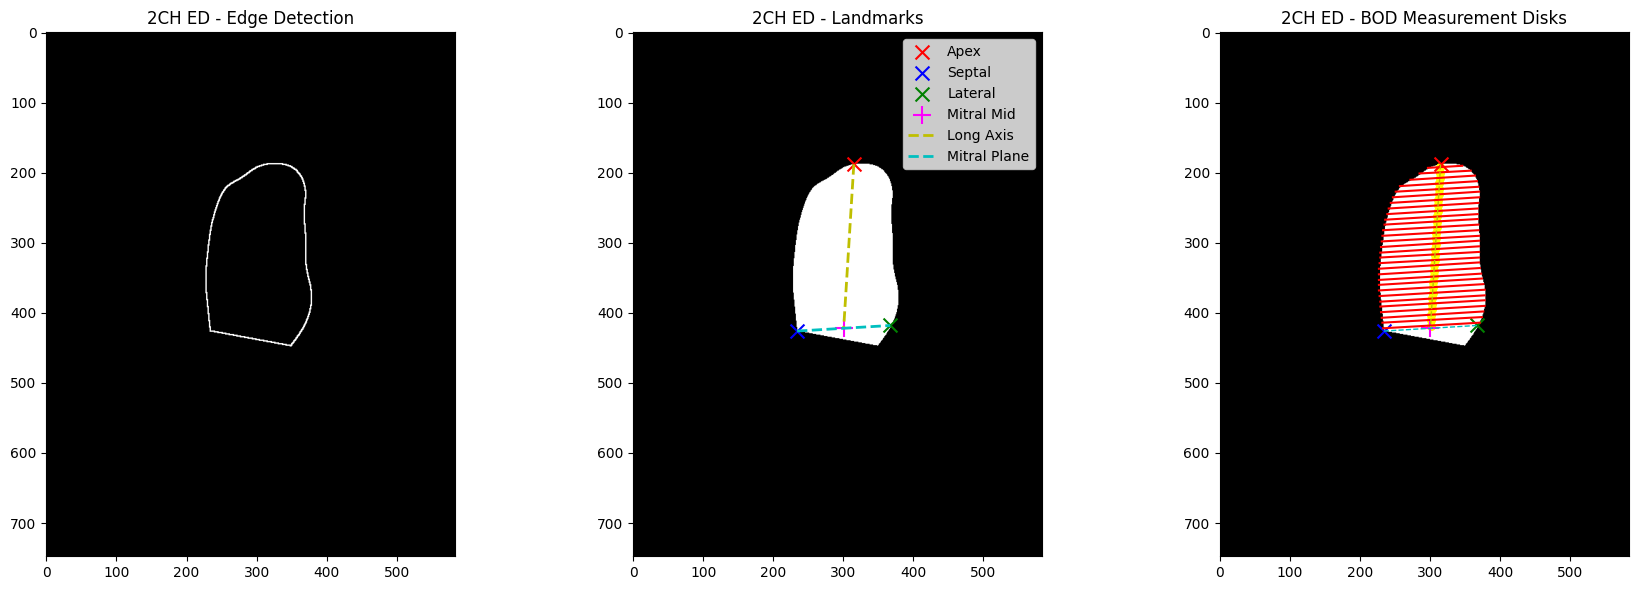


Processing 2CH ES...
View type: 2CH
Apex: (311, 203)
Septal: (246, 397)
Lateral: (331, 404)
Mitral Mid: (288.5, 400.5)


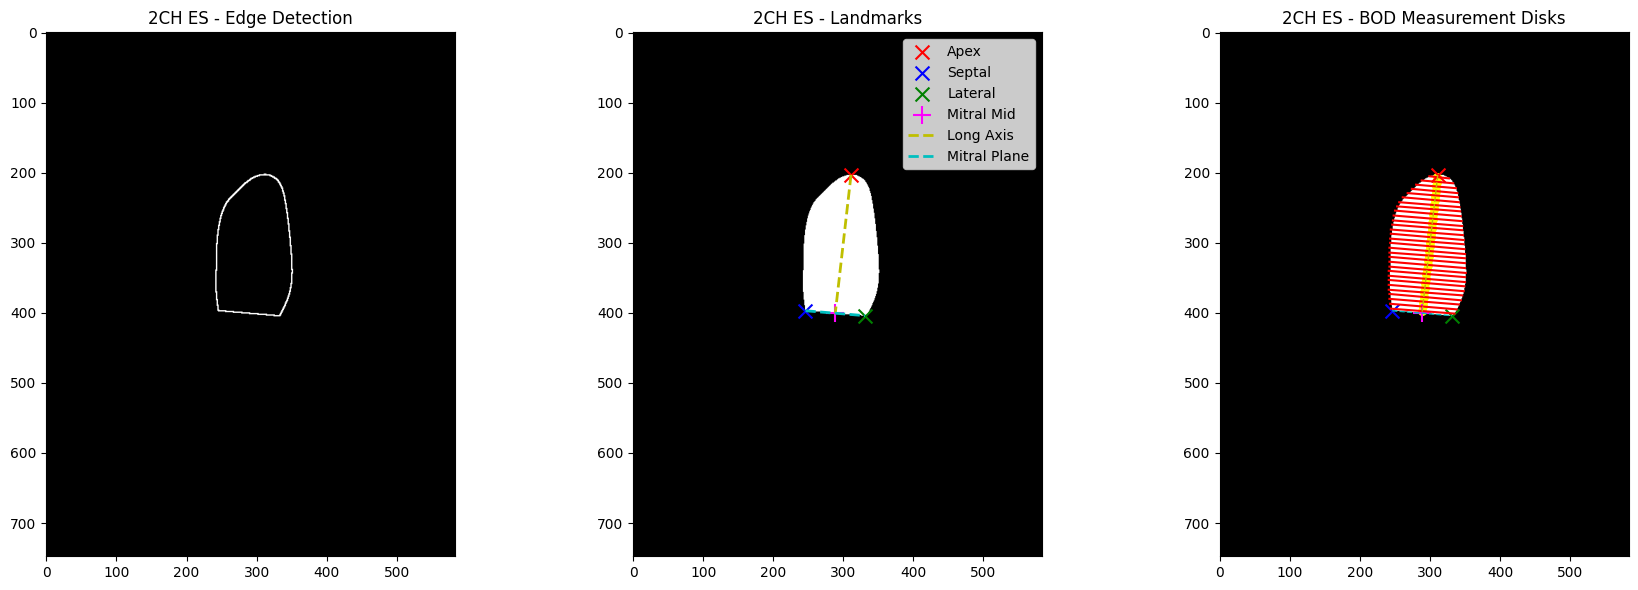


Processing 4CH ED...
View type: 2CH
Apex: (280, 188)
Septal: (320, 450)
Lateral: (199, 466)
Mitral Mid: (259.5, 458.0)


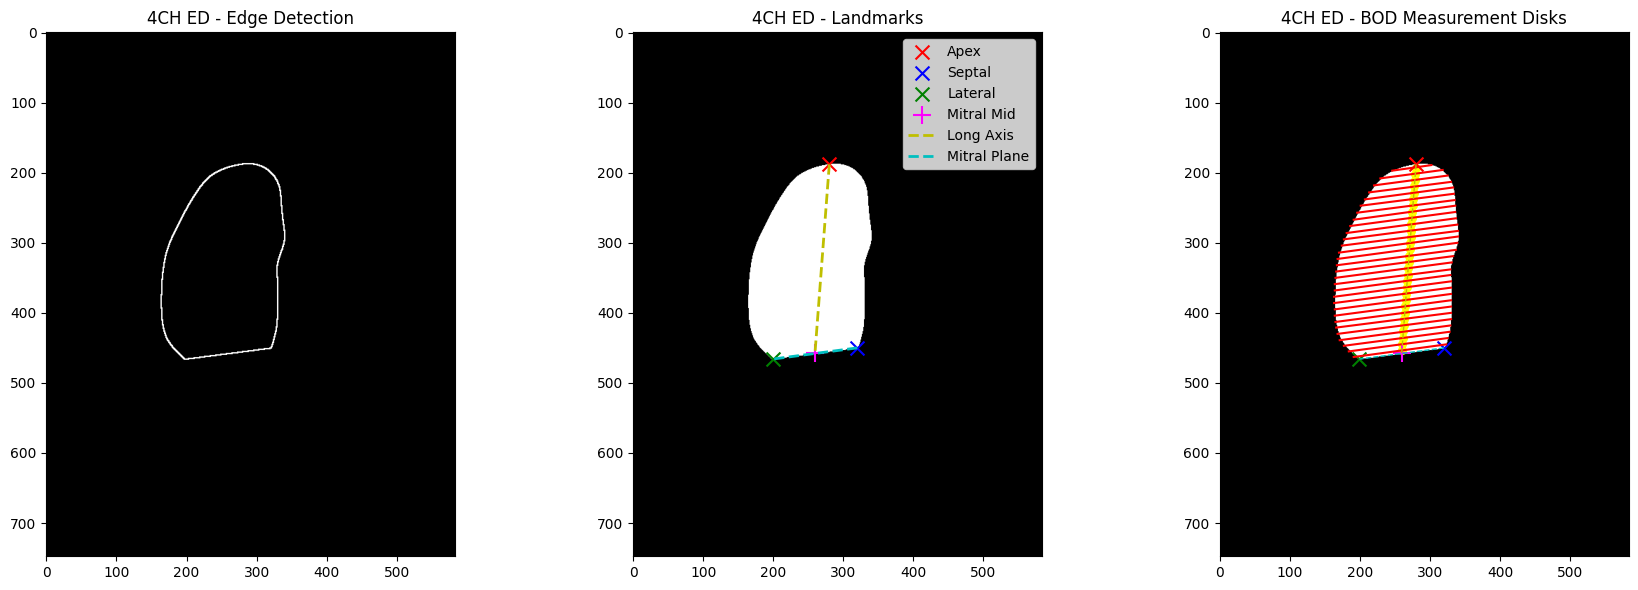


Processing 4CH ES...
View type: 2CH
Apex: (306, 194)
Septal: (230, 421)
Lateral: (348, 423)
Mitral Mid: (289.0, 422.0)


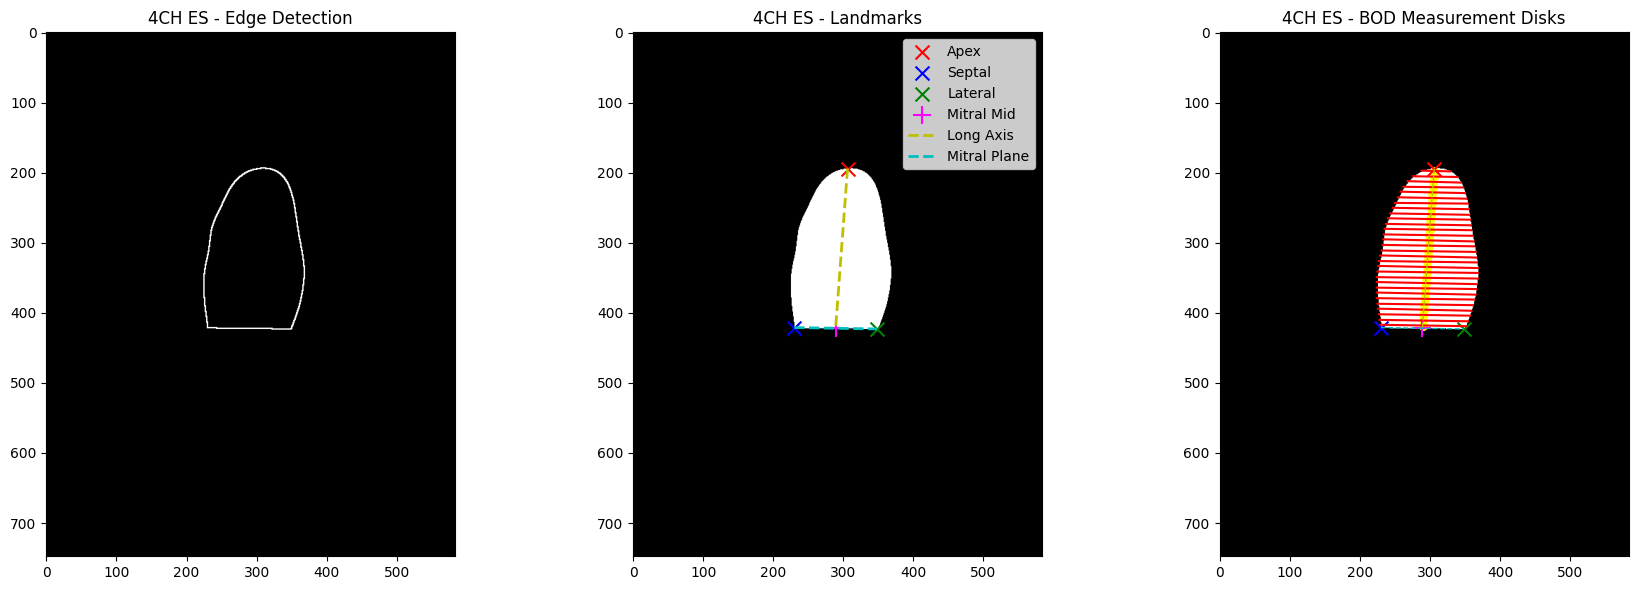

Volume calculation error: cannot access local variable 'sin_theta' where it is not associated with a value


In [3]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import math
import gzip
import shutil
import tempfile
from skimage.filters import sobel
from skimage.feature import canny

def handle_compressed_file(filepath):
    """Handle both .nii.gz and .niigz files"""
    if filepath.endswith('.niigz'):
        with tempfile.NamedTemporaryFile(suffix='.nii.gz', delete=False) as tmp_file:
            with gzip.open(filepath, 'rb') as f_in:
                shutil.copyfileobj(f_in, tmp_file)
            return tmp_file.name
    return filepath

def rotate_image_clockwise(image, angle=90):
    """Rotate image clockwise with better boundary handling"""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def enhanced_edge_detection(seg_binary):
    """Improved edge detection using multiple methods"""
    # Convert to binary
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    
    # Method 1: Canny edge detector with automatic thresholds
    edges_canny = canny(seg_binary/255.0, sigma=1.5)
    
    # Method 2: Sobel edge detection
    edges_sobel = sobel(seg_binary/255.0) > 0.1
    
    # Method 3: Morphological gradient
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    gradient = cv2.morphologyEx(seg_binary, cv2.MORPH_GRADIENT, kernel)
    
    # Combine methods
    combined_edges = (edges_canny | edges_sobel) | (gradient > 0)
    
    # Clean up edges
    combined_edges = combined_edges.astype(np.uint8) * 255
    kernel = np.ones((3,3), np.uint8)
    combined_edges = cv2.morphologyEx(combined_edges, cv2.MORPH_CLOSE, kernel)
    
    return combined_edges

def detect_landmarks(seg_binary, delta_y_fraction=0.15, y_tolerance=20, curvature_threshold=0.2, min_x_separation=0.2):
    """Enhanced landmark detection combining view-specific and flexible logic."""
    # Convert to binary and find contours
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    contours, _ = cv2.findContours(seg_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise ValueError("No LV contour found")
    
    # Use the largest contour
    contour = max(contours, key=cv2.contourArea).squeeze()
    x = contour[:, 0].astype(float)
    y = contour[:, 1].astype(float)
    img_width = seg_binary.shape[1]
    
    # Smooth contour
    x_smooth = gaussian_filter1d(x, sigma=5, mode='wrap')
    y_smooth = gaussian_filter1d(y, sigma=5, mode='wrap')
    
    # Compute curvature
    dx = np.gradient(x_smooth)
    dy = np.gradient(y_smooth)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2 + 1e-10)**1.5
    curvature = (curvature - np.min(curvature)) / (np.max(curvature) - np.min(curvature) + 1e-10)
    
    # Find apex: min y
    apex_idx = np.argmin(y)
    apex_point = (int(x[apex_idx]), int(y[apex_idx]))
    
    # Determine view type
    mean_x = np.mean(x)
    view_type = '2CH' if abs(np.median(x) - mean_x) < 0.3*img_width else '4CH'
    
    # Calculate basal threshold
    max_y = max(y)
    min_y = min(y)
    basal_threshold = max_y - delta_y_fraction * (max_y - min_y)
    
    # Find all peaks in curvature
    peaks, _ = find_peaks(curvature, prominence=0.0005)
    
    # Basal peaks
    basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
    
    # If not enough, expand threshold
    if len(basal_peaks) < 2:
        basal_threshold = max_y - 2 * delta_y_fraction * (max_y - min_y)
        basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
    
    # Get basal points (all points in basal region)
    basal_points = [i for i in range(len(y)) if y[i] >= basal_threshold]
    
    if view_type == '4CH':
        # 4CH specific logic: lateral as highest y, septal on opposite side with high curvature
        if basal_points:
            sorted_by_y = sorted(basal_points, key=lambda i: -y[i])
            lateral_idx = sorted_by_y[0]
            mean_x = np.mean(x[basal_points])
            septal_candidates = [i for i in basal_points 
                                 if (x[i] - mean_x) * (x[lateral_idx] - mean_x) < 0
                                 and curvature[i] >= curvature_threshold]
            
            if septal_candidates:
                septal_idx = max(septal_candidates, key=lambda i: curvature[i])
            else:
                other_points = [i for i in basal_points if i != lateral_idx]
                if other_points:
                    septal_idx = max(other_points, key=lambda i: curvature[i])
                else:
                    septal_idx = lateral_idx
        else:
            raise ValueError("No basal points found for 4CH")
    else:
        # 2CH logic: scoring-based selection to ensure separation and alignment
        if len(basal_peaks) >= 2:
            basal_peaks_sorted = sorted(basal_peaks, key=lambda i: curvature[i], reverse=True)
            septal_idx = basal_peaks_sorted[0]
            septal_side = "right" if x[septal_idx] > mean_x else "left"
            
            lateral_candidates = [i for i in basal_peaks_sorted[1:] 
                                  if ((x[i] > mean_x and septal_side == "left") or 
                                      (x[i] < mean_x and septal_side == "right")) 
                                  and curvature[i] >= curvature_threshold / 2]
            
            if lateral_candidates:
                scores = []
                for i in lateral_candidates:
                    curvature_score = curvature[i] * 0.6
                    y_alignment_score = (1 - min(1, abs(y[i] - y[septal_idx]) / y_tolerance)) * 0.4
                    scores.append(curvature_score + y_alignment_score)
                lateral_idx = lateral_candidates[np.argmax(scores)]
            else:
                lateral_idx = basal_peaks_sorted[1]
            
            # Ensure minimum x separation
            min_x_dist = min_x_separation * img_width
            if abs(x[septal_idx] - x[lateral_idx]) < min_x_dist:
                outward_dir = 1 if x[lateral_idx] > mean_x else -1
                for i in basal_peaks_sorted[2:]:
                    if abs(x[i] - x[septal_idx]) > min_x_dist and \
                       ((x[i] > mean_x and outward_dir > 0) or (x[i] < mean_x and outward_dir < 0)):
                        lateral_idx = i
                        break
            
            # Final check
            if abs(x[septal_idx] - x[lateral_idx]) < min_x_dist:
                print(f"Warning: Points still close after fallback. Distance: {abs(x[septal_idx] - x[lateral_idx]):.1f} px")
        else:
            # Fallback for 2CH
            if basal_points:
                left_idx = basal_points[np.argmin(x[basal_points])]
                right_idx = basal_points[np.argmax(x[basal_points])]
                if curvature[left_idx] > curvature[right_idx]:
                    septal_idx = left_idx
                    lateral_idx = right_idx
                else:
                    septal_idx = right_idx
                    lateral_idx = left_idx
            else:
                raise ValueError("No basal points found for 2CH")
    
    septal_point = (int(x[septal_idx]), int(y[septal_idx]))
    lateral_point = (int(x[lateral_idx]), int(y[lateral_idx]))
    
    # Mitral mid
    mitral_mid = ((septal_point[0] + lateral_point[0]) / 2, (septal_point[1] + lateral_point[1]) / 2)
    
    print(f"View type: {view_type}")
    print(f"Apex: {apex_point}")
    print(f"Septal: {septal_point}")
    print(f"Lateral: {lateral_point}")
    print(f"Mitral Mid: {mitral_mid}")
    
    return apex_point, septal_point, lateral_point, mitral_mid, curvature, contour

def compute_bod_diameters(seg_binary, apex, septal, lateral, mitral_mid, pixel_spacing=(0.1, 0.1), nr_disks=30):
    """Compute BOD diameters with disks using the mitral plane direction."""
    # Create filled mask using enhanced edges
    edges = enhanced_edge_detection(seg_binary)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return 0.0, [], [], 0.0, None, None
    
    max_contour = max(contours, key=cv2.contourArea)
    filled_mask = np.zeros_like(seg_binary, dtype=np.uint8)
    cv2.drawContours(filled_mask, [max_contour], -1, 1, thickness=cv2.FILLED)
    
    # Get boundary using morphological gradient
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    boundary = cv2.morphologyEx(filled_mask, cv2.MORPH_GRADIENT, kernel)
    
    # Calculate long axis length (fixed for non-isotropic spacing)
    dx_long = apex[0] - mitral_mid[0]
    dy_long = apex[1] - mitral_mid[1]
    L_cm = np.sqrt((dx_long * pixel_spacing[0])**2 + (dy_long * pixel_spacing[1])**2)
    
    if L_cm == 0:
        return L_cm, [], [], 0.0, None, None
    
    # Long axis norm for normalization
    long_norm = np.sqrt(dx_long**2 + dy_long**2) + 1e-10
    
    # Mitral plane length (fixed for non-isotropic)
    dx_mitral = lateral[0] - septal[0]
    dy_mitral = lateral[1] - septal[1]
    mit_plane_length = np.sqrt(dx_mitral**2 + dy_mitral**2) + 1e-10
    mit_plane_length_cm = np.sqrt((dx_mitral * pixel_spacing[0])**2 + (dy_mitral * pixel_spacing[1])**2)
    
    if mit_plane_length_cm == 0:
        return L_cm, [], [], 0.0, None, None
    
    # Search vector in the direction of the mitral plane (updated as per request)
    search_vector = np.array([dx_mitral / mit_plane_length, dy_mitral / mit_plane_length])
    
    # Max search distance based on image size
    max_dist = max(seg_binary.shape) // 2
    
    diameters_cm = []
    disk_info = []
    valid_disks = []
    
    for i in range(nr_disks):
        t = (i + 0.5) / nr_disks
        center_x = mitral_mid[0] + t * dx_long
        center_y = mitral_mid[1] + t * dy_long
        
        # Search for boundary points in both directions (fixed to first hit)
        point1 = None
        point2 = None
        
        for direction in [-1, 1]:
            for dist in range(1, max_dist):
                px = int(round(center_x + direction * dist * search_vector[0]))
                py = int(round(center_y + direction * dist * search_vector[1]))
                
                if not (0 <= px < seg_binary.shape[1] and 0 <= py < seg_binary.shape[0]):
                    break
                
                if boundary[py, px]:
                    if direction == -1:
                        point1 = (px, py)
                    else:
                        point2 = (px, py)
                    break
        
        if point1 and point2:
            dx_px = point2[0] - point1[0]
            dy_px = point2[1] - point1[1]
            diameter_cm = np.sqrt((dx_px * pixel_spacing[0])**2 + (dy_px * pixel_spacing[1])**2)
            
            diameters_cm.append(diameter_cm)
            disk_info.append({
                'center': (center_x, center_y),
                'point1': point1,
                'point2': point2,
                'diameter_cm': diameter_cm
            })
            valid_disks.append(i)
        else:
            diameters_cm.append(0.0)
            disk_info.append({
                'center': (center_x, center_y),
                'point1': None,
                'point2': None,
                'diameter_cm': 0.0
            })
    
    # Dead space calculation (unchanged, though non-standard)
    dead_area_cm2 = 0.0
    dead_space_mask = None
    if len(valid_disks) >= 2:
        polygon_points = []
        for i in valid_disks:
            if disk_info[i]['point1']:
                polygon_points.append(disk_info[i]['point1'])
        for i in reversed(valid_disks):
            if disk_info[i]['point2']:
                polygon_points.append(disk_info[i]['point2'])
        if len(polygon_points) > 2:
            disk_area_mask = np.zeros_like(filled_mask, dtype=np.uint8)
            cv2.fillPoly(disk_area_mask, [np.array(polygon_points, dtype=np.int32)], 1)
            dead_space_mask = filled_mask - disk_area_mask
            dead_space_mask = np.clip(dead_space_mask, 0, 1)
            dead_area_px = np.sum(dead_space_mask)
            dead_area_cm2 = dead_area_px * pixel_spacing[0] * pixel_spacing[1]
    
    return L_cm, diameters_cm, disk_info, dead_area_cm2, dead_space_mask, filled_mask

def compute_biplane_volume(L4_cm, L2_cm, diameters4_cm, diameters2_cm, dead_area4_cm2, dead_area2_cm2, nr_disks=30, theta_deg=60):
    """Compute biplane Simpson's volume with improved dead space handling and angle correction."""
    L_avg_cm = (L4_cm + L2_cm) / 2
    h_cm = L_avg_cm / nr_disks if nr_disks > 0 else 0
    
    sin_theta = np.sin(np.deg2rad(theta_deg)) if sin_theta != 0 else 1.0  # Avoid division by zero
    
    total_volume = 0.0
    disk_volumes = []
    
    for i in range(nr_disks):
        a_i = diameters4_cm[i] if i < len(diameters4_cm) else 0
        b_i = diameters2_cm[i] if i < len(diameters2_cm) else 0
        
        if a_i < 0.1 or b_i < 0.1:
            disk_volume = 0
        else:
            disk_area = (np.pi / 4) * a_i * b_i / sin_theta
            disk_volume = disk_area * h_cm
        
        total_volume += disk_volume
        disk_volumes.append(disk_volume)
    
    valid_disks_4ch = sum(1 for d in diameters4_cm if d > 0.1)
    valid_disks_2ch = sum(1 for d in diameters2_cm if d > 0.1)
    
    if valid_disks_4ch > 0 and valid_disks_2ch > 0:
        coverage_ratio = min(valid_disks_4ch, valid_disks_2ch) / nr_disks
        dead_volume = (dead_area4_cm2 * (valid_disks_4ch/nr_disks) + 
                       dead_area2_cm2 * (valid_disks_2ch/nr_disks)) / 2 * h_cm * coverage_ratio
    else:
        dead_volume = 0
    
    total_volume_with_dead = total_volume + dead_volume
    
    return total_volume_with_dead, disk_volumes, dead_volume

def visualize_processing(seg_data, landmarks, disk_info, view, phase, pixel_spacing):
    """Enhanced visualization with BOD method results"""
    apex, septal, lateral, mitral_mid = landmarks
    
    plt.figure(figsize=(18, 6))
    
    edges = enhanced_edge_detection(seg_data)
    plt.subplot(131)
    plt.imshow(edges, cmap='gray')
    plt.title(f'{view} {phase} - Edge Detection')
    
    plt.subplot(132)
    plt.imshow(seg_data, cmap='gray')
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x', label='Apex')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x', label='Septal')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x', label='Lateral')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+', label='Mitral Mid')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=2, label='Long Axis')
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=2, label='Mitral Plane')
    plt.legend(loc='upper right')
    plt.title(f'{view} {phase} - Landmarks')
    
    plt.subplot(133)
    plt.imshow(seg_data, cmap='gray')
    
    # Plot disks using mitral plane direction (updated)
    for disk in disk_info:
        if disk['point1'] and disk['point2']:
            plt.plot([disk['point1'][0], disk['point2'][0]], 
                     [disk['point1'][1], disk['point2'][1]], 
                     'r-', linewidth=1.5)
            plt.scatter(disk['center'][0], disk['center'][1], c='yellow', s=30)
    
    # Plot landmarks and axes
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=1)
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=1)
    
    plt.title(f'{view} {phase} - BOD Measurement Disks')
    
    plt.tight_layout()
    plt.show()

def process_patient(patient_dir, visualize=False):
    """Main processing function with BOD method"""
    patient_id = os.path.basename(patient_dir)
    print(f"\nProcessing Patient: {patient_id}")
    
    volumes = {'2CH': {'ED': None, 'ES': None}, '4CH': {'ED': None, 'ES': None}}
    all_landmarks = {}
    all_disk_info = {}
    
    try:
        for file in os.listdir(patient_dir):
            if not (file.endswith('_gt.niigz') or file.endswith('_gt.nii.gz')):
                continue
                
            view = None
            phase = None
            
            if '4ch' in file.lower():
                view = '4CH'
            elif '2ch' in file.lower():
                view = '2CH'
                
            if 'ed' in file.lower():
                phase = 'ED'
            elif 'es' in file.lower():
                phase = 'ES'
                
            if not view or not phase:
                continue
                
            print(f"\nProcessing {view} {phase}...")
            
            filepath = os.path.join(patient_dir, file)
            temp_file = None
            
            try:
                if file.endswith('.niigz'):
                    temp_file = handle_compressed_file(filepath)
                    gt_img = nib.load(temp_file)
                else:
                    gt_img = nib.load(filepath)
                    
                gt_data = gt_img.get_fdata()
                pixel_spacing = gt_img.header.get_zooms()[:2]
                
                mask = np.zeros_like(gt_data, dtype=np.uint8)
                mask[gt_data == 1] = 255
                rotated_mask = rotate_image_clockwise(mask)
                
                try:
                    apex, septal, lateral, mitral_mid, _, _ = detect_landmarks(rotated_mask)
                    
                    # Use BOD method with disks using mitral plane direction (updated)
                    L_cm, diameters_cm, disk_info, dead_area_cm2, dead_mask, filled_mask = compute_bod_diameters(
                        rotated_mask, apex, septal, lateral, mitral_mid, pixel_spacing
                    )
                    
                    volumes[view][phase] = {
                        'L_cm': L_cm,
                        'diameters_cm': diameters_cm,
                        'dead_area_cm2': dead_area_cm2,
                        'status': 'success'
                    }
                    
                    all_landmarks[(view, phase)] = (apex, septal, lateral, mitral_mid)
                    all_disk_info[(view, phase)] = disk_info
                    
                    if visualize:
                        visualize_processing(rotated_mask, (apex, septal, lateral, mitral_mid), 
                                             disk_info, view, phase, pixel_spacing)
                        
                except Exception as landmark_error:
                    print(f"Landmark detection failed for {view} {phase}: {str(landmark_error)}")
                    volumes[view][phase] = {
                        'status': f'landmark_error: {str(landmark_error)}'
                    }
                    
            except Exception as file_error:
                print(f"Error processing file {file}: {str(file_error)}")
                if view and phase:
                    volumes[view][phase] = {
                        'status': f'file_error: {str(file_error)}'
                    }
                    
            finally:
                if temp_file and os.path.exists(temp_file):
                    os.unlink(temp_file)
    
    except Exception as patient_error:
        print(f"Error processing patient {patient_id}: {str(patient_error)}")
        return None, None, None
    
    missing = []
    for view in ['2CH', '4CH']:
        for phase in ['ED', 'ES']:
            if not volumes[view][phase] or volumes[view][phase].get('status') != 'success':
                missing.append(f"{view} {phase}")
    
    if missing:
        print(f"\nIncomplete data for EF calculation. Missing: {', '.join(missing)}")
    else:
        try:
            ed_vol, ed_disk_volumes, ed_dead_volume = compute_biplane_volume(
                volumes['4CH']['ED']['L_cm'],
                volumes['2CH']['ED']['L_cm'],
                volumes['4CH']['ED']['diameters_cm'],
                volumes['2CH']['ED']['diameters_cm'],
                volumes['4CH']['ED']['dead_area_cm2'],
                volumes['2CH']['ED']['dead_area_cm2']
            )
            
            es_vol, es_disk_volumes, es_dead_volume = compute_biplane_volume(
                volumes['4CH']['ES']['L_cm'],
                volumes['2CH']['ES']['L_cm'],
                volumes['4CH']['ES']['diameters_cm'],
                volumes['2CH']['ES']['diameters_cm'],
                volumes['4CH']['ES']['dead_area_cm2'],
                volumes['2CH']['ES']['dead_area_cm2']
            )
            
            ef = ((ed_vol - es_vol) / ed_vol) * 100 if ed_vol > 0 else 0
            
            volumes['EDV'] = ed_vol
            volumes['ESV'] = es_vol
            volumes['EF'] = ef
            volumes['ED_disk_volumes'] = ed_disk_volumes
            volumes['ES_disk_volumes'] = es_disk_volumes
            volumes['ED_dead_volume'] = ed_dead_volume
            volumes['ES_dead_volume'] = es_dead_volume
            
            print(f"\nEF Calculation Successful:")
            print(f"EDV: {ed_vol:.2f} ml")
            print(f"ESV: {es_vol:.2f} ml")
            print(f"EF: {ef:.2f}%")
            
            if visualize:
                plt.figure(figsize=(12, 6))
                
                # Volume components
                plt.subplot(121)
                volumes_data = [ed_vol, es_vol, ed_dead_volume, es_dead_volume]
                labels = ['EDV', 'ESV', 'ED Dead', 'ES Dead']
                colors = ['blue', 'red', 'lightblue', 'pink']
                bars = plt.bar(labels, volumes_data, color=colors)
                plt.ylabel('Volume (ml)')
                plt.title('Volume Components')
                for bar in bars:
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height,
                             f'{height:.1f} ml', ha='center', va='bottom')
                
                # Ejection fraction
                plt.subplot(122)
                plt.bar(['EF'], [ef], color='green' if ef > 50 else 'orange' if ef > 30 else 'red')
                plt.ylim(0, 100)
                plt.ylabel('Percentage (%)')
                plt.title(f'Ejection Fraction: {ef:.1f}%')
                plt.text(0, ef + 2, f'{ef:.1f}%', ha='center')
                
                plt.tight_layout()
                plt.show()
                
        except Exception as vol_error:
            print(f"Volume calculation error: {str(vol_error)}")
    
    return volumes, all_landmarks, all_disk_info

if __name__ == "__main__":
    base_dir = r"E:\echo heart\Resources"
    patient_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    if not patient_dirs:
        print("No patient directories found")
    else:
        print("Available patients:")
        for i, patient in enumerate(patient_dirs):
            print(f"{i+1}. {patient}")
        
        choice = input("Enter patient number to process (or 'all' for all patients): ")
        
        if choice.lower() == 'all':
            for patient_dir in patient_dirs:
                full_path = os.path.join(base_dir, patient_dir)
                process_patient(full_path, visualize=True)
        elif choice.isdigit():
            idx = int(choice) - 1
            if 0 <= idx < len(patient_dirs):
                full_path = os.path.join(base_dir, patient_dirs[idx])
                process_patient(full_path, visualize=True)
            else:
                print("Invalid patient number")
        else:
            print("Invalid input")

Available patients:
1. patient0001
2. patient0002
3. patient0003
4. patient0004
5. patient0005
6. patient0006
7. patient0007
8. patient0008
9. patient0009
10. patient0010

Processing Patient: patient0004

Processing 2CH ED...
View type: 2CH
Apex: (233, 155)
Septal: (123, 367)
Lateral: (228, 384)
Mitral Mid: (175.5, 375.5)


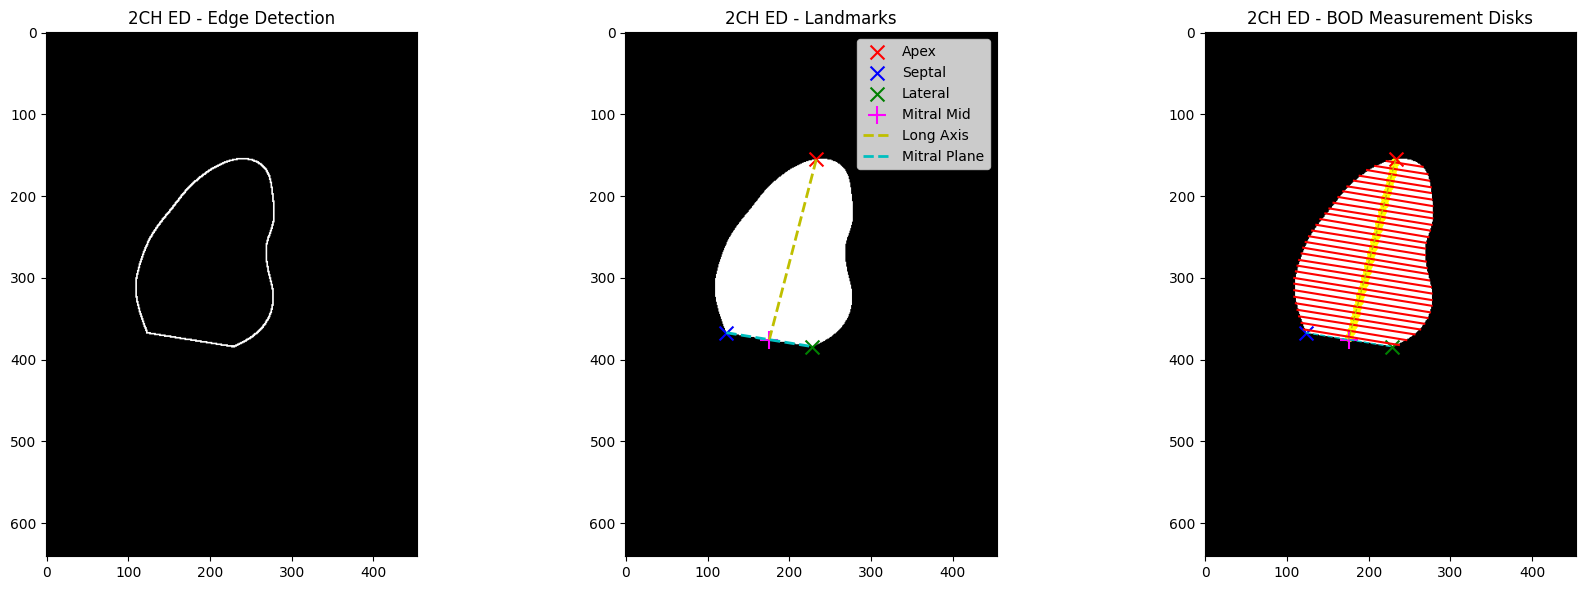


Processing 2CH ES...
View type: 2CH
Apex: (228, 175)
Septal: (163, 345)
Lateral: (230, 350)
Mitral Mid: (196.5, 347.5)


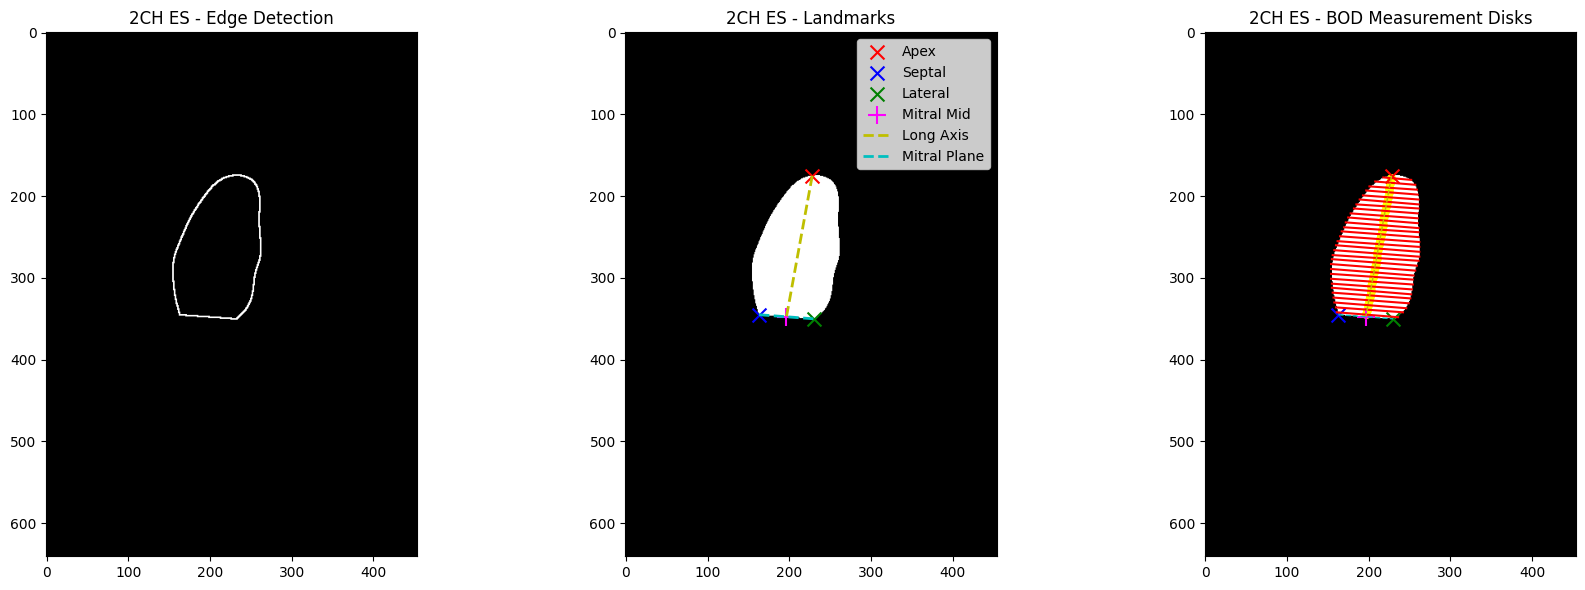


Processing 4CH ED...
View type: 2CH
Apex: (223, 154)
Septal: (238, 396)
Lateral: (126, 364)
Mitral Mid: (182.0, 380.0)


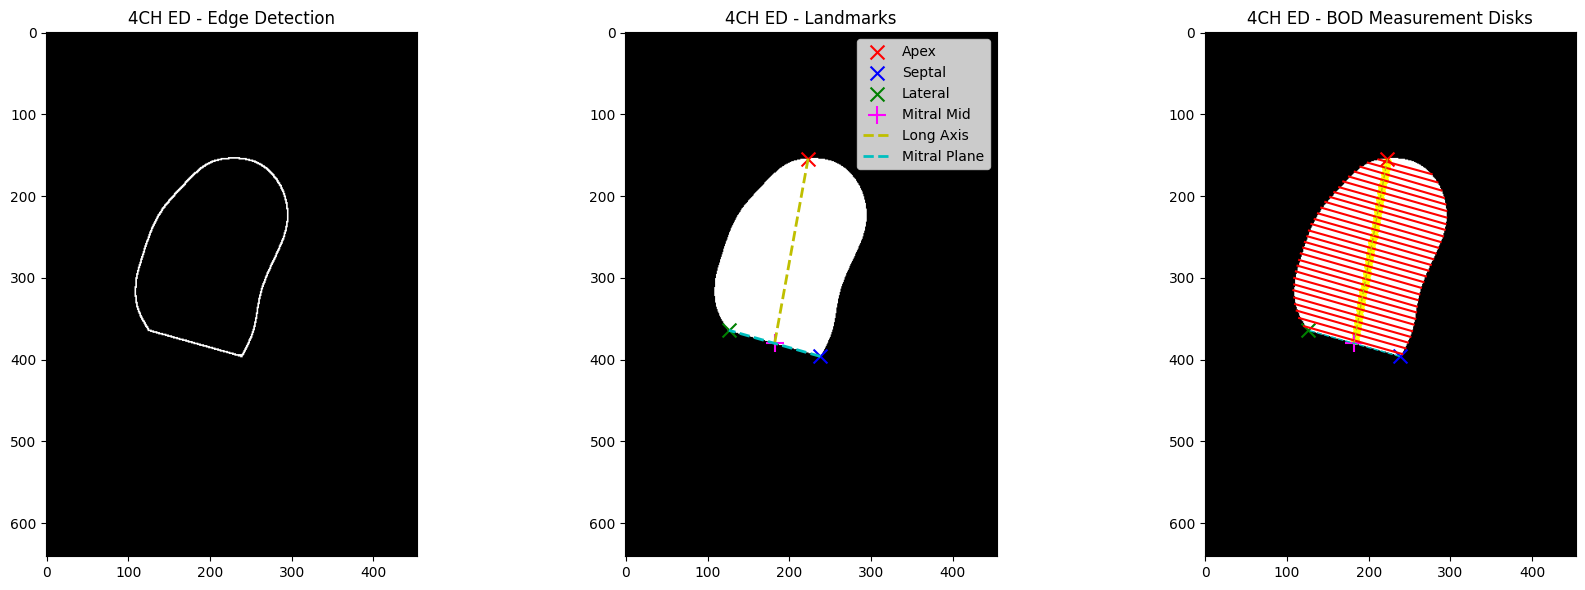


Processing 4CH ES...
View type: 2CH
Apex: (219, 155)
Septal: (245, 364)
Lateral: (145, 343)
Mitral Mid: (195.0, 353.5)


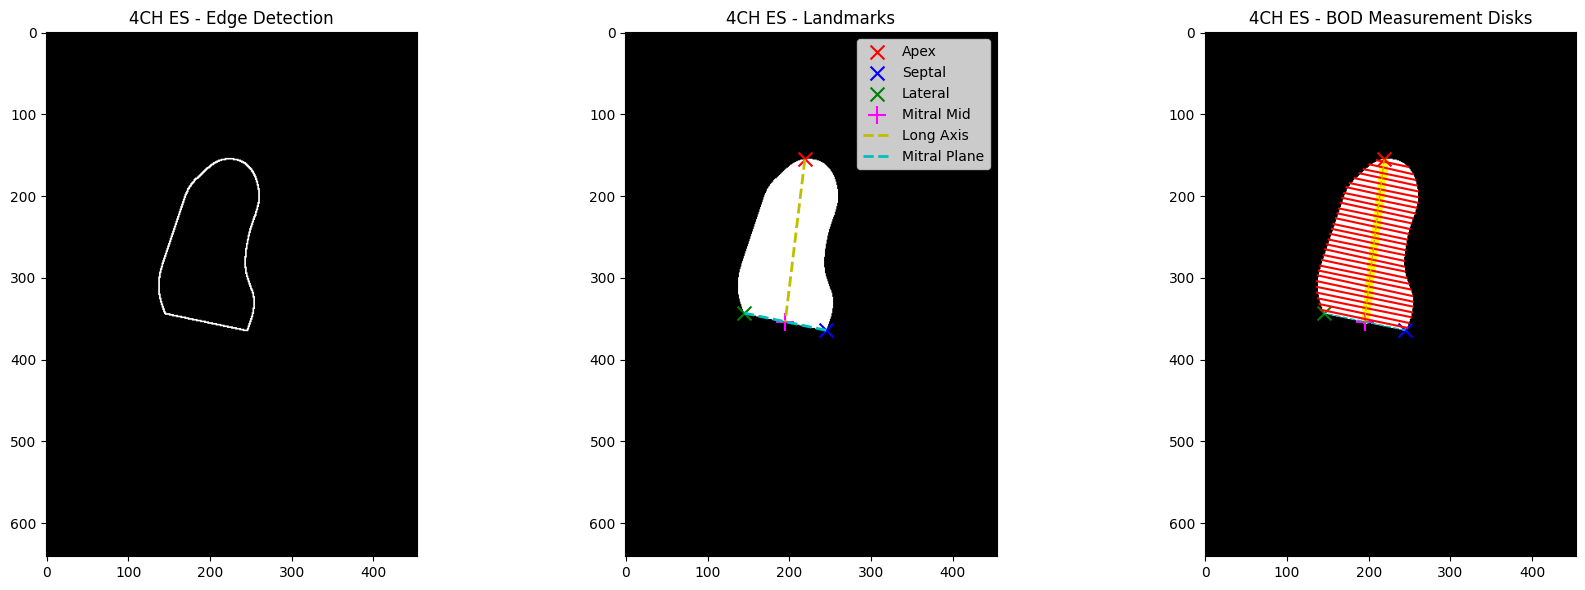


EF Calculation Successful:
EDV: 116080.08 ml
ESV: 41909.54 ml
EF: 63.90%
Using 30 disks and 60° angle between views


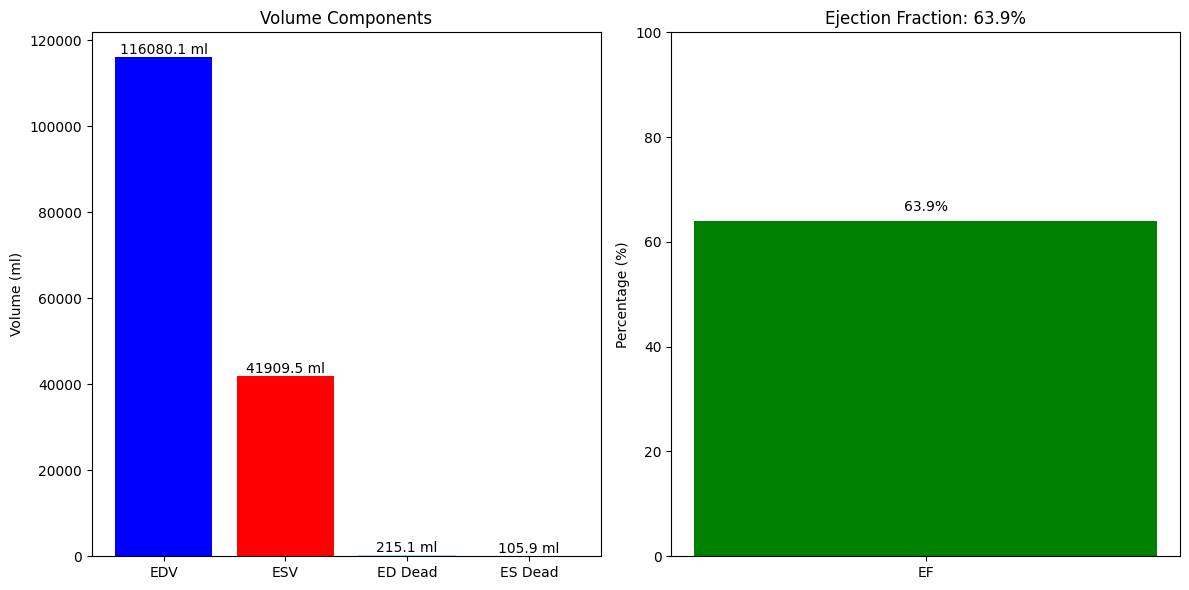

In [4]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import math
import gzip
import shutil
import tempfile
from skimage.filters import sobel
from skimage.feature import canny

def handle_compressed_file(filepath):
    """Handle both .nii.gz and .niigz files"""
    if filepath.endswith('.niigz'):
        with tempfile.NamedTemporaryFile(suffix='.nii.gz', delete=False) as tmp_file:
            with gzip.open(filepath, 'rb') as f_in:
                shutil.copyfileobj(f_in, tmp_file)
            return tmp_file.name
    return filepath

def rotate_image_clockwise(image, angle=90):
    """Rotate image clockwise with better boundary handling"""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def enhanced_edge_detection(seg_binary):
    """Improved edge detection using multiple methods"""
    # Convert to binary
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    
    # Method 1: Canny edge detector with automatic thresholds
    edges_canny = canny(seg_binary/255.0, sigma=1.5)
    
    # Method 2: Sobel edge detection
    edges_sobel = sobel(seg_binary/255.0) > 0.1
    
    # Method 3: Morphological gradient
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    gradient = cv2.morphologyEx(seg_binary, cv2.MORPH_GRADIENT, kernel)
    
    # Combine methods
    combined_edges = (edges_canny | edges_sobel) | (gradient > 0)
    
    # Clean up edges
    combined_edges = combined_edges.astype(np.uint8) * 255
    kernel = np.ones((3,3), np.uint8)
    combined_edges = cv2.morphologyEx(combined_edges, cv2.MORPH_CLOSE, kernel)
    
    return combined_edges

def detect_landmarks(seg_binary, delta_y_fraction=0.15, y_tolerance=20, curvature_threshold=0.2, min_x_separation=0.2):
    """Enhanced landmark detection combining view-specific and flexible logic."""
    # Convert to binary and find contours
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    contours, _ = cv2.findContours(seg_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise ValueError("No LV contour found")
    
    # Use the largest contour
    contour = max(contours, key=cv2.contourArea).squeeze()
    x = contour[:, 0].astype(float)
    y = contour[:, 1].astype(float)
    img_width = seg_binary.shape[1]
    
    # Smooth contour
    x_smooth = gaussian_filter1d(x, sigma=5, mode='wrap')
    y_smooth = gaussian_filter1d(y, sigma=5, mode='wrap')
    
    # Compute curvature
    dx = np.gradient(x_smooth)
    dy = np.gradient(y_smooth)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2 + 1e-10)**1.5
    curvature = (curvature - np.min(curvature)) / (np.max(curvature) - np.min(curvature) + 1e-10)
    
    # Find apex: min y
    apex_idx = np.argmin(y)
    apex_point = (int(x[apex_idx]), int(y[apex_idx]))
    
    # Determine view type
    mean_x = np.mean(x)
    view_type = '2CH' if abs(np.median(x) - mean_x) < 0.3*img_width else '4CH'
    
    # Calculate basal threshold
    max_y = max(y)
    min_y = min(y)
    basal_threshold = max_y - delta_y_fraction * (max_y - min_y)
    
    # Find all peaks in curvature
    peaks, _ = find_peaks(curvature, prominence=0.0005)
    
    # Basal peaks
    basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
    
    # If not enough, expand threshold
    if len(basal_peaks) < 2:
        basal_threshold = max_y - 2 * delta_y_fraction * (max_y - min_y)
        basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
    
    # Get basal points (all points in basal region)
    basal_points = [i for i in range(len(y)) if y[i] >= basal_threshold]
    
    if view_type == '4CH':
        # 4CH specific logic: lateral as highest y, septal on opposite side with high curvature
        if basal_points:
            sorted_by_y = sorted(basal_points, key=lambda i: -y[i])
            lateral_idx = sorted_by_y[0]
            mean_x = np.mean(x[basal_points])
            septal_candidates = [i for i in basal_points 
                                 if (x[i] - mean_x) * (x[lateral_idx] - mean_x) < 0
                                 and curvature[i] >= curvature_threshold]
            
            if septal_candidates:
                septal_idx = max(septal_candidates, key=lambda i: curvature[i])
            else:
                other_points = [i for i in basal_points if i != lateral_idx]
                if other_points:
                    septal_idx = max(other_points, key=lambda i: curvature[i])
                else:
                    septal_idx = lateral_idx
        else:
            raise ValueError("No basal points found for 4CH")
    else:
        # 2CH logic: scoring-based selection to ensure separation and alignment
        if len(basal_peaks) >= 2:
            basal_peaks_sorted = sorted(basal_peaks, key=lambda i: curvature[i], reverse=True)
            septal_idx = basal_peaks_sorted[0]
            septal_side = "right" if x[septal_idx] > mean_x else "left"
            
            lateral_candidates = [i for i in basal_peaks_sorted[1:] 
                                  if ((x[i] > mean_x and septal_side == "left") or 
                                      (x[i] < mean_x and septal_side == "right")) 
                                  and curvature[i] >= curvature_threshold / 2]
            
            if lateral_candidates:
                scores = []
                for i in lateral_candidates:
                    curvature_score = curvature[i] * 0.6
                    y_alignment_score = (1 - min(1, abs(y[i] - y[septal_idx]) / y_tolerance)) * 0.4
                    scores.append(curvature_score + y_alignment_score)
                lateral_idx = lateral_candidates[np.argmax(scores)]
            else:
                lateral_idx = basal_peaks_sorted[1]
            
            # Ensure minimum x separation
            min_x_dist = min_x_separation * img_width
            if abs(x[septal_idx] - x[lateral_idx]) < min_x_dist:
                outward_dir = 1 if x[lateral_idx] > mean_x else -1
                for i in basal_peaks_sorted[2:]:
                    if abs(x[i] - x[septal_idx]) > min_x_dist and \
                       ((x[i] > mean_x and outward_dir > 0) or (x[i] < mean_x and outward_dir < 0)):
                        lateral_idx = i
                        break
            
            # Final check
            if abs(x[septal_idx] - x[lateral_idx]) < min_x_dist:
                print(f"Warning: Points still close after fallback. Distance: {abs(x[septal_idx] - x[lateral_idx]):.1f} px")
        else:
            # Fallback for 2CH
            if basal_points:
                left_idx = basal_points[np.argmin(x[basal_points])]
                right_idx = basal_points[np.argmax(x[basal_points])]
                if curvature[left_idx] > curvature[right_idx]:
                    septal_idx = left_idx
                    lateral_idx = right_idx
                else:
                    septal_idx = right_idx
                    lateral_idx = left_idx
            else:
                raise ValueError("No basal points found for 2CH")
    
    septal_point = (int(x[septal_idx]), int(y[septal_idx]))
    lateral_point = (int(x[lateral_idx]), int(y[lateral_idx]))
    
    # Mitral mid
    mitral_mid = ((septal_point[0] + lateral_point[0]) / 2, (septal_point[1] + lateral_point[1]) / 2)
    
    print(f"View type: {view_type}")
    print(f"Apex: {apex_point}")
    print(f"Septal: {septal_point}")
    print(f"Lateral: {lateral_point}")
    print(f"Mitral Mid: {mitral_mid}")
    
    return apex_point, septal_point, lateral_point, mitral_mid, curvature, contour

def compute_bod_diameters(seg_binary, apex, septal, lateral, mitral_mid, pixel_spacing=(0.1, 0.1), nr_disks=30):
    """Compute BOD diameters with disks using the mitral plane direction."""
    # Create filled mask using enhanced edges
    edges = enhanced_edge_detection(seg_binary)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return 0.0, [], [], 0.0, None, None
    
    max_contour = max(contours, key=cv2.contourArea)
    filled_mask = np.zeros_like(seg_binary, dtype=np.uint8)
    cv2.drawContours(filled_mask, [max_contour], -1, 1, thickness=cv2.FILLED)
    
    # Get boundary using morphological gradient
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    boundary = cv2.morphologyEx(filled_mask, cv2.MORPH_GRADIENT, kernel)
    
    # Calculate long axis length (fixed for non-isotropic spacing)
    dx_long = apex[0] - mitral_mid[0]
    dy_long = apex[1] - mitral_mid[1]
    L_cm = np.sqrt((dx_long * pixel_spacing[0])**2 + (dy_long * pixel_spacing[1])**2)
    
    if L_cm == 0:
        return L_cm, [], [], 0.0, None, None
    
    # Long axis norm for normalization
    long_norm = np.sqrt(dx_long**2 + dy_long**2) + 1e-10
    
    # Mitral plane length (fixed for non-isotropic)
    dx_mitral = lateral[0] - septal[0]
    dy_mitral = lateral[1] - septal[1]
    mit_plane_length = np.sqrt(dx_mitral**2 + dy_mitral**2) + 1e-10
    mit_plane_length_cm = np.sqrt((dx_mitral * pixel_spacing[0])**2 + (dy_mitral * pixel_spacing[1])**2)
    
    if mit_plane_length_cm == 0:
        return L_cm, [], [], 0.0, None, None
    
    # Search vector in the direction of the mitral plane (updated as per request)
    search_vector = np.array([dx_mitral / mit_plane_length, dy_mitral / mit_plane_length])
    
    # Max search distance based on image size
    max_dist = max(seg_binary.shape) // 2
    
    diameters_cm = []
    disk_info = []
    valid_disks = []
    
    for i in range(nr_disks):
        t = (i + 0.5) / nr_disks
        center_x = mitral_mid[0] + t * dx_long
        center_y = mitral_mid[1] + t * dy_long
        
        # Search for boundary points in both directions (fixed to first hit)
        point1 = None
        point2 = None
        
        for direction in [-1, 1]:
            for dist in range(1, max_dist):
                px = int(round(center_x + direction * dist * search_vector[0]))
                py = int(round(center_y + direction * dist * search_vector[1]))
                
                if not (0 <= px < seg_binary.shape[1] and 0 <= py < seg_binary.shape[0]):
                    break
                
                if boundary[py, px]:
                    if direction == -1:
                        point1 = (px, py)
                    else:
                        point2 = (px, py)
                    break
        
        if point1 and point2:
            dx_px = point2[0] - point1[0]
            dy_px = point2[1] - point1[1]
            diameter_cm = np.sqrt((dx_px * pixel_spacing[0])**2 + (dy_px * pixel_spacing[1])**2)
            
            diameters_cm.append(diameter_cm)
            disk_info.append({
                'center': (center_x, center_y),
                'point1': point1,
                'point2': point2,
                'diameter_cm': diameter_cm
            })
            valid_disks.append(i)
        else:
            diameters_cm.append(0.0)
            disk_info.append({
                'center': (center_x, center_y),
                'point1': None,
                'point2': None,
                'diameter_cm': 0.0
            })
    
    # Dead space calculation (unchanged, though non-standard)
    dead_area_cm2 = 0.0
    dead_space_mask = None
    if len(valid_disks) >= 2:
        polygon_points = []
        for i in valid_disks:
            if disk_info[i]['point1']:
                polygon_points.append(disk_info[i]['point1'])
        for i in reversed(valid_disks):
            if disk_info[i]['point2']:
                polygon_points.append(disk_info[i]['point2'])
        if len(polygon_points) > 2:
            disk_area_mask = np.zeros_like(filled_mask, dtype=np.uint8)
            cv2.fillPoly(disk_area_mask, [np.array(polygon_points, dtype=np.int32)], 1)
            dead_space_mask = filled_mask - disk_area_mask
            dead_space_mask = np.clip(dead_space_mask, 0, 1)
            dead_area_px = np.sum(dead_space_mask)
            dead_area_cm2 = dead_area_px * pixel_spacing[0] * pixel_spacing[1]
    
    return L_cm, diameters_cm, disk_info, dead_area_cm2, dead_space_mask, filled_mask

def compute_biplane_volume(L4_cm, L2_cm, diameters4_cm, diameters2_cm, dead_area4_cm2, dead_area2_cm2, nr_disks=30, theta_deg=60):
    """Compute biplane Simpson's volume with 60° angle and 30 disks"""
    theta_rad = np.deg2rad(theta_deg)  # Convert 60 degrees to radians
    L_avg_cm = (L4_cm + L2_cm) / 2
    h_cm = L_avg_cm / nr_disks if nr_disks > 0 else 0
    
    total_volume = 0.0
    disk_volumes = []
    
    for i in range(nr_disks):
        a_i = diameters4_cm[i] if i < len(diameters4_cm) else 0
        b_i = diameters2_cm[i] if i < len(diameters2_cm) else 0
        
        if a_i < 0.1 or b_i < 0.1:
            disk_volume = 0
        else:
            # Updated formula with 60° angle correction
            disk_volume = (np.pi / (4 * np.sin(theta_rad))) * a_i * b_i * h_cm
        
        total_volume += disk_volume
        disk_volumes.append(disk_volume)
    
    valid_disks_4ch = sum(1 for d in diameters4_cm if d > 0.1)
    valid_disks_2ch = sum(1 for d in diameters2_cm if d > 0.1)
    
    if valid_disks_4ch > 0 and valid_disks_2ch > 0:
        coverage_ratio = min(valid_disks_4ch, valid_disks_2ch) / nr_disks
        dead_volume = (dead_area4_cm2 * (valid_disks_4ch/nr_disks) + 
                       dead_area2_cm2 * (valid_disks_2ch/nr_disks)) / 2 * h_cm * coverage_ratio
    else:
        dead_volume = 0
    
    total_volume_with_dead = total_volume + dead_volume
    
    return total_volume_with_dead, disk_volumes, dead_volume

def visualize_processing(seg_data, landmarks, disk_info, view, phase, pixel_spacing):
    """Enhanced visualization with BOD method results"""
    apex, septal, lateral, mitral_mid = landmarks
    
    plt.figure(figsize=(18, 6))
    
    edges = enhanced_edge_detection(seg_data)
    plt.subplot(131)
    plt.imshow(edges, cmap='gray')
    plt.title(f'{view} {phase} - Edge Detection')
    
    plt.subplot(132)
    plt.imshow(seg_data, cmap='gray')
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x', label='Apex')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x', label='Septal')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x', label='Lateral')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+', label='Mitral Mid')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=2, label='Long Axis')
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=2, label='Mitral Plane')
    plt.legend(loc='upper right')
    plt.title(f'{view} {phase} - Landmarks')
    
    plt.subplot(133)
    plt.imshow(seg_data, cmap='gray')
    
    # Plot disks using mitral plane direction (updated)
    for disk in disk_info:
        if disk['point1'] and disk['point2']:
            plt.plot([disk['point1'][0], disk['point2'][0]], 
                     [disk['point1'][1], disk['point2'][1]], 
                     'r-', linewidth=1.5)
            plt.scatter(disk['center'][0], disk['center'][1], c='yellow', s=30)
    
    # Plot landmarks and axes
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=1)
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=1)
    
    plt.title(f'{view} {phase} - BOD Measurement Disks')
    
    plt.tight_layout()
    plt.show()

def process_patient(patient_dir, visualize=False):
    """Main processing function with BOD method"""
    patient_id = os.path.basename(patient_dir)
    print(f"\nProcessing Patient: {patient_id}")
    
    volumes = {'2CH': {'ED': None, 'ES': None}, '4CH': {'ED': None, 'ES': None}}
    all_landmarks = {}
    all_disk_info = {}
    
    try:
        for file in os.listdir(patient_dir):
            if not (file.endswith('_gt.niigz') or file.endswith('_gt.nii.gz')):
                continue
                
            view = None
            phase = None
            
            if '4ch' in file.lower():
                view = '4CH'
            elif '2ch' in file.lower():
                view = '2CH'
                
            if 'ed' in file.lower():
                phase = 'ED'
            elif 'es' in file.lower():
                phase = 'ES'
                
            if not view or not phase:
                continue
                
            print(f"\nProcessing {view} {phase}...")
            
            filepath = os.path.join(patient_dir, file)
            temp_file = None
            
            try:
                if file.endswith('.niigz'):
                    temp_file = handle_compressed_file(filepath)
                    gt_img = nib.load(temp_file)
                else:
                    gt_img = nib.load(filepath)
                    
                gt_data = gt_img.get_fdata()
                pixel_spacing = gt_img.header.get_zooms()[:2]
                
                mask = np.zeros_like(gt_data, dtype=np.uint8)
                mask[gt_data == 1] = 255
                rotated_mask = rotate_image_clockwise(mask)
                
                try:
                    apex, septal, lateral, mitral_mid, _, _ = detect_landmarks(rotated_mask)
                    
                    # Use BOD method with 30 disks
                    L_cm, diameters_cm, disk_info, dead_area_cm2, dead_mask, filled_mask = compute_bod_diameters(
                        rotated_mask, apex, septal, lateral, mitral_mid, pixel_spacing, nr_disks=30
                    )
                    
                    volumes[view][phase] = {
                        'L_cm': L_cm,
                        'diameters_cm': diameters_cm,
                        'dead_area_cm2': dead_area_cm2,
                        'status': 'success'
                    }
                    
                    all_landmarks[(view, phase)] = (apex, septal, lateral, mitral_mid)
                    all_disk_info[(view, phase)] = disk_info
                    
                    if visualize:
                        visualize_processing(rotated_mask, (apex, septal, lateral, mitral_mid), 
                                             disk_info, view, phase, pixel_spacing)
                        
                except Exception as landmark_error:
                    print(f"Landmark detection failed for {view} {phase}: {str(landmark_error)}")
                    volumes[view][phase] = {
                        'status': f'landmark_error: {str(landmark_error)}'
                    }
                    
            except Exception as file_error:
                print(f"Error processing file {file}: {str(file_error)}")
                if view and phase:
                    volumes[view][phase] = {
                        'status': f'file_error: {str(file_error)}'
                    }
                    
            finally:
                if temp_file and os.path.exists(temp_file):
                    os.unlink(temp_file)
    
    except Exception as patient_error:
        print(f"Error processing patient {patient_id}: {str(patient_error)}")
        return None, None, None
    
    missing = []
    for view in ['2CH', '4CH']:
        for phase in ['ED', 'ES']:
            if not volumes[view][phase] or volumes[view][phase].get('status') != 'success':
                missing.append(f"{view} {phase}")
    
    if missing:
        print(f"\nIncomplete data for EF calculation. Missing: {', '.join(missing)}")
    else:
        try:
            # Calculate volumes with 60° angle and 30 disks
            ed_vol, ed_disk_volumes, ed_dead_volume = compute_biplane_volume(
                volumes['4CH']['ED']['L_cm'],
                volumes['2CH']['ED']['L_cm'],
                volumes['4CH']['ED']['diameters_cm'],
                volumes['2CH']['ED']['diameters_cm'],
                volumes['4CH']['ED']['dead_area_cm2'],
                volumes['2CH']['ED']['dead_area_cm2'],
                nr_disks=30,
                theta_deg=60  # 60° angle between views
            )
            
            es_vol, es_disk_volumes, es_dead_volume = compute_biplane_volume(
                volumes['4CH']['ES']['L_cm'],
                volumes['2CH']['ES']['L_cm'],
                volumes['4CH']['ES']['diameters_cm'],
                volumes['2CH']['ES']['diameters_cm'],
                volumes['4CH']['ES']['dead_area_cm2'],
                volumes['2CH']['ES']['dead_area_cm2'],
                nr_disks=30,
                theta_deg=60  # 60° angle between views
            )
            
            ef = ((ed_vol - es_vol) / ed_vol) * 100 if ed_vol > 0 else 0
            
            volumes['EDV'] = ed_vol
            volumes['ESV'] = es_vol
            volumes['EF'] = ef
            volumes['ED_disk_volumes'] = ed_disk_volumes
            volumes['ES_disk_volumes'] = es_disk_volumes
            volumes['ED_dead_volume'] = ed_dead_volume
            volumes['ES_dead_volume'] = es_dead_volume
            
            print(f"\nEF Calculation Successful:")
            print(f"EDV: {ed_vol:.2f} ml")
            print(f"ESV: {es_vol:.2f} ml")
            print(f"EF: {ef:.2f}%")
            print(f"Using 30 disks and 60° angle between views")
            
            if visualize:
                plt.figure(figsize=(12, 6))
                
                # Volume components
                plt.subplot(121)
                volumes_data = [ed_vol, es_vol, ed_dead_volume, es_dead_volume]
                labels = ['EDV', 'ESV', 'ED Dead', 'ES Dead']
                colors = ['blue', 'red', 'lightblue', 'pink']
                bars = plt.bar(labels, volumes_data, color=colors)
                plt.ylabel('Volume (ml)')
                plt.title('Volume Components')
                for bar in bars:
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height,
                             f'{height:.1f} ml', ha='center', va='bottom')
                
                # Ejection fraction
                plt.subplot(122)
                plt.bar(['EF'], [ef], color='green' if ef > 50 else 'orange' if ef > 30 else 'red')
                plt.ylim(0, 100)
                plt.ylabel('Percentage (%)')
                plt.title(f'Ejection Fraction: {ef:.1f}%')
                plt.text(0, ef + 2, f'{ef:.1f}%', ha='center')
                
                plt.tight_layout()
                plt.show()
                
        except Exception as vol_error:
            print(f"Volume calculation error: {str(vol_error)}")
    
    return volumes, all_landmarks, all_disk_info

if __name__ == "__main__":
    base_dir = r"E:\echo heart\Resources"
    patient_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    if not patient_dirs:
        print("No patient directories found")
    else:
        print("Available patients:")
        for i, patient in enumerate(patient_dirs):
            print(f"{i+1}. {patient}")
        
        choice = input("Enter patient number to process (or 'all' for all patients): ")
        
        if choice.lower() == 'all':
            for patient_dir in patient_dirs:
                full_path = os.path.join(base_dir, patient_dir)
                process_patient(full_path, visualize=True)
        elif choice.isdigit():
            idx = int(choice) - 1
            if 0 <= idx < len(patient_dirs):
                full_path = os.path.join(base_dir, patient_dirs[idx])
                process_patient(full_path, visualize=True)
            else:
                print("Invalid patient number")
        else:
            print("Invalid input")

Available patients:
1. patient0001
2. patient0002
3. patient0003
4. patient0004
5. patient0005
6. patient0006
7. patient0007
8. patient0008
9. patient0009
10. patient0010

Processing Patient: patient0004

Processing 2CH ED...
View type: 2CH
Apex: (233, 155)
Septal: (123, 367)
Lateral: (228, 384)
Mitral Mid: (175.5, 375.5)


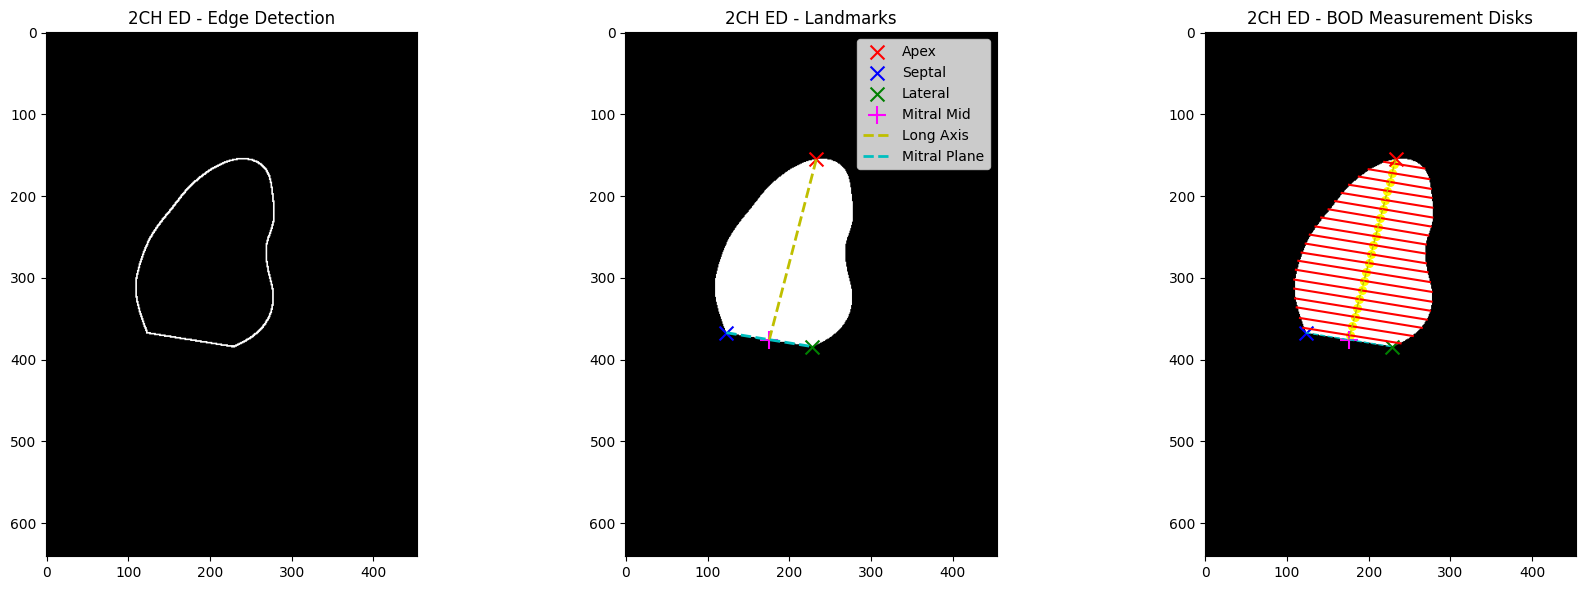


Processing 2CH ES...
View type: 2CH
Apex: (228, 175)
Septal: (163, 345)
Lateral: (230, 350)
Mitral Mid: (196.5, 347.5)


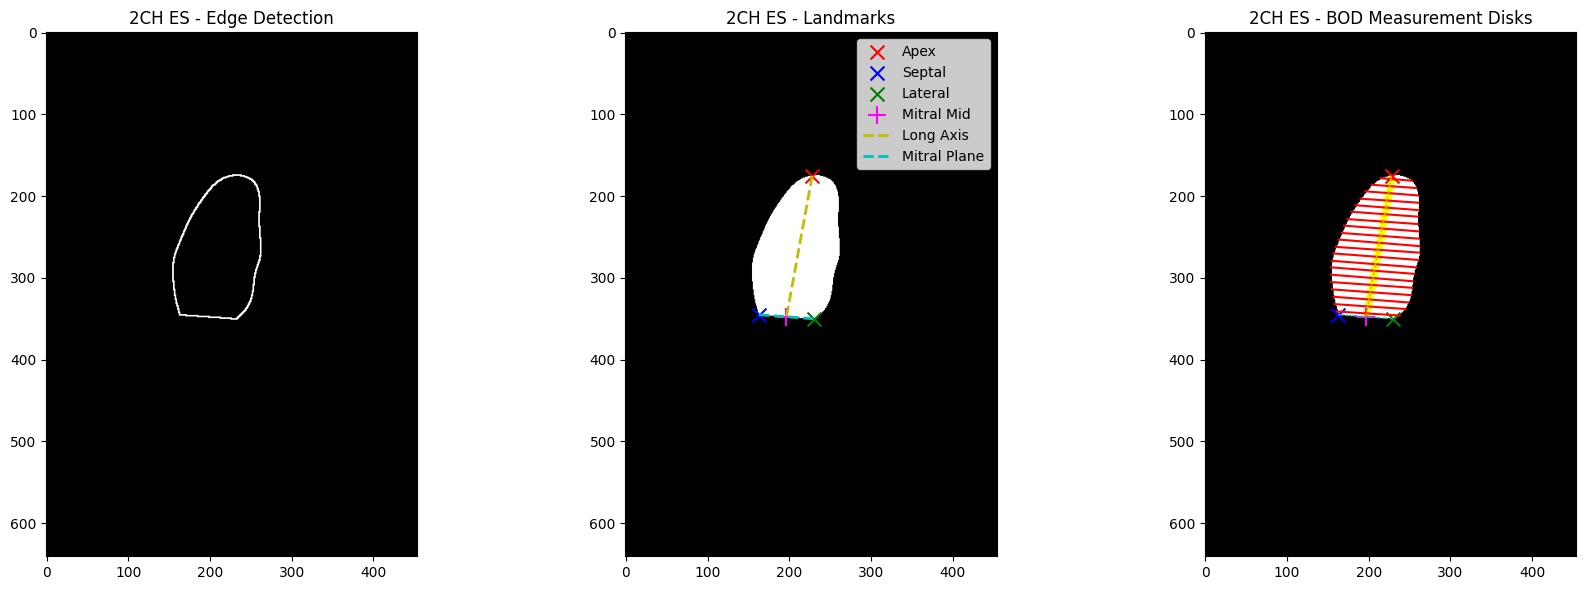


Processing 4CH ED...
View type: 2CH
Apex: (223, 154)
Septal: (238, 396)
Lateral: (126, 364)
Mitral Mid: (182.0, 380.0)


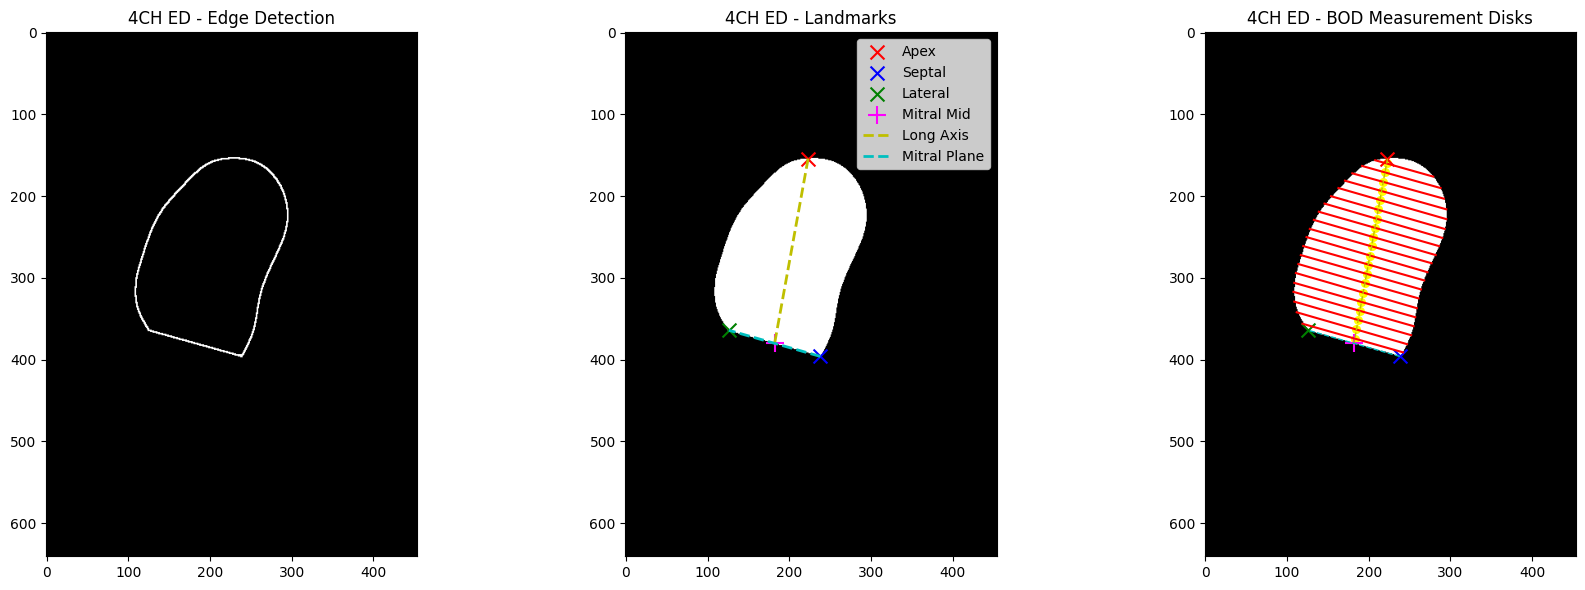


Processing 4CH ES...
View type: 2CH
Apex: (219, 155)
Septal: (245, 364)
Lateral: (145, 343)
Mitral Mid: (195.0, 353.5)


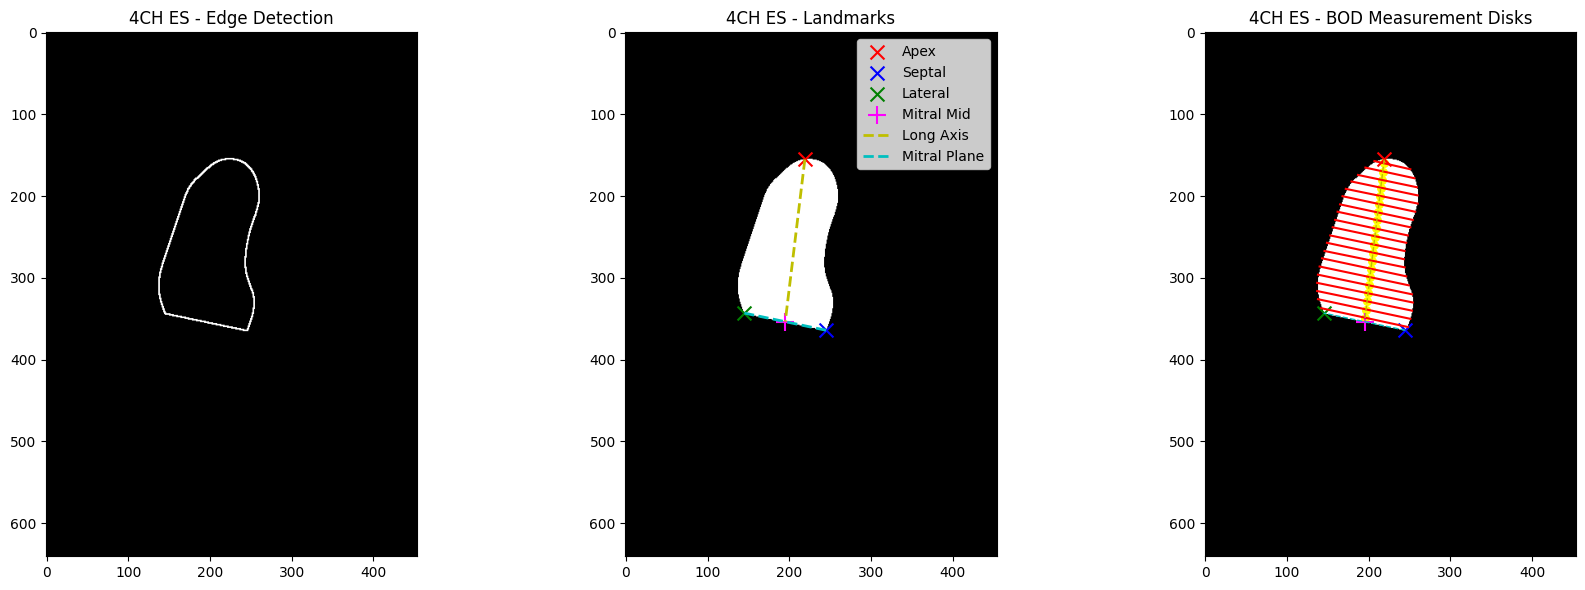


EF Calculation Successful:
EDV: 100981.39 ml
ESV: 36480.60 ml
EF: 63.87%


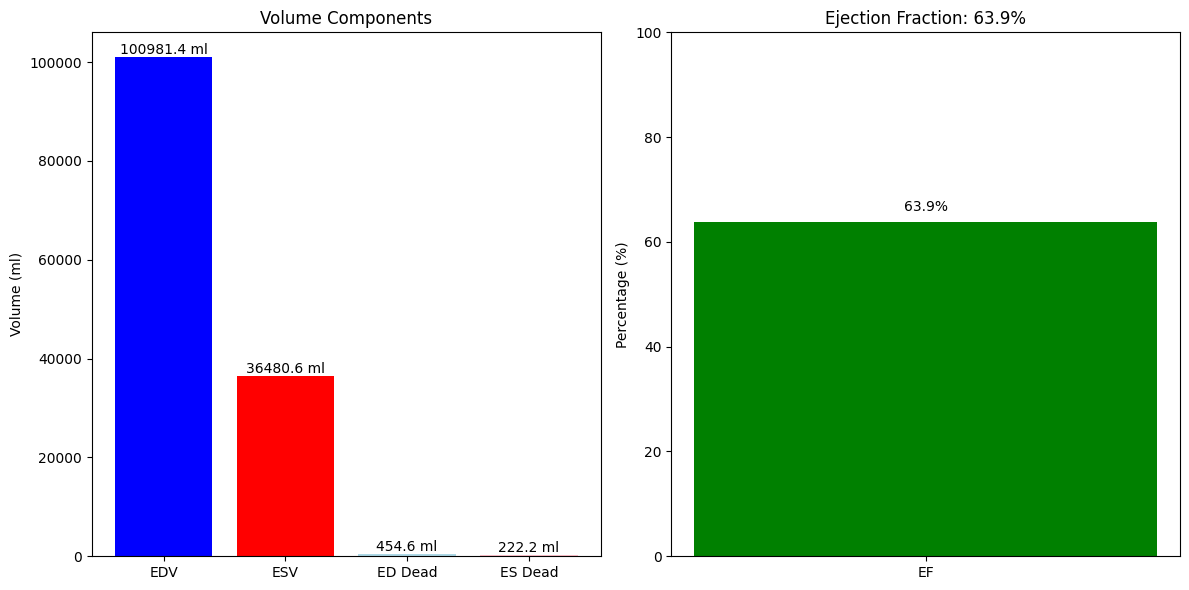

In [5]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import math
import gzip
import shutil
import tempfile
from skimage.filters import sobel
from skimage.feature import canny

def handle_compressed_file(filepath):
    """Handle both .nii.gz and .niigz files"""
    if filepath.endswith('.niigz'):
        with tempfile.NamedTemporaryFile(suffix='.nii.gz', delete=False) as tmp_file:
            with gzip.open(filepath, 'rb') as f_in:
                shutil.copyfileobj(f_in, tmp_file)
            return tmp_file.name
    return filepath

def rotate_image_clockwise(image, angle=90):
    """Rotate image clockwise with better boundary handling"""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def enhanced_edge_detection(seg_binary):
    """Improved edge detection using multiple methods"""
    # Convert to binary
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    
    # Method 1: Canny edge detector with automatic thresholds
    edges_canny = canny(seg_binary/255.0, sigma=1.5)
    
    # Method 2: Sobel edge detection
    edges_sobel = sobel(seg_binary/255.0) > 0.1
    
    # Method 3: Morphological gradient
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    gradient = cv2.morphologyEx(seg_binary, cv2.MORPH_GRADIENT, kernel)
    
    # Combine methods
    combined_edges = (edges_canny | edges_sobel) | (gradient > 0)
    
    # Clean up edges
    combined_edges = combined_edges.astype(np.uint8) * 255
    kernel = np.ones((3,3), np.uint8)
    combined_edges = cv2.morphologyEx(combined_edges, cv2.MORPH_CLOSE, kernel)
    
    return combined_edges

def detect_landmarks(seg_binary, delta_y_fraction=0.15, y_tolerance=20, curvature_threshold=0.2, min_x_separation=0.2):
    """Enhanced landmark detection combining view-specific and flexible logic."""
    # Convert to binary and find contours
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    contours, _ = cv2.findContours(seg_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise ValueError("No LV contour found")
    
    # Use the largest contour
    contour = max(contours, key=cv2.contourArea).squeeze()
    x = contour[:, 0].astype(float)
    y = contour[:, 1].astype(float)
    img_width = seg_binary.shape[1]
    
    # Smooth contour
    x_smooth = gaussian_filter1d(x, sigma=5, mode='wrap')
    y_smooth = gaussian_filter1d(y, sigma=5, mode='wrap')
    
    # Compute curvature
    dx = np.gradient(x_smooth)
    dy = np.gradient(y_smooth)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2 + 1e-10)**1.5
    curvature = (curvature - np.min(curvature)) / (np.max(curvature) - np.min(curvature) + 1e-10)
    
    # Find apex: min y
    apex_idx = np.argmin(y)
    apex_point = (int(x[apex_idx]), int(y[apex_idx]))
    
    # Determine view type
    mean_x = np.mean(x)
    view_type = '2CH' if abs(np.median(x) - mean_x) < 0.3*img_width else '4CH'
    
    # Calculate basal threshold
    max_y = max(y)
    min_y = min(y)
    basal_threshold = max_y - delta_y_fraction * (max_y - min_y)
    
    # Find all peaks in curvature
    peaks, _ = find_peaks(curvature, prominence=0.0005)
    
    # Basal peaks
    basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
    
    # If not enough, expand threshold
    if len(basal_peaks) < 2:
        basal_threshold = max_y - 2 * delta_y_fraction * (max_y - min_y)
        basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
    
    # Get basal points (all points in basal region)
    basal_points = [i for i in range(len(y)) if y[i] >= basal_threshold]
    
    if view_type == '4CH':
        # 4CH specific logic: lateral as highest y, septal on opposite side with high curvature
        if basal_points:
            sorted_by_y = sorted(basal_points, key=lambda i: -y[i])
            lateral_idx = sorted_by_y[0]
            mean_x = np.mean(x[basal_points])
            septal_candidates = [i for i in basal_points 
                                 if (x[i] - mean_x) * (x[lateral_idx] - mean_x) < 0
                                 and curvature[i] >= curvature_threshold]
            
            if septal_candidates:
                septal_idx = max(septal_candidates, key=lambda i: curvature[i])
            else:
                other_points = [i for i in basal_points if i != lateral_idx]
                if other_points:
                    septal_idx = max(other_points, key=lambda i: curvature[i])
                else:
                    septal_idx = lateral_idx
        else:
            raise ValueError("No basal points found for 4CH")
    else:
        # 2CH logic: scoring-based selection to ensure separation and alignment
        if len(basal_peaks) >= 2:
            basal_peaks_sorted = sorted(basal_peaks, key=lambda i: curvature[i], reverse=True)
            septal_idx = basal_peaks_sorted[0]
            septal_side = "right" if x[septal_idx] > mean_x else "left"
            
            lateral_candidates = [i for i in basal_peaks_sorted[1:] 
                                  if ((x[i] > mean_x and septal_side == "left") or 
                                      (x[i] < mean_x and septal_side == "right")) 
                                  and curvature[i] >= curvature_threshold / 2]
            
            if lateral_candidates:
                scores = []
                for i in lateral_candidates:
                    curvature_score = curvature[i] * 0.6
                    y_alignment_score = (1 - min(1, abs(y[i] - y[septal_idx]) / y_tolerance)) * 0.4
                    scores.append(curvature_score + y_alignment_score)
                lateral_idx = lateral_candidates[np.argmax(scores)]
            else:
                lateral_idx = basal_peaks_sorted[1]
            
            # Ensure minimum x separation
            min_x_dist = min_x_separation * img_width
            if abs(x[septal_idx] - x[lateral_idx]) < min_x_dist:
                outward_dir = 1 if x[lateral_idx] > mean_x else -1
                for i in basal_peaks_sorted[2:]:
                    if abs(x[i] - x[septal_idx]) > min_x_dist and \
                       ((x[i] > mean_x and outward_dir > 0) or (x[i] < mean_x and outward_dir < 0)):
                        lateral_idx = i
                        break
            
            # Final check
            if abs(x[septal_idx] - x[lateral_idx]) < min_x_dist:
                print(f"Warning: Points still close after fallback. Distance: {abs(x[septal_idx] - x[lateral_idx]):.1f} px")
        else:
            # Fallback for 2CH
            if basal_points:
                left_idx = basal_points[np.argmin(x[basal_points])]
                right_idx = basal_points[np.argmax(x[basal_points])]
                if curvature[left_idx] > curvature[right_idx]:
                    septal_idx = left_idx
                    lateral_idx = right_idx
                else:
                    septal_idx = right_idx
                    lateral_idx = left_idx
            else:
                raise ValueError("No basal points found for 2CH")
    
    septal_point = (int(x[septal_idx]), int(y[septal_idx]))
    lateral_point = (int(x[lateral_idx]), int(y[lateral_idx]))
    
    # Mitral mid
    mitral_mid = ((septal_point[0] + lateral_point[0]) / 2, (septal_point[1] + lateral_point[1]) / 2)
    
    print(f"View type: {view_type}")
    print(f"Apex: {apex_point}")
    print(f"Septal: {septal_point}")
    print(f"Lateral: {lateral_point}")
    print(f"Mitral Mid: {mitral_mid}")
    
    return apex_point, septal_point, lateral_point, mitral_mid, curvature, contour

def compute_bod_diameters(seg_binary, apex, septal, lateral, mitral_mid, pixel_spacing=(0.1, 0.1), nr_disks=20):
    """Compute BOD diameters with disks using the mitral plane direction."""
    # Create filled mask using enhanced edges
    edges = enhanced_edge_detection(seg_binary)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return 0.0, [], [], 0.0, None, None
    
    max_contour = max(contours, key=cv2.contourArea)
    filled_mask = np.zeros_like(seg_binary, dtype=np.uint8)
    cv2.drawContours(filled_mask, [max_contour], -1, 1, thickness=cv2.FILLED)
    
    # Get boundary using morphological gradient
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    boundary = cv2.morphologyEx(filled_mask, cv2.MORPH_GRADIENT, kernel)
    
    # Calculate long axis length (fixed for non-isotropic spacing)
    dx_long = apex[0] - mitral_mid[0]
    dy_long = apex[1] - mitral_mid[1]
    L_cm = np.sqrt((dx_long * pixel_spacing[0])**2 + (dy_long * pixel_spacing[1])**2)
    
    if L_cm == 0:
        return L_cm, [], [], 0.0, None, None
    
    # Long axis norm for normalization
    long_norm = np.sqrt(dx_long**2 + dy_long**2) + 1e-10
    
    # Mitral plane length (fixed for non-isotropic)
    dx_mitral = lateral[0] - septal[0]
    dy_mitral = lateral[1] - septal[1]
    mit_plane_length = np.sqrt(dx_mitral**2 + dy_mitral**2) + 1e-10
    mit_plane_length_cm = np.sqrt((dx_mitral * pixel_spacing[0])**2 + (dy_mitral * pixel_spacing[1])**2)
    
    if mit_plane_length_cm == 0:
        return L_cm, [], [], 0.0, None, None
    
    # Search vector in the direction of the mitral plane (updated as per request)
    search_vector = np.array([dx_mitral / mit_plane_length, dy_mitral / mit_plane_length])
    
    # Max search distance based on image size
    max_dist = max(seg_binary.shape) // 2
    
    diameters_cm = []
    disk_info = []
    valid_disks = []
    
    for i in range(nr_disks):
        t = (i + 0.5) / nr_disks
        center_x = mitral_mid[0] + t * dx_long
        center_y = mitral_mid[1] + t * dy_long
        
        # Search for boundary points in both directions (fixed to first hit)
        point1 = None
        point2 = None
        
        for direction in [-1, 1]:
            for dist in range(1, max_dist):
                px = int(round(center_x + direction * dist * search_vector[0]))
                py = int(round(center_y + direction * dist * search_vector[1]))
                
                if not (0 <= px < seg_binary.shape[1] and 0 <= py < seg_binary.shape[0]):
                    break
                
                if boundary[py, px]:
                    if direction == -1:
                        point1 = (px, py)
                    else:
                        point2 = (px, py)
                    break
        
        if point1 and point2:
            dx_px = point2[0] - point1[0]
            dy_px = point2[1] - point1[1]
            diameter_cm = np.sqrt((dx_px * pixel_spacing[0])**2 + (dy_px * pixel_spacing[1])**2)
            
            diameters_cm.append(diameter_cm)
            disk_info.append({
                'center': (center_x, center_y),
                'point1': point1,
                'point2': point2,
                'diameter_cm': diameter_cm
            })
            valid_disks.append(i)
        else:
            diameters_cm.append(0.0)
            disk_info.append({
                'center': (center_x, center_y),
                'point1': None,
                'point2': None,
                'diameter_cm': 0.0
            })
    
    # Dead space calculation (unchanged, though non-standard)
    dead_area_cm2 = 0.0
    dead_space_mask = None
    if len(valid_disks) >= 2:
        polygon_points = []
        for i in valid_disks:
            if disk_info[i]['point1']:
                polygon_points.append(disk_info[i]['point1'])
        for i in reversed(valid_disks):
            if disk_info[i]['point2']:
                polygon_points.append(disk_info[i]['point2'])
        if len(polygon_points) > 2:
            disk_area_mask = np.zeros_like(filled_mask, dtype=np.uint8)
            cv2.fillPoly(disk_area_mask, [np.array(polygon_points, dtype=np.int32)], 1)
            dead_space_mask = filled_mask - disk_area_mask
            dead_space_mask = np.clip(dead_space_mask, 0, 1)
            dead_area_px = np.sum(dead_space_mask)
            dead_area_cm2 = dead_area_px * pixel_spacing[0] * pixel_spacing[1]
    
    return L_cm, diameters_cm, disk_info, dead_area_cm2, dead_space_mask, filled_mask

def compute_biplane_volume(L4_cm, L2_cm, diameters4_cm, diameters2_cm, dead_area4_cm2, dead_area2_cm2, nr_disks=20):
    """Compute biplane Simpson's volume with improved dead space handling"""
    L_avg_cm = (L4_cm + L2_cm) / 2
    h_cm = L_avg_cm / nr_disks if nr_disks > 0 else 0
    
    total_volume = 0.0
    disk_volumes = []
    
    for i in range(nr_disks):
        a_i = diameters4_cm[i] if i < len(diameters4_cm) else 0
        b_i = diameters2_cm[i] if i < len(diameters2_cm) else 0
        
        if a_i < 0.1 or b_i < 0.1:
            disk_volume = 0
        else:
            disk_volume = (np.pi / 4) * a_i * b_i * h_cm
        
        total_volume += disk_volume
        disk_volumes.append(disk_volume)
    
    valid_disks_4ch = sum(1 for d in diameters4_cm if d > 0.1)
    valid_disks_2ch = sum(1 for d in diameters2_cm if d > 0.1)
    
    if valid_disks_4ch > 0 and valid_disks_2ch > 0:
        coverage_ratio = min(valid_disks_4ch, valid_disks_2ch) / nr_disks
        dead_volume = (dead_area4_cm2 * (valid_disks_4ch/nr_disks) + 
                       dead_area2_cm2 * (valid_disks_2ch/nr_disks)) / 2 * h_cm * coverage_ratio
    else:
        dead_volume = 0
    
    total_volume_with_dead = total_volume + dead_volume
    
    return total_volume_with_dead, disk_volumes, dead_volume

def visualize_processing(seg_data, landmarks, disk_info, view, phase, pixel_spacing):
    """Enhanced visualization with BOD method results"""
    apex, septal, lateral, mitral_mid = landmarks
    
    plt.figure(figsize=(18, 6))
    
    edges = enhanced_edge_detection(seg_data)
    plt.subplot(131)
    plt.imshow(edges, cmap='gray')
    plt.title(f'{view} {phase} - Edge Detection')
    
    plt.subplot(132)
    plt.imshow(seg_data, cmap='gray')
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x', label='Apex')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x', label='Septal')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x', label='Lateral')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+', label='Mitral Mid')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=2, label='Long Axis')
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=2, label='Mitral Plane')
    plt.legend(loc='upper right')
    plt.title(f'{view} {phase} - Landmarks')
    
    plt.subplot(133)
    plt.imshow(seg_data, cmap='gray')
    
    # Plot disks using mitral plane direction (updated)
    for disk in disk_info:
        if disk['point1'] and disk['point2']:
            plt.plot([disk['point1'][0], disk['point2'][0]], 
                     [disk['point1'][1], disk['point2'][1]], 
                     'r-', linewidth=1.5)
            plt.scatter(disk['center'][0], disk['center'][1], c='yellow', s=30)
    
    # Plot landmarks and axes
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=1)
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=1)
    
    plt.title(f'{view} {phase} - BOD Measurement Disks')
    
    plt.tight_layout()
    plt.show()

def process_patient(patient_dir, visualize=False):
    """Main processing function with BOD method"""
    patient_id = os.path.basename(patient_dir)
    print(f"\nProcessing Patient: {patient_id}")
    
    volumes = {'2CH': {'ED': None, 'ES': None}, '4CH': {'ED': None, 'ES': None}}
    all_landmarks = {}
    all_disk_info = {}
    
    try:
        for file in os.listdir(patient_dir):
            if not (file.endswith('_gt.niigz') or file.endswith('_gt.nii.gz')):
                continue
                
            view = None
            phase = None
            
            if '4ch' in file.lower():
                view = '4CH'
            elif '2ch' in file.lower():
                view = '2CH'
                
            if 'ed' in file.lower():
                phase = 'ED'
            elif 'es' in file.lower():
                phase = 'ES'
                
            if not view or not phase:
                continue
                
            print(f"\nProcessing {view} {phase}...")
            
            filepath = os.path.join(patient_dir, file)
            temp_file = None
            
            try:
                if file.endswith('.niigz'):
                    temp_file = handle_compressed_file(filepath)
                    gt_img = nib.load(temp_file)
                else:
                    gt_img = nib.load(filepath)
                    
                gt_data = gt_img.get_fdata()
                pixel_spacing = gt_img.header.get_zooms()[:2]
                
                mask = np.zeros_like(gt_data, dtype=np.uint8)
                mask[gt_data == 1] = 255
                rotated_mask = rotate_image_clockwise(mask)
                
                try:
                    apex, septal, lateral, mitral_mid, _, _ = detect_landmarks(rotated_mask)
                    
                    # Use BOD method with disks using mitral plane direction (updated)
                    L_cm, diameters_cm, disk_info, dead_area_cm2, dead_mask, filled_mask = compute_bod_diameters(
                        rotated_mask, apex, septal, lateral, mitral_mid, pixel_spacing
                    )
                    
                    volumes[view][phase] = {
                        'L_cm': L_cm,
                        'diameters_cm': diameters_cm,
                        'dead_area_cm2': dead_area_cm2,
                        'status': 'success'
                    }
                    
                    all_landmarks[(view, phase)] = (apex, septal, lateral, mitral_mid)
                    all_disk_info[(view, phase)] = disk_info
                    
                    if visualize:
                        visualize_processing(rotated_mask, (apex, septal, lateral, mitral_mid), 
                                             disk_info, view, phase, pixel_spacing)
                        
                except Exception as landmark_error:
                    print(f"Landmark detection failed for {view} {phase}: {str(landmark_error)}")
                    volumes[view][phase] = {
                        'status': f'landmark_error: {str(landmark_error)}'
                    }
                    
            except Exception as file_error:
                print(f"Error processing file {file}: {str(file_error)}")
                if view and phase:
                    volumes[view][phase] = {
                        'status': f'file_error: {str(file_error)}'
                    }
                    
            finally:
                if temp_file and os.path.exists(temp_file):
                    os.unlink(temp_file)
    
    except Exception as patient_error:
        print(f"Error processing patient {patient_id}: {str(patient_error)}")
        return None, None, None
    
    missing = []
    for view in ['2CH', '4CH']:
        for phase in ['ED', 'ES']:
            if not volumes[view][phase] or volumes[view][phase].get('status') != 'success':
                missing.append(f"{view} {phase}")
    
    if missing:
        print(f"\nIncomplete data for EF calculation. Missing: {', '.join(missing)}")
    else:
        try:
            ed_vol, ed_disk_volumes, ed_dead_volume = compute_biplane_volume(
                volumes['4CH']['ED']['L_cm'],
                volumes['2CH']['ED']['L_cm'],
                volumes['4CH']['ED']['diameters_cm'],
                volumes['2CH']['ED']['diameters_cm'],
                volumes['4CH']['ED']['dead_area_cm2'],
                volumes['2CH']['ED']['dead_area_cm2']
            )
            
            es_vol, es_disk_volumes, es_dead_volume = compute_biplane_volume(
                volumes['4CH']['ES']['L_cm'],
                volumes['2CH']['ES']['L_cm'],
                volumes['4CH']['ES']['diameters_cm'],
                volumes['2CH']['ES']['diameters_cm'],
                volumes['4CH']['ES']['dead_area_cm2'],
                volumes['2CH']['ES']['dead_area_cm2']
            )
            
            ef = ((ed_vol - es_vol) / ed_vol) * 100 if ed_vol > 0 else 0
            
            volumes['EDV'] = ed_vol
            volumes['ESV'] = es_vol
            volumes['EF'] = ef
            volumes['ED_disk_volumes'] = ed_disk_volumes
            volumes['ES_disk_volumes'] = es_disk_volumes
            volumes['ED_dead_volume'] = ed_dead_volume
            volumes['ES_dead_volume'] = es_dead_volume
            
            print(f"\nEF Calculation Successful:")
            print(f"EDV: {ed_vol:.2f} ml")
            print(f"ESV: {es_vol:.2f} ml")
            print(f"EF: {ef:.2f}%")
            
            if visualize:
                plt.figure(figsize=(12, 6))
                
                # Volume components
                plt.subplot(121)
                volumes_data = [ed_vol, es_vol, ed_dead_volume, es_dead_volume]
                labels = ['EDV', 'ESV', 'ED Dead', 'ES Dead']
                colors = ['blue', 'red', 'lightblue', 'pink']
                bars = plt.bar(labels, volumes_data, color=colors)
                plt.ylabel('Volume (ml)')
                plt.title('Volume Components')
                for bar in bars:
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height,
                             f'{height:.1f} ml', ha='center', va='bottom')
                
                # Ejection fraction
                plt.subplot(122)
                plt.bar(['EF'], [ef], color='green' if ef > 50 else 'orange' if ef > 30 else 'red')
                plt.ylim(0, 100)
                plt.ylabel('Percentage (%)')
                plt.title(f'Ejection Fraction: {ef:.1f}%')
                plt.text(0, ef + 2, f'{ef:.1f}%', ha='center')
                
                plt.tight_layout()
                plt.show()
                
        except Exception as vol_error:
            print(f"Volume calculation error: {str(vol_error)}")
    
    return volumes, all_landmarks, all_disk_info

if __name__ == "__main__":
    base_dir = r"E:\echo heart\Resources"
    patient_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    if not patient_dirs:
        print("No patient directories found")
    else:
        print("Available patients:")
        for i, patient in enumerate(patient_dirs):
            print(f"{i+1}. {patient}")
        
        choice = input("Enter patient number to process (or 'all' for all patients): ")
        
        if choice.lower() == 'all':
            for patient_dir in patient_dirs:
                full_path = os.path.join(base_dir, patient_dir)
                process_patient(full_path, visualize=True)
        elif choice.isdigit():
            idx = int(choice) - 1
            if 0 <= idx < len(patient_dirs):
                full_path = os.path.join(base_dir, patient_dirs[idx])
                process_patient(full_path, visualize=True)
            else:
                print("Invalid patient number")
        else:
            print("Invalid input")

Available patients:
1. patient0001
2. patient0002
3. patient0003
4. patient0004
5. patient0005
6. patient0006
7. patient0007
8. patient0008
9. patient0009
10. patient0010

Processing Patient: patient0004
Processing 2CH ED...


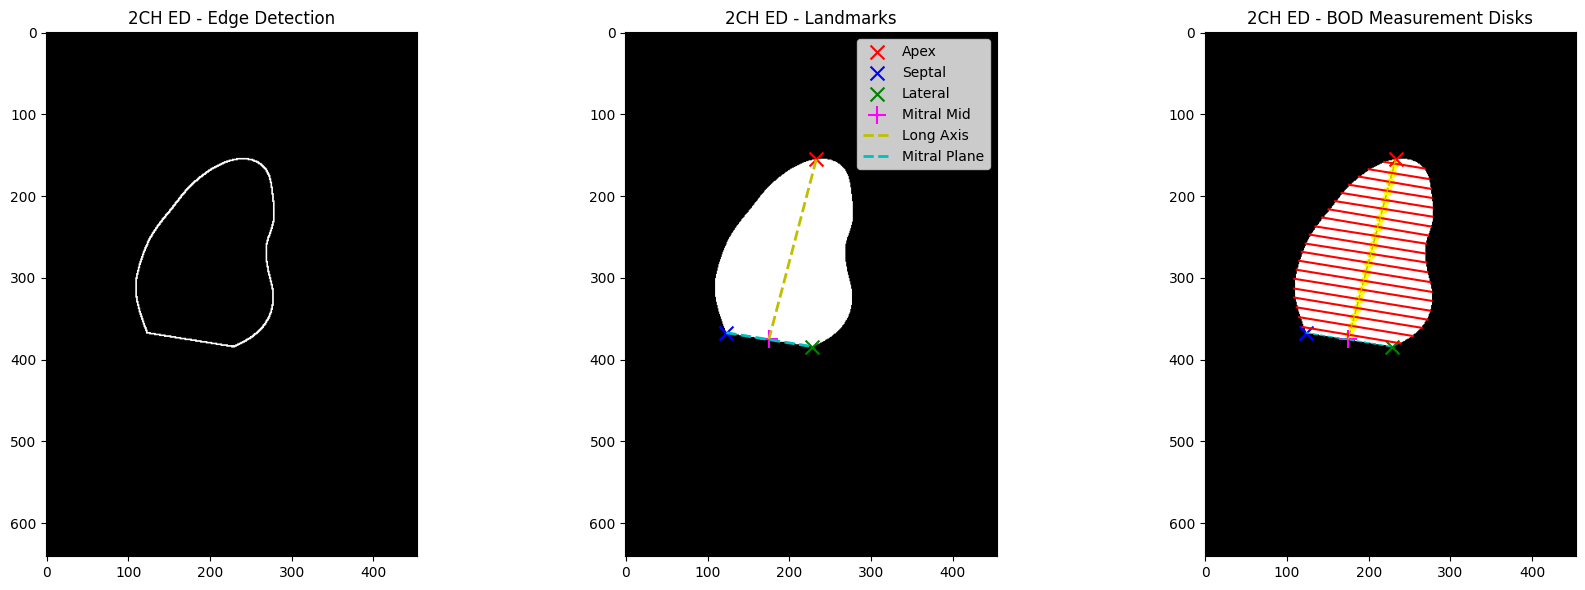

Processing 2CH ES...


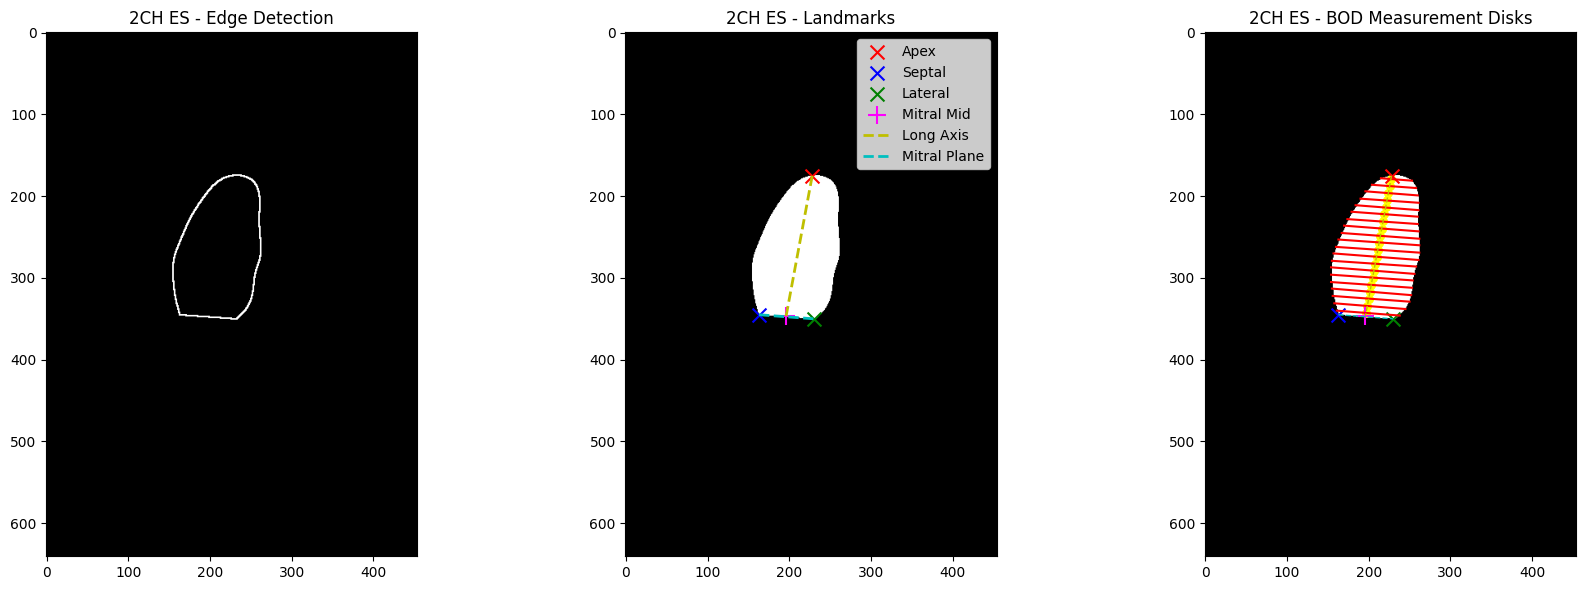

Processing 4CH ED...


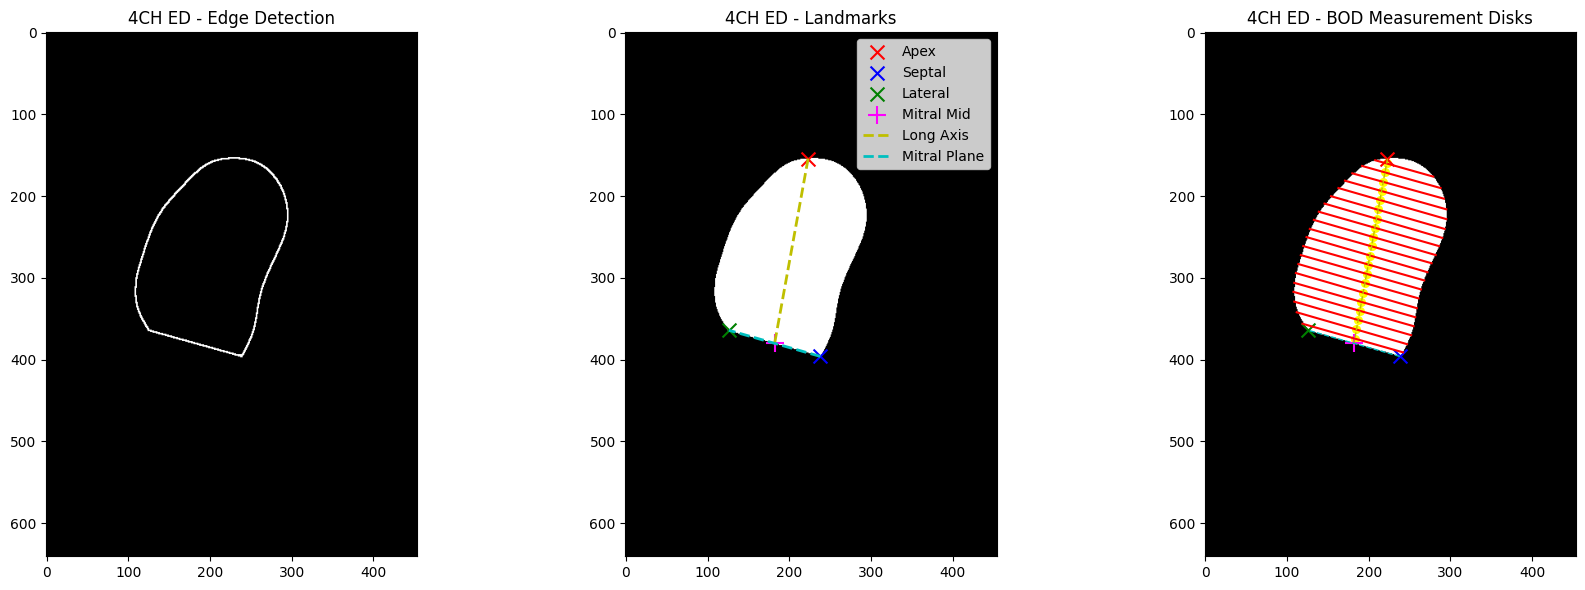

Processing 4CH ES...


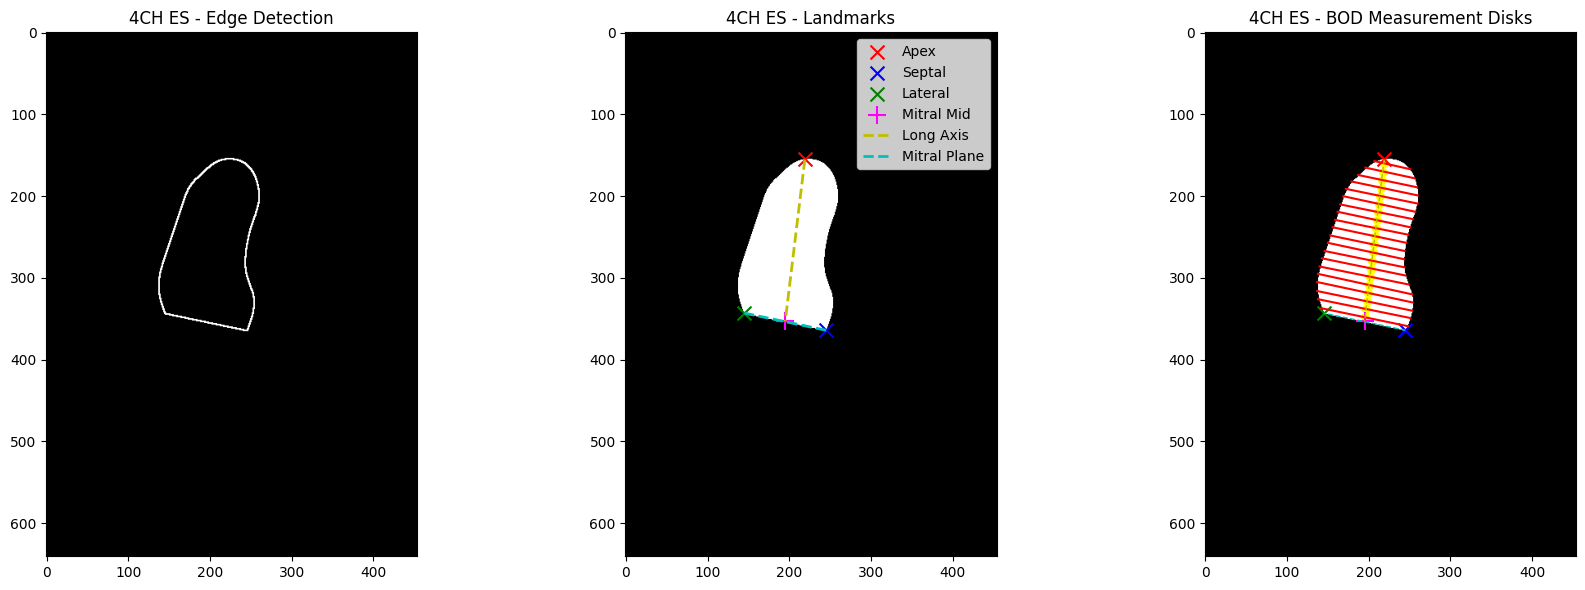


BOD Results:
EDV: 100943.96 ml (Disks: 100483.59 ml, Dead: 460.37 ml)
ESV: 36377.83 ml (Disks: 36147.28 ml, Dead: 230.55 ml)
EF: 63.96%


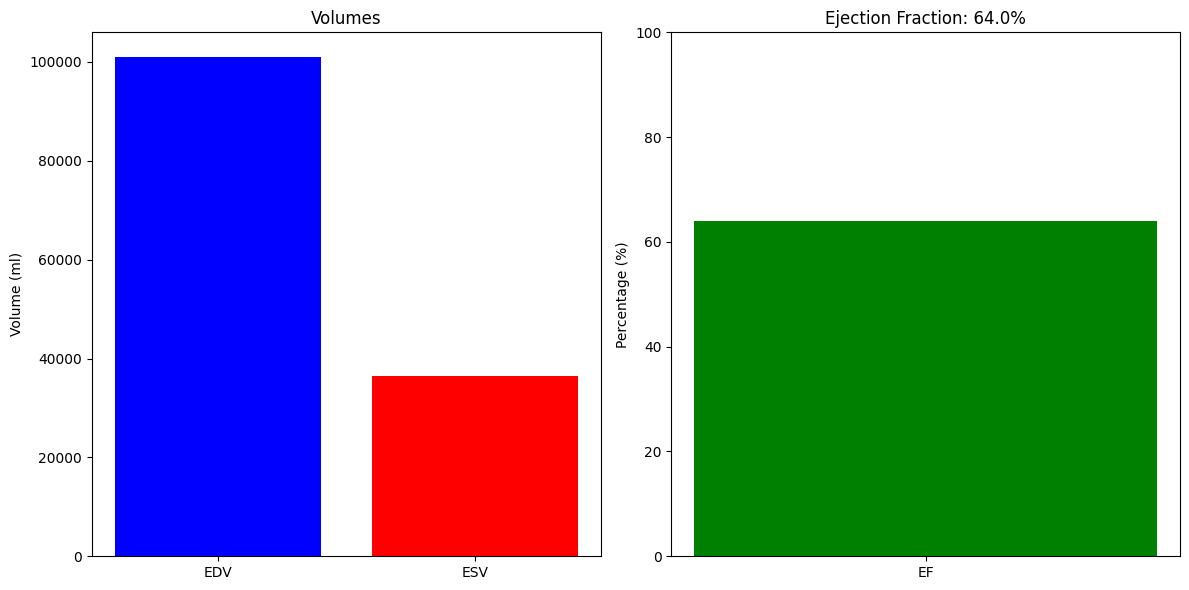

In [7]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import math
import gzip
import shutil
import tempfile
from skimage.filters import sobel
from skimage.feature import canny

def handle_compressed_file(filepath):
    """Handle both .nii.gz and .niigz files"""
    if filepath.endswith('.niigz'):
        with tempfile.NamedTemporaryFile(suffix='.nii.gz', delete=False) as tmp_file:
            with gzip.open(filepath, 'rb') as f_in:
                shutil.copyfileobj(f_in, tmp_file)
            return tmp_file.name
    return filepath

def rotate_image_clockwise(image, angle=90):
    """Rotate image clockwise with better boundary handling"""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def enhanced_edge_detection(seg_binary):
    """Improved edge detection using multiple methods"""
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    edges_canny = canny(seg_binary/255.0, sigma=1.5)
    edges_sobel = sobel(seg_binary/255.0) > 0.1
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    gradient = cv2.morphologyEx(seg_binary, cv2.MORPH_GRADIENT, kernel)
    combined_edges = (edges_canny | edges_sobel) | (gradient > 0)
    combined_edges = combined_edges.astype(np.uint8) * 255
    kernel = np.ones((3,3), np.uint8)
    combined_edges = cv2.morphologyEx(combined_edges, cv2.MORPH_CLOSE, kernel)
    return combined_edges

def detect_landmarks(seg_binary, delta_y_fraction=0.15, y_tolerance=20, 
                     curvature_threshold=0.2, min_x_separation=0.2):
    """Fixed LV landmark detection with robust view-specific logic"""
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    contours, _ = cv2.findContours(seg_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise ValueError("No LV contour found")
    
    contour = max(contours, key=cv2.contourArea).squeeze()
    x = contour[:, 0].astype(float)
    y = contour[:, 1].astype(float)
    img_width = seg_binary.shape[1]
    
    # Smooth contour coordinates
    x_smooth = gaussian_filter1d(x, sigma=5, mode='wrap')
    y_smooth = gaussian_filter1d(y, sigma=5, mode='wrap')
    
    # Compute normalized curvature (0-1)
    dx = np.gradient(x_smooth)
    dy = np.gradient(y_smooth)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2 + 1e-10)**1.5
    curvature = (curvature - np.min(curvature)) / (np.max(curvature) - np.min(curvature) + 1e-10)
    
    # Identify apex (lowest y-point)
    apex_idx = np.argmin(y)
    apex_point = (int(x[apex_idx]), int(y[apex_idx]))
    
    # Determine view type based on x-distribution
    mean_x = np.mean(x)
    view_type = '2CH' if abs(np.median(x) - mean_x) < 0.3*img_width else '4CH'
    
    # Calculate basal region (top 15-30% of height)
    max_y = max(y)
    min_y = min(y)
    basal_threshold = max_y - delta_y_fraction * (max_y - min_y)
    
    # Find curvature peaks in basal region
    peaks, _ = find_peaks(curvature, prominence=0.0005)
    basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
    
    # Expand search if insufficient peaks found
    if len(basal_peaks) < 2:
        basal_threshold = max_y - 2 * delta_y_fraction * (max_y - min_y)
        basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
    
    basal_points = [i for i in range(len(y)) if y[i] >= basal_threshold]
    
    # Handle 4CH view - key improvements:
    if view_type == '4CH':
        # Lateral = highest y-point (mitral valve attachment)
        sorted_by_y = sorted(basal_points, key=lambda i: -y[i])
        lateral_idx = sorted_by_y[0]
        
        # Septal = high-curvature point on opposite side of mean_x
        septal_candidates = [
            i for i in basal_points 
            if (x[i] - mean_x) * (x[lateral_idx] - mean_x) < 0  # Opposite side
            and curvature[i] >= curvature_threshold  # Significant curvature
        ]
        
        if septal_candidates:
            septal_idx = max(septal_candidates, key=lambda i: curvature[i])
        else:
            # Fallback: highest curvature on opposite half
            opposite_points = [
                i for i in basal_points 
                if (x[i] - mean_x) * (x[lateral_idx] - mean_x) < 0
            ]
            if opposite_points:
                septal_idx = max(opposite_points, key=lambda i: curvature[i])
            else:
                septal_idx = lateral_idx  # Ultimate fallback

    # Handle 2CH view - completely rewritten logic:
    else:
        if basal_peaks:
            # Primary septal candidate = highest curvature peak
            basal_peaks.sort(key=lambda i: curvature[i], reverse=True)
            septal_idx = basal_peaks[0]
            septal_side = "right" if x[septal_idx] > mean_x else "left"
            
            # Find lateral candidate on opposite side
            lateral_candidates = [
                i for i in basal_peaks[1:] 
                if ((x[i] > mean_x and septal_side == "left") or 
                    (x[i] < mean_x and septal_side == "right"))
                and curvature[i] >= curvature_threshold/2
            ]
            
            if lateral_candidates:
                # Score by curvature + y-alignment
                scores = [
                    curvature[i]*0.6 + 
                    (1 - min(1, abs(y[i]-y[septal_idx])/y_tolerance))*0.4
                    for i in lateral_candidates
                ]
                lateral_idx = lateral_candidates[np.argmax(scores)]
            else:
                lateral_idx = basal_peaks[1] if len(basal_peaks) > 1 else septal_idx
            
            # Ensure minimum horizontal separation
            min_x_dist = min_x_separation * img_width
            if abs(x[septal_idx] - x[lateral_idx]) < min_x_dist:
                # Search for better lateral candidate
                outward_dir = 1 if lateral_idx > mean_x else -1
                for i in basal_peaks:
                    if i == septal_idx: 
                        continue
                    if (abs(x[i]-x[septal_idx]) > min_x_dist and 
                        (x[i] > mean_x and outward_dir > 0) or 
                         (x[i] < mean_x and outward_dir < 0)):
                        lateral_idx = i
                        break
        else:
            # Emergency fallback: leftmost/rightmost points
            left_idx = basal_points[np.argmin(x[basal_points])]
            right_idx = basal_points[np.argmax(x[basal_points])]
            septal_idx, lateral_idx = (left_idx, right_idx) if curvature[left_idx] > curvature[right_idx] else (right_idx, left_idx)

    septal_point = (int(x[septal_idx]), int(y[septal_idx]))
    lateral_point = (int(x[lateral_idx]), int(y[lateral_idx]))
    mitral_mid = (
        (septal_point[0] + lateral_point[0]) // 2, 
        (septal_point[1] + lateral_point[1]) // 2
    )
    
    return apex_point, septal_point, lateral_point, mitral_mid
    
def compute_bod_diameters(seg_binary, apex, septal, lateral, mitral_mid, pixel_spacing=(0.1, 0.1), nr_disks=20):
    """True BOD method: diameters along mitral plane direction with dead space"""
    # Create filled mask
    edges = enhanced_edge_detection(seg_binary)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return 0.0, [], [], 0.0, None, None
    
    max_contour = max(contours, key=cv2.contourArea)
    filled_mask = np.zeros_like(seg_binary, dtype=np.uint8)
    cv2.drawContours(filled_mask, [max_contour], -1, 1, thickness=cv2.FILLED)
    
    # Get boundary
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    boundary = cv2.morphologyEx(filled_mask, cv2.MORPH_GRADIENT, kernel)
    
    # Long axis length
    dx_long = apex[0] - mitral_mid[0]
    dy_long = apex[1] - mitral_mid[1]
    L_cm = np.sqrt((dx_long * pixel_spacing[0])**2 + (dy_long * pixel_spacing[1])**2)
    if L_cm == 0:
        return L_cm, [], [], 0.0, None, None
    
    # Mitral plane vector (BOD key difference)
    dx_mitral = lateral[0] - septal[0]
    dy_mitral = lateral[1] - septal[1]
    mit_plane_length = np.sqrt(dx_mitral**2 + dy_mitral**2) + 1e-10
    search_vector = np.array([dx_mitral / mit_plane_length, dy_mitral / mit_plane_length])
    
    max_dist = max(seg_binary.shape) // 2
    diameters_cm = []
    disk_info = []
    valid_disks = []
    
    for i in range(nr_disks):
        t = (i + 0.5) / nr_disks
        center_x = mitral_mid[0] + t * dx_long
        center_y = mitral_mid[1] + t * dy_long
        
        point1 = point2 = None
        for direction in [-1, 1]:
            for dist in range(1, max_dist):
                px = int(round(center_x + direction * dist * search_vector[0]))
                py = int(round(center_y + direction * dist * search_vector[1]))
                
                if not (0 <= px < seg_binary.shape[1] and 0 <= py < seg_binary.shape[0]):
                    break
                
                if boundary[py, px]:
                    if direction == -1:
                        point1 = (px, py)
                    else:
                        point2 = (px, py)
                    break
        
        if point1 and point2:
            dx_px = point2[0] - point1[0]
            dy_px = point2[1] - point1[1]
            diameter_cm = np.sqrt((dx_px * pixel_spacing[0])**2 + (dy_px * pixel_spacing[1])**2)
            diameters_cm.append(diameter_cm)
            valid_disks.append(i)
        else:
            diameters_cm.append(0.0)
        
        disk_info.append({
            'center': (center_x, center_y),
            'point1': point1,
            'point2': point2,
            'diameter_cm': diameters_cm[-1] if point1 and point2 else 0.0
        })
    
    # Dead space calculation (BOD-specific)
    dead_area_cm2 = 0.0
    dead_space_mask = None
    if len(valid_disks) >= 2:
        polygon_points = []
        for i in valid_disks:
            if disk_info[i]['point1']:
                polygon_points.append(disk_info[i]['point1'])
        for i in reversed(valid_disks):
            if disk_info[i]['point2']:
                polygon_points.append(disk_info[i]['point2'])
        
        if len(polygon_points) > 2:
            disk_area_mask = np.zeros_like(filled_mask, dtype=np.uint8)
            cv2.fillPoly(disk_area_mask, [np.array(polygon_points, dtype=np.int32)], 1)
            dead_space_mask = filled_mask - disk_area_mask
            dead_space_mask = np.clip(dead_space_mask, 0, 1)
            dead_area_px = np.sum(dead_space_mask)
            dead_area_cm2 = dead_area_px * pixel_spacing[0] * pixel_spacing[1]
    
    return L_cm, diameters_cm, disk_info, dead_area_cm2, dead_space_mask, filled_mask

def compute_bod_volume(L4_cm, L2_cm, diameters4_cm, diameters2_cm, dead_area4_cm2, dead_area2_cm2, nr_disks=20):
    """BOD volume calculation with dead space correction"""
    L_avg_cm = (L4_cm + L2_cm) / 2
    h_cm = L_avg_cm / nr_disks
    
    # Disk volumes
    total_volume = 0.0
    for i in range(nr_disks):
        a_i = diameters4_cm[i] if i < len(diameters4_cm) else 0
        b_i = diameters2_cm[i] if i < len(diameters2_cm) else 0
        if a_i > 0.1 and b_i > 0.1:
            total_volume += (np.pi / 4) * a_i * b_i * h_cm
    
    # Dead space volume (BOD-specific)
    valid_disks_4ch = sum(1 for d in diameters4_cm if d > 0.1)
    valid_disks_2ch = sum(1 for d in diameters2_cm if d > 0.1)
    if valid_disks_4ch > 0 and valid_disks_2ch > 0:
        coverage_ratio = min(valid_disks_4ch, valid_disks_2ch) / nr_disks
        dead_volume = (dead_area4_cm2 + dead_area2_cm2) / 2 * h_cm * coverage_ratio
    else:
        dead_volume = 0
    
    return total_volume + dead_volume, total_volume, dead_volume

def visualize_processing(seg_data, landmarks, disk_info, view, phase, pixel_spacing):
    """Visualize BOD method results"""
    apex, septal, lateral, mitral_mid = landmarks
    
    plt.figure(figsize=(18, 6))
    
    # Edge detection
    plt.subplot(131)
    edges = enhanced_edge_detection(seg_data)
    plt.imshow(edges, cmap='gray')
    plt.title(f'{view} {phase} - Edge Detection')
    
    # Landmarks
    plt.subplot(132)
    plt.imshow(seg_data, cmap='gray')
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x', label='Apex')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x', label='Septal')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x', label='Lateral')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+', label='Mitral Mid')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=2, label='Long Axis')
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=2, label='Mitral Plane')
    plt.legend(loc='upper right')
    plt.title(f'{view} {phase} - Landmarks')
    
    # BOD disks
    plt.subplot(133)
    plt.imshow(seg_data, cmap='gray')
    for disk in disk_info:
        if disk['point1'] and disk['point2']:
            plt.plot([disk['point1'][0], disk['point2'][0]], 
                     [disk['point1'][1], disk['point2'][1]], 
                     'r-', linewidth=1.5)
            plt.scatter(disk['center'][0], disk['center'][1], c='yellow', s=30)
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=1)
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=1)
    plt.title(f'{view} {phase} - BOD Measurement Disks')
    
    plt.tight_layout()
    plt.show()

def process_patient(patient_dir, visualize=False):
    """Main processing function with true BOD method"""
    patient_id = os.path.basename(patient_dir)
    print(f"\nProcessing Patient: {patient_id}")
    
    volumes = {'2CH': {'ED': None, 'ES': None}, '4CH': {'ED': None, 'ES': None}}
    all_landmarks = {}
    all_disk_info = {}
    
    try:
        for file in os.listdir(patient_dir):
            if not (file.endswith('_gt.niigz') or file.endswith('_gt.nii.gz')):
                continue
                
            view = '4CH' if '4ch' in file.lower() else '2CH' if '2ch' in file.lower() else None
            phase = 'ED' if 'ed' in file.lower() else 'ES' if 'es' in file.lower() else None
                
            if not view or not phase:
                continue
                
            print(f"Processing {view} {phase}...")
            filepath = os.path.join(patient_dir, file)
            temp_file = None
            
            try:
                if file.endswith('.niigz'):
                    temp_file = handle_compressed_file(filepath)
                    gt_img = nib.load(temp_file)
                else:
                    gt_img = nib.load(filepath)
                    
                gt_data = gt_img.get_fdata()
                pixel_spacing = gt_img.header.get_zooms()[:2]
                
                mask = np.zeros_like(gt_data, dtype=np.uint8)
                mask[gt_data == 1] = 255
                rotated_mask = rotate_image_clockwise(mask)
                
                try:
                    landmarks = detect_landmarks(rotated_mask)
                    apex, septal, lateral, mitral_mid = landmarks
                    
                    # BOD method with mitral plane direction
                    L_cm, diameters_cm, disk_info, dead_area_cm2, _, _ = compute_bod_diameters(
                        rotated_mask, apex, septal, lateral, mitral_mid, pixel_spacing
                    )
                    
                    volumes[view][phase] = {
                        'L_cm': L_cm,
                        'diameters_cm': diameters_cm,
                        'dead_area_cm2': dead_area_cm2,
                        'status': 'success'
                    }
                    
                    all_landmarks[(view, phase)] = landmarks
                    all_disk_info[(view, phase)] = disk_info
                    
                    if visualize:
                        visualize_processing(rotated_mask, landmarks, disk_info, view, phase, pixel_spacing)
                        
                except Exception as e:
                    print(f"Landmark detection failed: {str(e)}")
                    volumes[view][phase] = {'status': f'error: {str(e)}'}
                    
            except Exception as e:
                print(f"File processing error: {str(e)}")
                if view and phase:
                    volumes[view][phase] = {'status': f'file_error: {str(e)}'}
                    
            finally:
                if temp_file and os.path.exists(temp_file):
                    os.unlink(temp_file)
    
    except Exception as e:
        print(f"Patient processing error: {str(e)}")
        return None, None, None
    
    # Calculate volumes
    missing = []
    for view in ['2CH', '4CH']:
        for phase in ['ED', 'ES']:
            if not volumes[view][phase] or volumes[view][phase].get('status') != 'success':
                missing.append(f"{view} {phase}")
    
    if missing:
        print(f"Incomplete data. Missing: {', '.join(missing)}")
    else:
        try:
            ed_vol, ed_disk_vol, ed_dead_vol = compute_bod_volume(
                volumes['4CH']['ED']['L_cm'],
                volumes['2CH']['ED']['L_cm'],
                volumes['4CH']['ED']['diameters_cm'],
                volumes['2CH']['ED']['diameters_cm'],
                volumes['4CH']['ED']['dead_area_cm2'],
                volumes['2CH']['ED']['dead_area_cm2']
            )
            
            es_vol, es_disk_vol, es_dead_vol = compute_bod_volume(
                volumes['4CH']['ES']['L_cm'],
                volumes['2CH']['ES']['L_cm'],
                volumes['4CH']['ES']['diameters_cm'],
                volumes['2CH']['ES']['diameters_cm'],
                volumes['4CH']['ES']['dead_area_cm2'],
                volumes['2CH']['ES']['dead_area_cm2']
            )
            
            ef = ((ed_vol - es_vol) / ed_vol) * 100 if ed_vol > 0 else 0
            
            volumes['EDV'] = ed_vol
            volumes['ESV'] = es_vol
            volumes['EF'] = ef
            volumes['ED_disk_volume'] = ed_disk_vol
            volumes['ES_disk_volume'] = es_disk_vol
            volumes['ED_dead_volume'] = ed_dead_vol
            volumes['ES_dead_volume'] = es_dead_vol
            
            print(f"\nBOD Results:")
            print(f"EDV: {ed_vol:.2f} ml (Disks: {ed_disk_vol:.2f} ml, Dead: {ed_dead_vol:.2f} ml)")
            print(f"ESV: {es_vol:.2f} ml (Disks: {es_disk_vol:.2f} ml, Dead: {es_dead_vol:.2f} ml)")
            print(f"EF: {ef:.2f}%")
            
            if visualize:
                plt.figure(figsize=(12, 6))
                plt.subplot(121)
                plt.bar(['EDV', 'ESV'], [ed_vol, es_vol], color=['blue', 'red'])
                plt.ylabel('Volume (ml)')
                plt.title('Volumes')
                
                plt.subplot(122)
                plt.bar(['EF'], [ef], color='green' if ef > 50 else 'orange')
                plt.ylim(0, 100)
                plt.ylabel('Percentage (%)')
                plt.title(f'Ejection Fraction: {ef:.1f}%')
                
                plt.tight_layout()
                plt.show()
                
        except Exception as e:
            print(f"Volume calculation error: {str(e)}")
    
    return volumes, all_landmarks, all_disk_info

if __name__ == "__main__":
    base_dir = r"E:\echo heart\Resources"
    patient_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    if not patient_dirs:
        print("No patients found")
    else:
        print("Available patients:")
        for i, patient in enumerate(patient_dirs):
            print(f"{i+1}. {patient}")
        
        choice = input("Enter patient number or 'all': ")
        
        if choice.lower() == 'all':
            for patient_dir in patient_dirs:
                full_path = os.path.join(base_dir, patient_dir)
                process_patient(full_path, visualize=True)
        elif choice.isdigit():
            idx = int(choice) - 1
            if 0 <= idx < len(patient_dirs):
                full_path = os.path.join(base_dir, patient_dirs[idx])
                process_patient(full_path, visualize=True)
            else:
                print("Invalid number")
        else:
            print("Invalid input")

Available patients:
1. patient0001
2. patient0002
3. patient0003
4. patient0004
5. patient0005
6. patient0006
7. patient0007
8. patient0008
9. patient0009
10. patient0010

Processing Patient: patient0004

Processing 2CH ED...
View type: 2CH
Apex: (233, 155)
Septal: (123, 367)
Lateral: (228, 384)
Mitral Mid: (175.5, 375.5)


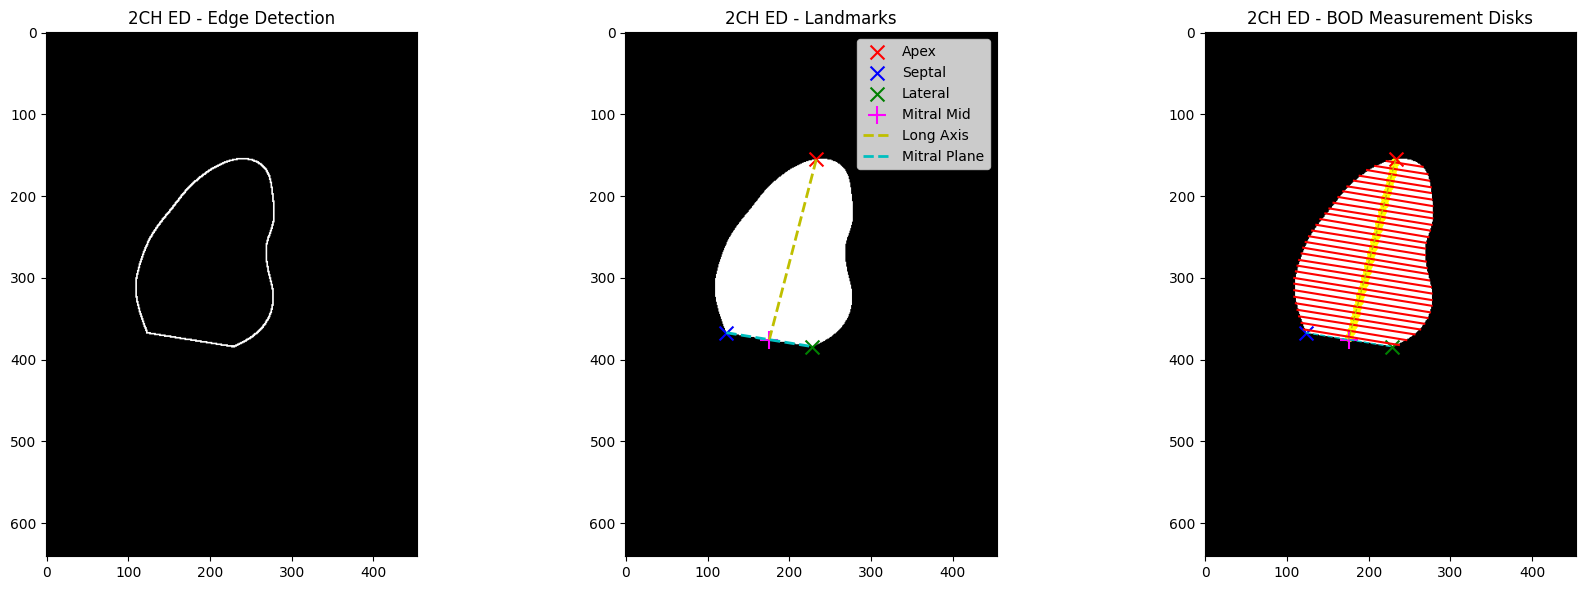


Processing 2CH ES...
View type: 2CH
Apex: (228, 175)
Septal: (163, 345)
Lateral: (230, 350)
Mitral Mid: (196.5, 347.5)


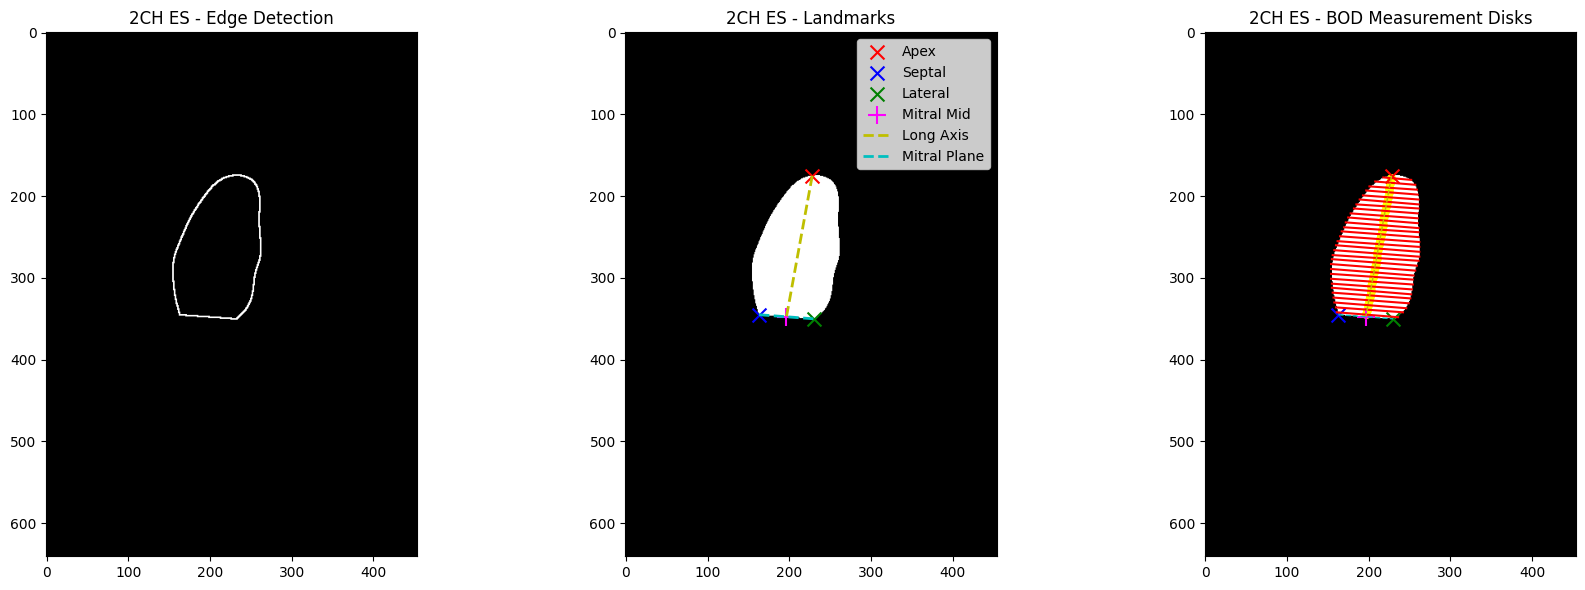


Processing 4CH ED...
View type: 2CH
Apex: (223, 154)
Septal: (238, 396)
Lateral: (126, 364)
Mitral Mid: (182.0, 380.0)


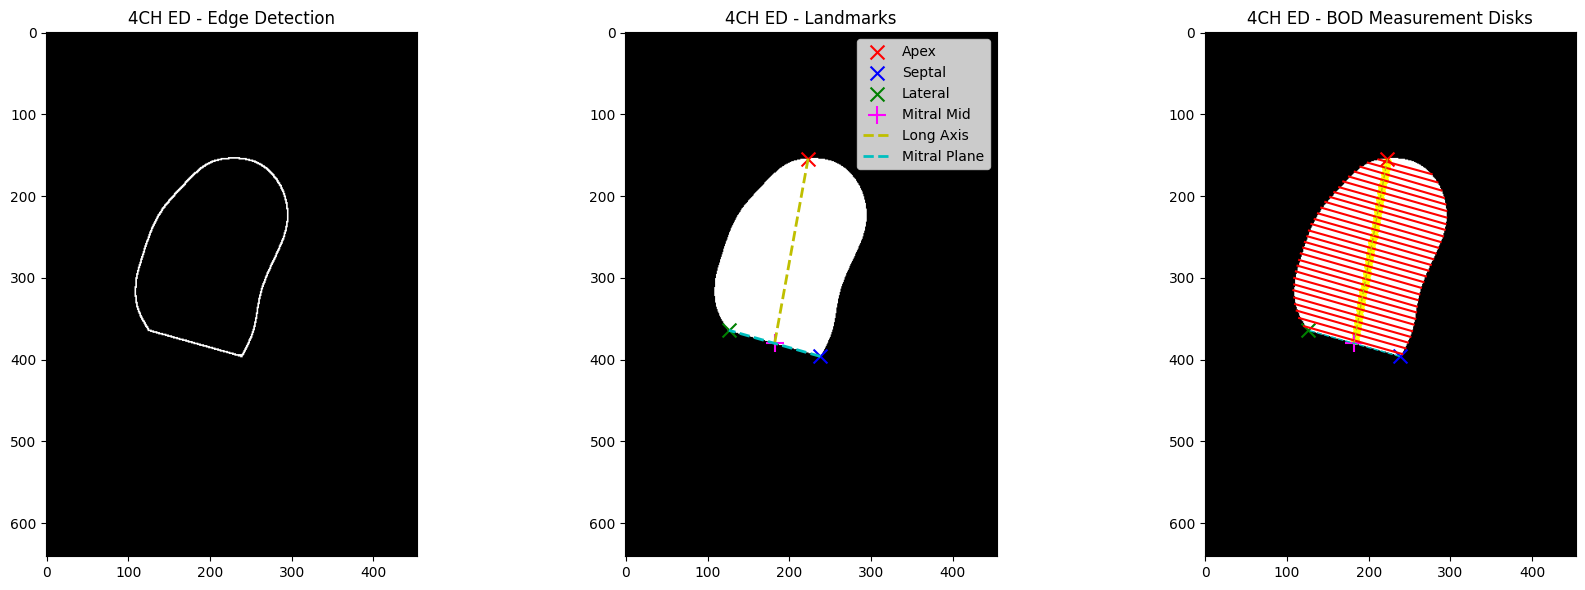


Processing 4CH ES...
View type: 2CH
Apex: (219, 155)
Septal: (245, 364)
Lateral: (145, 343)
Mitral Mid: (195.0, 353.5)


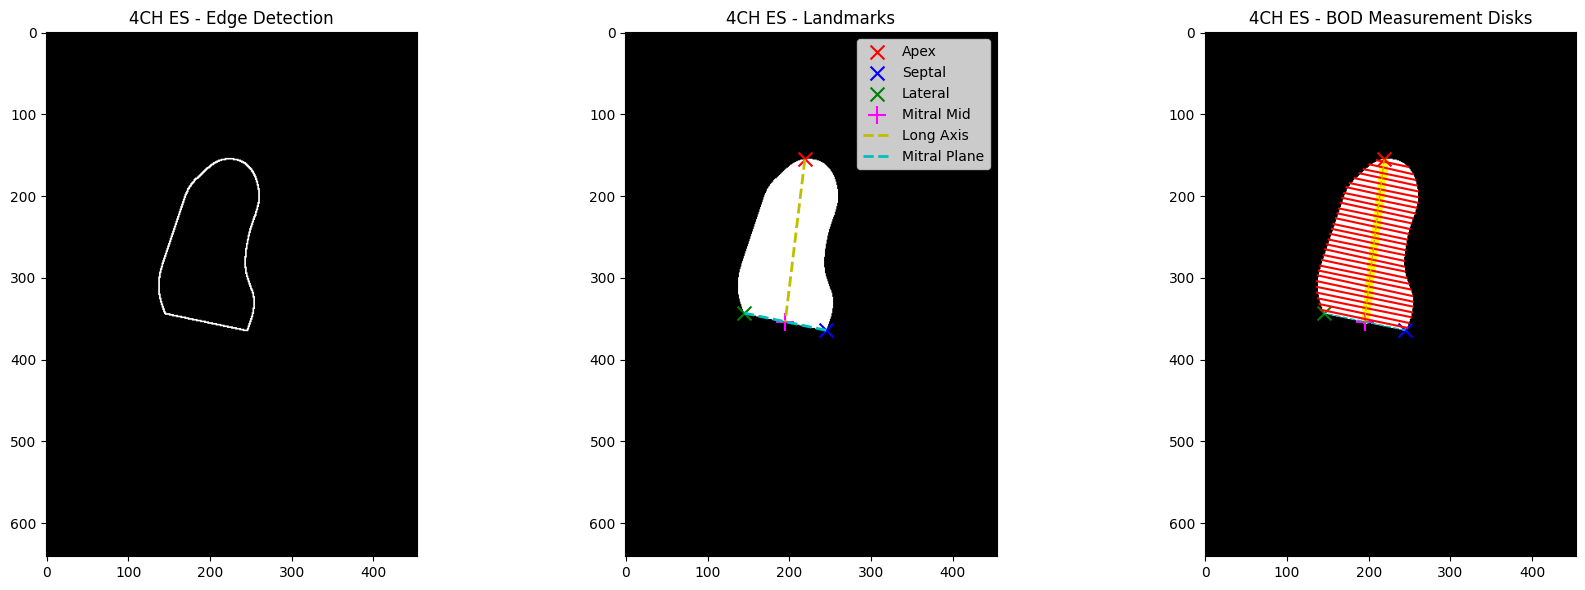


EF Calculation Successful:
EDV: 116080.08 ml
ESV: 41909.54 ml
EF: 63.90%
Using 30 disks and 60° angle between views


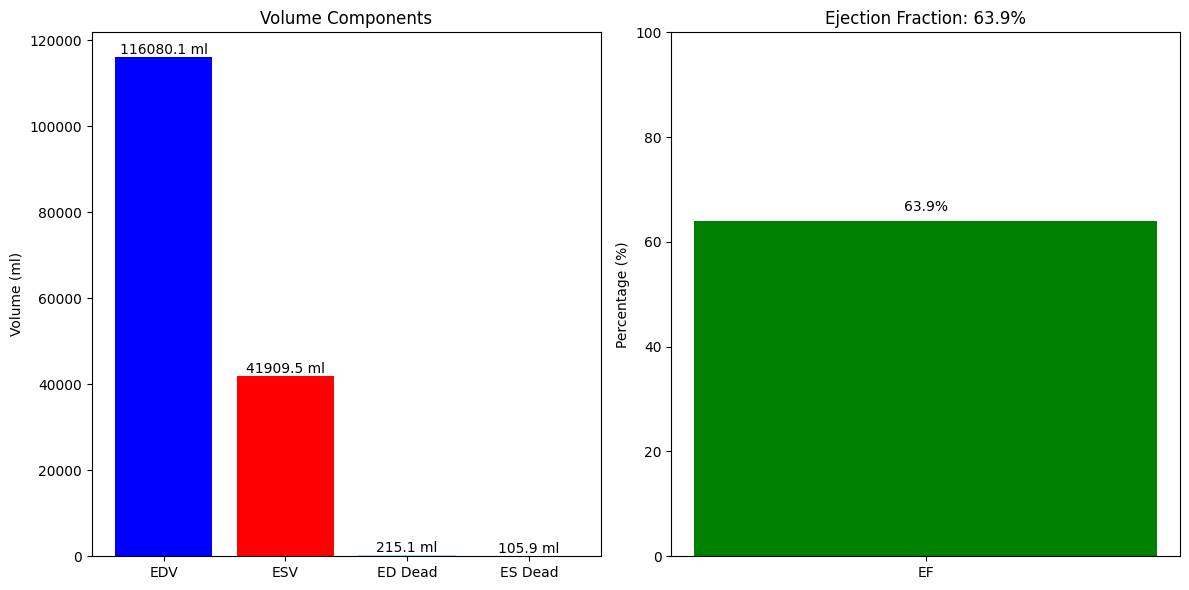

In [8]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import math
import gzip
import shutil
import tempfile
from skimage.filters import sobel
from skimage.feature import canny

def handle_compressed_file(filepath):
    """Handle both .nii.gz and .niigz files"""
    if filepath.endswith('.niigz'):
        with tempfile.NamedTemporaryFile(suffix='.nii.gz', delete=False) as tmp_file:
            with gzip.open(filepath, 'rb') as f_in:
                shutil.copyfileobj(f_in, tmp_file)
            return tmp_file.name
    return filepath

def rotate_image_clockwise(image, angle=90):
    """Rotate image clockwise with better boundary handling"""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def enhanced_edge_detection(seg_binary):
    """Improved edge detection using multiple methods"""
    # Convert to binary
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    
    # Method 1: Canny edge detector with automatic thresholds
    edges_canny = canny(seg_binary/255.0, sigma=1.5)
    
    # Method 2: Sobel edge detection
    edges_sobel = sobel(seg_binary/255.0) > 0.1
    
    # Method 3: Morphological gradient
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    gradient = cv2.morphologyEx(seg_binary, cv2.MORPH_GRADIENT, kernel)
    
    # Combine methods
    combined_edges = (edges_canny | edges_sobel) | (gradient > 0)
    
    # Clean up edges
    combined_edges = combined_edges.astype(np.uint8) * 255
    kernel = np.ones((3,3), np.uint8)
    combined_edges = cv2.morphologyEx(combined_edges, cv2.MORPH_CLOSE, kernel)
    
    return combined_edges

def detect_landmarks(seg_binary, delta_y_fraction=0.15, y_tolerance=20, curvature_threshold=0.2, min_x_separation=0.2):
    """Enhanced landmark detection combining view-specific and flexible logic."""
    # Convert to binary and find contours
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    contours, _ = cv2.findContours(seg_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise ValueError("No LV contour found")
    
    # Use the largest contour
    contour = max(contours, key=cv2.contourArea).squeeze()
    x = contour[:, 0].astype(float)
    y = contour[:, 1].astype(float)
    img_width = seg_binary.shape[1]
    
    # Smooth contour
    x_smooth = gaussian_filter1d(x, sigma=5, mode='wrap')
    y_smooth = gaussian_filter1d(y, sigma=5, mode='wrap')
    
    # Compute curvature
    dx = np.gradient(x_smooth)
    dy = np.gradient(y_smooth)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2 + 1e-10)**1.5
    curvature = (curvature - np.min(curvature)) / (np.max(curvature) - np.min(curvature) + 1e-10)
    
    # Find apex: min y
    apex_idx = np.argmin(y)
    apex_point = (int(x[apex_idx]), int(y[apex_idx]))
    
    # Determine view type
    mean_x = np.mean(x)
    view_type = '2CH' if abs(np.median(x) - mean_x) < 0.3*img_width else '4CH'
    
    # Calculate basal threshold
    max_y = max(y)
    min_y = min(y)
    basal_threshold = max_y - delta_y_fraction * (max_y - min_y)
    
    # Find all peaks in curvature
    peaks, _ = find_peaks(curvature, prominence=0.0005)
    
    # Basal peaks
    basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
    
    # If not enough, expand threshold
    if len(basal_peaks) < 2:
        basal_threshold = max_y - 2 * delta_y_fraction * (max_y - min_y)
        basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
    
    # Get basal points (all points in basal region)
    basal_points = [i for i in range(len(y)) if y[i] >= basal_threshold]
    
    if view_type == '4CH':
        # 4CH specific logic: lateral as highest y, septal on opposite side with high curvature
        if basal_points:
            sorted_by_y = sorted(basal_points, key=lambda i: -y[i])
            lateral_idx = sorted_by_y[0]
            mean_x = np.mean(x[basal_points])
            septal_candidates = [i for i in basal_points 
                                 if (x[i] - mean_x) * (x[lateral_idx] - mean_x) < 0
                                 and curvature[i] >= curvature_threshold]
            
            if septal_candidates:
                septal_idx = max(septal_candidates, key=lambda i: curvature[i])
            else:
                other_points = [i for i in basal_points if i != lateral_idx]
                if other_points:
                    septal_idx = max(other_points, key=lambda i: curvature[i])
                else:
                    septal_idx = lateral_idx
        else:
            raise ValueError("No basal points found for 4CH")
    else:
        # 2CH logic: scoring-based selection to ensure separation and alignment
        if len(basal_peaks) >= 2:
            basal_peaks_sorted = sorted(basal_peaks, key=lambda i: curvature[i], reverse=True)
            septal_idx = basal_peaks_sorted[0]
            septal_side = "right" if x[septal_idx] > mean_x else "left"
            
            lateral_candidates = [i for i in basal_peaks_sorted[1:] 
                                  if ((x[i] > mean_x and septal_side == "left") or 
                                      (x[i] < mean_x and septal_side == "right")) 
                                  and curvature[i] >= curvature_threshold / 2]
            
            if lateral_candidates:
                scores = []
                for i in lateral_candidates:
                    curvature_score = curvature[i] * 0.6
                    y_alignment_score = (1 - min(1, abs(y[i] - y[septal_idx]) / y_tolerance)) * 0.4
                    scores.append(curvature_score + y_alignment_score)
                lateral_idx = lateral_candidates[np.argmax(scores)]
            else:
                lateral_idx = basal_peaks_sorted[1]
            
            # Ensure minimum x separation
            min_x_dist = min_x_separation * img_width
            if abs(x[septal_idx] - x[lateral_idx]) < min_x_dist:
                outward_dir = 1 if x[lateral_idx] > mean_x else -1
                for i in basal_peaks_sorted[2:]:
                    if abs(x[i] - x[septal_idx]) > min_x_dist and \
                       ((x[i] > mean_x and outward_dir > 0) or (x[i] < mean_x and outward_dir < 0)):
                        lateral_idx = i
                        break
            
            # Final check
            if abs(x[septal_idx] - x[lateral_idx]) < min_x_dist:
                print(f"Warning: Points still close after fallback. Distance: {abs(x[septal_idx] - x[lateral_idx]):.1f} px")
        else:
            # Fallback for 2CH
            if basal_points:
                left_idx = basal_points[np.argmin(x[basal_points])]
                right_idx = basal_points[np.argmax(x[basal_points])]
                if curvature[left_idx] > curvature[right_idx]:
                    septal_idx = left_idx
                    lateral_idx = right_idx
                else:
                    septal_idx = right_idx
                    lateral_idx = left_idx
            else:
                raise ValueError("No basal points found for 2CH")
    
    septal_point = (int(x[septal_idx]), int(y[septal_idx]))
    lateral_point = (int(x[lateral_idx]), int(y[lateral_idx]))
    
    # Mitral mid
    mitral_mid = ((septal_point[0] + lateral_point[0]) / 2, (septal_point[1] + lateral_point[1]) / 2)
    
    print(f"View type: {view_type}")
    print(f"Apex: {apex_point}")
    print(f"Septal: {septal_point}")
    print(f"Lateral: {lateral_point}")
    print(f"Mitral Mid: {mitral_mid}")
    
    return apex_point, septal_point, lateral_point, mitral_mid, curvature, contour

def compute_bod_diameters(seg_binary, apex, septal, lateral, mitral_mid, pixel_spacing=(0.1, 0.1), nr_disks=30):
    """Compute BOD diameters with disks using the mitral plane direction."""
    # Create filled mask using enhanced edges
    edges = enhanced_edge_detection(seg_binary)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return 0.0, [], [], 0.0, None, None
    
    max_contour = max(contours, key=cv2.contourArea)
    filled_mask = np.zeros_like(seg_binary, dtype=np.uint8)
    cv2.drawContours(filled_mask, [max_contour], -1, 1, thickness=cv2.FILLED)
    
    # Get boundary using morphological gradient
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    boundary = cv2.morphologyEx(filled_mask, cv2.MORPH_GRADIENT, kernel)
    
    # Calculate long axis length (fixed for non-isotropic spacing)
    dx_long = apex[0] - mitral_mid[0]
    dy_long = apex[1] - mitral_mid[1]
    L_cm = np.sqrt((dx_long * pixel_spacing[0])**2 + (dy_long * pixel_spacing[1])**2)
    
    if L_cm == 0:
        return L_cm, [], [], 0.0, None, None
    
    # Long axis norm for normalization
    long_norm = np.sqrt(dx_long**2 + dy_long**2) + 1e-10
    
    # Mitral plane length (fixed for non-isotropic)
    dx_mitral = lateral[0] - septal[0]
    dy_mitral = lateral[1] - septal[1]
    mit_plane_length = np.sqrt(dx_mitral**2 + dy_mitral**2) + 1e-10
    mit_plane_length_cm = np.sqrt((dx_mitral * pixel_spacing[0])**2 + (dy_mitral * pixel_spacing[1])**2)
    
    if mit_plane_length_cm == 0:
        return L_cm, [], [], 0.0, None, None
    
    # Search vector in the direction of the mitral plane (updated as per request)
    search_vector = np.array([dx_mitral / mit_plane_length, dy_mitral / mit_plane_length])
    
    # Max search distance based on image size
    max_dist = max(seg_binary.shape) // 2
    
    diameters_cm = []
    disk_info = []
    valid_disks = []
    
    for i in range(nr_disks):
        t = (i + 0.5) / nr_disks
        center_x = mitral_mid[0] + t * dx_long
        center_y = mitral_mid[1] + t * dy_long
        
        # Search for boundary points in both directions (fixed to first hit)
        point1 = None
        point2 = None
        
        for direction in [-1, 1]:
            for dist in range(1, max_dist):
                px = int(round(center_x + direction * dist * search_vector[0]))
                py = int(round(center_y + direction * dist * search_vector[1]))
                
                if not (0 <= px < seg_binary.shape[1] and 0 <= py < seg_binary.shape[0]):
                    break
                
                if boundary[py, px]:
                    if direction == -1:
                        point1 = (px, py)
                    else:
                        point2 = (px, py)
                    break
        
        if point1 and point2:
            dx_px = point2[0] - point1[0]
            dy_px = point2[1] - point1[1]
            diameter_cm = np.sqrt((dx_px * pixel_spacing[0])**2 + (dy_px * pixel_spacing[1])**2)
            
            diameters_cm.append(diameter_cm)
            disk_info.append({
                'center': (center_x, center_y),
                'point1': point1,
                'point2': point2,
                'diameter_cm': diameter_cm
            })
            valid_disks.append(i)
        else:
            diameters_cm.append(0.0)
            disk_info.append({
                'center': (center_x, center_y),
                'point1': None,
                'point2': None,
                'diameter_cm': 0.0
            })
    
    # Dead space calculation (unchanged, though non-standard)
    dead_area_cm2 = 0.0
    dead_space_mask = None
    if len(valid_disks) >= 2:
        polygon_points = []
        for i in valid_disks:
            if disk_info[i]['point1']:
                polygon_points.append(disk_info[i]['point1'])
        for i in reversed(valid_disks):
            if disk_info[i]['point2']:
                polygon_points.append(disk_info[i]['point2'])
        if len(polygon_points) > 2:
            disk_area_mask = np.zeros_like(filled_mask, dtype=np.uint8)
            cv2.fillPoly(disk_area_mask, [np.array(polygon_points, dtype=np.int32)], 1)
            dead_space_mask = filled_mask - disk_area_mask
            dead_space_mask = np.clip(dead_space_mask, 0, 1)
            dead_area_px = np.sum(dead_space_mask)
            dead_area_cm2 = dead_area_px * pixel_spacing[0] * pixel_spacing[1]
    
    return L_cm, diameters_cm, disk_info, dead_area_cm2, dead_space_mask, filled_mask

def compute_biplane_volume(L4_cm, L2_cm, diameters4_cm, diameters2_cm, dead_area4_cm2, dead_area2_cm2, nr_disks=30, theta_deg=60):
    """Compute biplane Simpson's volume with 60° angle and 30 disks"""
    theta_rad = np.deg2rad(theta_deg)  # Convert 60 degrees to radians
    L_avg_cm = (L4_cm + L2_cm) / 2
    h_cm = L_avg_cm / nr_disks if nr_disks > 0 else 0
    
    total_volume = 0.0
    disk_volumes = []
    
    for i in range(nr_disks):
        a_i = diameters4_cm[i] if i < len(diameters4_cm) else 0
        b_i = diameters2_cm[i] if i < len(diameters2_cm) else 0
        
        if a_i < 0.1 or b_i < 0.1:
            disk_volume = 0
        else:
            # Updated formula with 60° angle correction
            disk_volume = (np.pi / (4 * np.sin(theta_rad))) * a_i * b_i * h_cm
        
        total_volume += disk_volume
        disk_volumes.append(disk_volume)
    
    valid_disks_4ch = sum(1 for d in diameters4_cm if d > 0.1)
    valid_disks_2ch = sum(1 for d in diameters2_cm if d > 0.1)
    
    if valid_disks_4ch > 0 and valid_disks_2ch > 0:
        coverage_ratio = min(valid_disks_4ch, valid_disks_2ch) / nr_disks
        dead_volume = (dead_area4_cm2 * (valid_disks_4ch/nr_disks) + 
                       dead_area2_cm2 * (valid_disks_2ch/nr_disks)) / 2 * h_cm * coverage_ratio
    else:
        dead_volume = 0
    
    total_volume_with_dead = total_volume + dead_volume
    
    return total_volume_with_dead, disk_volumes, dead_volume

def visualize_processing(seg_data, landmarks, disk_info, view, phase, pixel_spacing):
    """Enhanced visualization with BOD method results"""
    apex, septal, lateral, mitral_mid = landmarks
    
    plt.figure(figsize=(18, 6))
    
    edges = enhanced_edge_detection(seg_data)
    plt.subplot(131)
    plt.imshow(edges, cmap='gray')
    plt.title(f'{view} {phase} - Edge Detection')
    
    plt.subplot(132)
    plt.imshow(seg_data, cmap='gray')
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x', label='Apex')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x', label='Septal')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x', label='Lateral')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+', label='Mitral Mid')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=2, label='Long Axis')
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=2, label='Mitral Plane')
    plt.legend(loc='upper right')
    plt.title(f'{view} {phase} - Landmarks')
    
    plt.subplot(133)
    plt.imshow(seg_data, cmap='gray')
    
    # Plot disks using mitral plane direction (updated)
    for disk in disk_info:
        if disk['point1'] and disk['point2']:
            plt.plot([disk['point1'][0], disk['point2'][0]], 
                     [disk['point1'][1], disk['point2'][1]], 
                     'r-', linewidth=1.5)
            plt.scatter(disk['center'][0], disk['center'][1], c='yellow', s=30)
    
    # Plot landmarks and axes
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=1)
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=1)
    
    plt.title(f'{view} {phase} - BOD Measurement Disks')
    
    plt.tight_layout()
    plt.show()

def process_patient(patient_dir, visualize=False):
    """Main processing function with BOD method"""
    patient_id = os.path.basename(patient_dir)
    print(f"\nProcessing Patient: {patient_id}")
    
    volumes = {'2CH': {'ED': None, 'ES': None}, '4CH': {'ED': None, 'ES': None}}
    all_landmarks = {}
    all_disk_info = {}
    
    try:
        for file in os.listdir(patient_dir):
            if not (file.endswith('_gt.niigz') or file.endswith('_gt.nii.gz')):
                continue
                
            view = None
            phase = None
            
            if '4ch' in file.lower():
                view = '4CH'
            elif '2ch' in file.lower():
                view = '2CH'
                
            if 'ed' in file.lower():
                phase = 'ED'
            elif 'es' in file.lower():
                phase = 'ES'
                
            if not view or not phase:
                continue
                
            print(f"\nProcessing {view} {phase}...")
            
            filepath = os.path.join(patient_dir, file)
            temp_file = None
            
            try:
                if file.endswith('.niigz'):
                    temp_file = handle_compressed_file(filepath)
                    gt_img = nib.load(temp_file)
                else:
                    gt_img = nib.load(filepath)
                    
                gt_data = gt_img.get_fdata()
                pixel_spacing = gt_img.header.get_zooms()[:2]
                
                mask = np.zeros_like(gt_data, dtype=np.uint8)
                mask[gt_data == 1] = 255
                rotated_mask = rotate_image_clockwise(mask)
                
                try:
                    apex, septal, lateral, mitral_mid, _, _ = detect_landmarks(rotated_mask)
                    
                    # Use BOD method with 30 disks
                    L_cm, diameters_cm, disk_info, dead_area_cm2, dead_mask, filled_mask = compute_bod_diameters(
                        rotated_mask, apex, septal, lateral, mitral_mid, pixel_spacing, nr_disks=30
                    )
                    
                    volumes[view][phase] = {
                        'L_cm': L_cm,
                        'diameters_cm': diameters_cm,
                        'dead_area_cm2': dead_area_cm2,
                        'status': 'success'
                    }
                    
                    all_landmarks[(view, phase)] = (apex, septal, lateral, mitral_mid)
                    all_disk_info[(view, phase)] = disk_info
                    
                    if visualize:
                        visualize_processing(rotated_mask, (apex, septal, lateral, mitral_mid), 
                                             disk_info, view, phase, pixel_spacing)
                        
                except Exception as landmark_error:
                    print(f"Landmark detection failed for {view} {phase}: {str(landmark_error)}")
                    volumes[view][phase] = {
                        'status': f'landmark_error: {str(landmark_error)}'
                    }
                    
            except Exception as file_error:
                print(f"Error processing file {file}: {str(file_error)}")
                if view and phase:
                    volumes[view][phase] = {
                        'status': f'file_error: {str(file_error)}'
                    }
                    
            finally:
                if temp_file and os.path.exists(temp_file):
                    os.unlink(temp_file)
    
    except Exception as patient_error:
        print(f"Error processing patient {patient_id}: {str(patient_error)}")
        return None, None, None
    
    missing = []
    for view in ['2CH', '4CH']:
        for phase in ['ED', 'ES']:
            if not volumes[view][phase] or volumes[view][phase].get('status') != 'success':
                missing.append(f"{view} {phase}")
    
    if missing:
        print(f"\nIncomplete data for EF calculation. Missing: {', '.join(missing)}")
    else:
        try:
            # Calculate volumes with 60° angle and 30 disks
            ed_vol, ed_disk_volumes, ed_dead_volume = compute_biplane_volume(
                volumes['4CH']['ED']['L_cm'],
                volumes['2CH']['ED']['L_cm'],
                volumes['4CH']['ED']['diameters_cm'],
                volumes['2CH']['ED']['diameters_cm'],
                volumes['4CH']['ED']['dead_area_cm2'],
                volumes['2CH']['ED']['dead_area_cm2'],
                nr_disks=30,
                theta_deg=60  # 60° angle between views
            )
            
            es_vol, es_disk_volumes, es_dead_volume = compute_biplane_volume(
                volumes['4CH']['ES']['L_cm'],
                volumes['2CH']['ES']['L_cm'],
                volumes['4CH']['ES']['diameters_cm'],
                volumes['2CH']['ES']['diameters_cm'],
                volumes['4CH']['ES']['dead_area_cm2'],
                volumes['2CH']['ES']['dead_area_cm2'],
                nr_disks=30,
                theta_deg=60  # 60° angle between views
            )
            
            ef = ((ed_vol - es_vol) / ed_vol) * 100 if ed_vol > 0 else 0
            
            volumes['EDV'] = ed_vol
            volumes['ESV'] = es_vol
            volumes['EF'] = ef
            volumes['ED_disk_volumes'] = ed_disk_volumes
            volumes['ES_disk_volumes'] = es_disk_volumes
            volumes['ED_dead_volume'] = ed_dead_volume
            volumes['ES_dead_volume'] = es_dead_volume
            
            print(f"\nEF Calculation Successful:")
            print(f"EDV: {ed_vol:.2f} ml")
            print(f"ESV: {es_vol:.2f} ml")
            print(f"EF: {ef:.2f}%")
            print(f"Using 30 disks and 60° angle between views")
            
            if visualize:
                plt.figure(figsize=(12, 6))
                
                # Volume components
                plt.subplot(121)
                volumes_data = [ed_vol, es_vol, ed_dead_volume, es_dead_volume]
                labels = ['EDV', 'ESV', 'ED Dead', 'ES Dead']
                colors = ['blue', 'red', 'lightblue', 'pink']
                bars = plt.bar(labels, volumes_data, color=colors)
                plt.ylabel('Volume (ml)')
                plt.title('Volume Components')
                for bar in bars:
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height,
                             f'{height:.1f} ml', ha='center', va='bottom')
                
                # Ejection fraction
                plt.subplot(122)
                plt.bar(['EF'], [ef], color='green' if ef > 50 else 'orange' if ef > 30 else 'red')
                plt.ylim(0, 100)
                plt.ylabel('Percentage (%)')
                plt.title(f'Ejection Fraction: {ef:.1f}%')
                plt.text(0, ef + 2, f'{ef:.1f}%', ha='center')
                
                plt.tight_layout()
                plt.show()
                
        except Exception as vol_error:
            print(f"Volume calculation error: {str(vol_error)}")
    
    return volumes, all_landmarks, all_disk_info

if __name__ == "__main__":
    base_dir = r"E:\echo heart\Resources"
    patient_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    if not patient_dirs:
        print("No patient directories found")
    else:
        print("Available patients:")
        for i, patient in enumerate(patient_dirs):
            print(f"{i+1}. {patient}")
        
        choice = input("Enter patient number to process (or 'all' for all patients): ")
        
        if choice.lower() == 'all':
            for patient_dir in patient_dirs:
                full_path = os.path.join(base_dir, patient_dir)
                process_patient(full_path, visualize=True)
        elif choice.isdigit():
            idx = int(choice) - 1
            if 0 <= idx < len(patient_dirs):
                full_path = os.path.join(base_dir, patient_dirs[idx])
                process_patient(full_path, visualize=True)
            else:
                print("Invalid patient number")
        else:
            print("Invalid input")

Available patients:
1. patient0001
2. patient0002
3. patient0003
4. patient0004
5. patient0005
6. patient0006
7. patient0007
8. patient0008
9. patient0009
10. patient0010

Processing Patient: patient0004

Processing 2CH ED...
View type: 2CH
Apex: (233, 155)
Septal: (123, 367)
Lateral: (228, 384)
Mitral Mid: (175.5, 375.5)


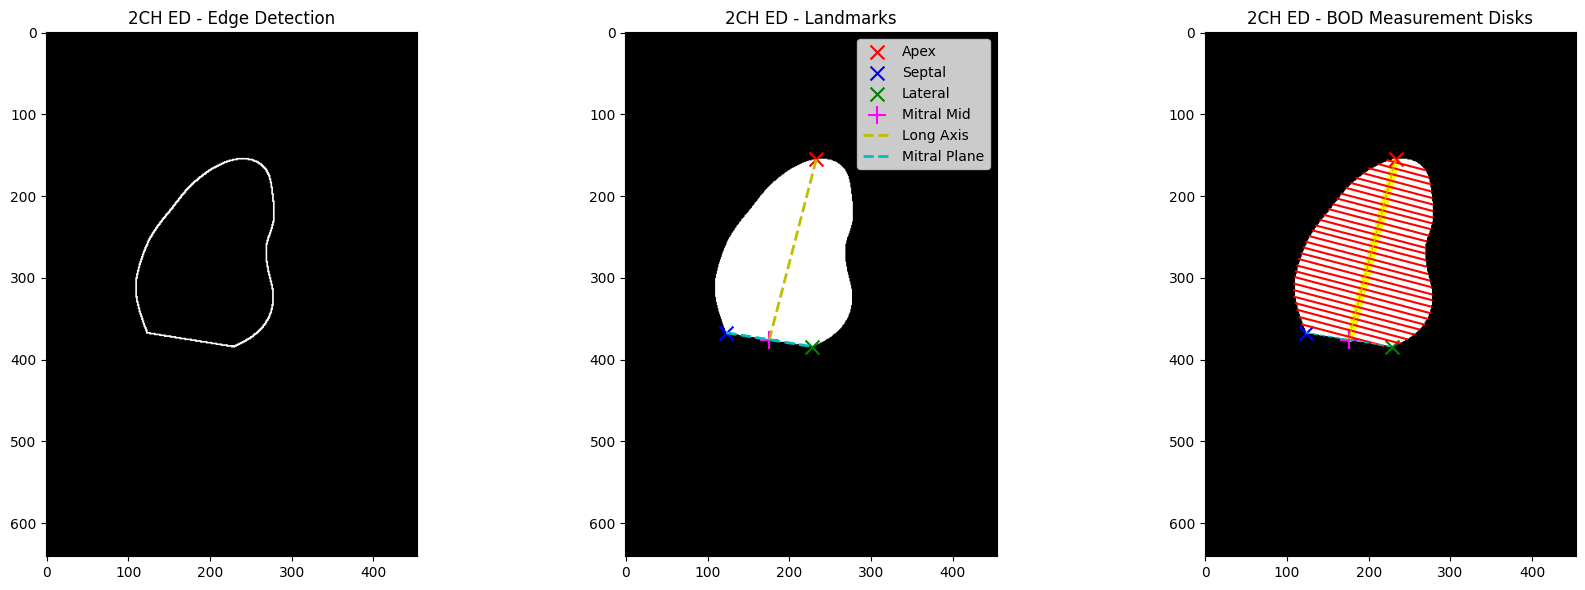


Processing 2CH ES...
View type: 2CH
Apex: (228, 175)
Septal: (163, 345)
Lateral: (230, 350)
Mitral Mid: (196.5, 347.5)


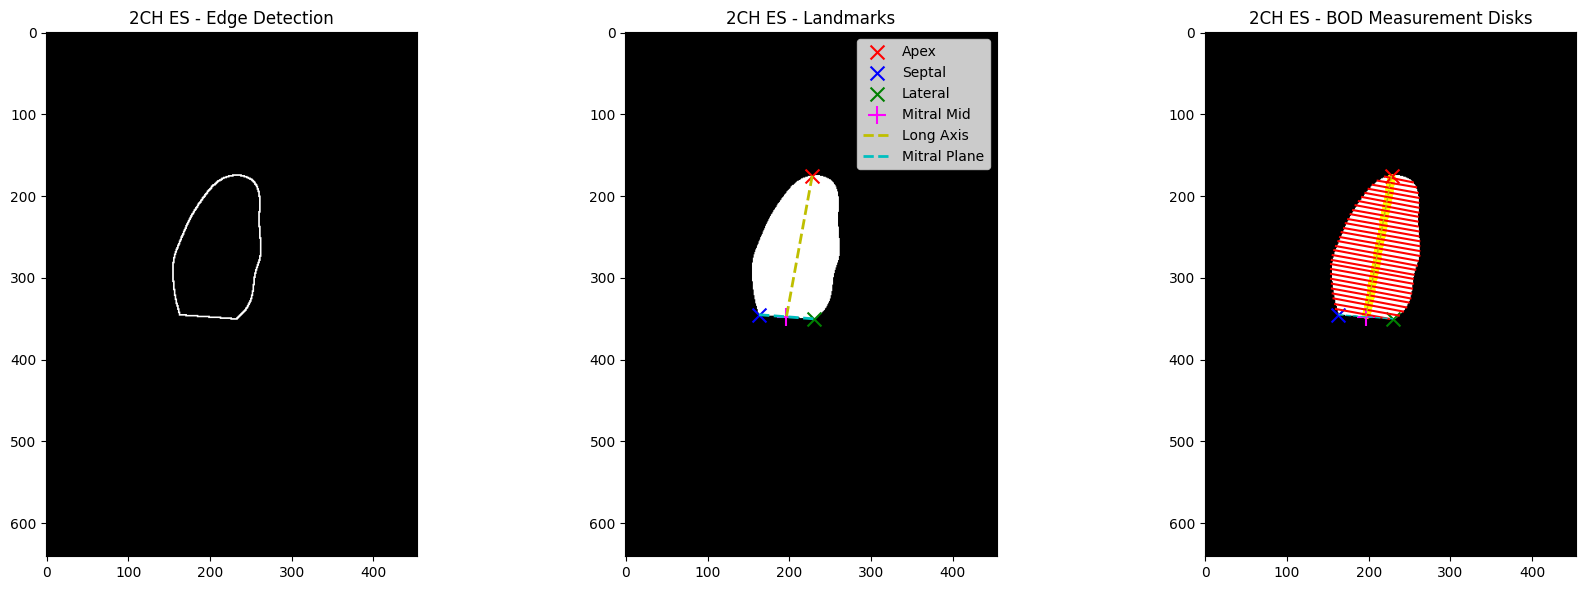


Processing 4CH ED...
View type: 2CH
Apex: (223, 154)
Septal: (238, 396)
Lateral: (126, 364)
Mitral Mid: (182.0, 380.0)


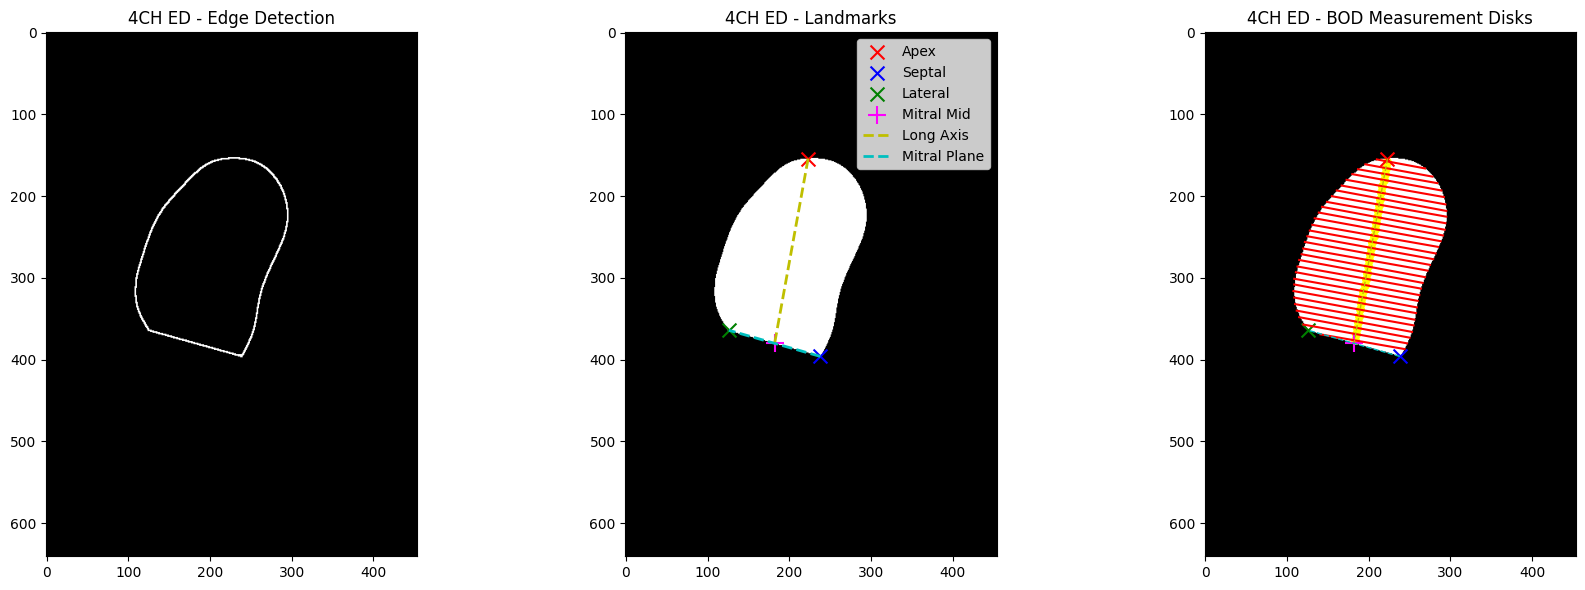


Processing 4CH ES...
View type: 2CH
Apex: (219, 155)
Septal: (245, 364)
Lateral: (145, 343)
Mitral Mid: (195.0, 353.5)


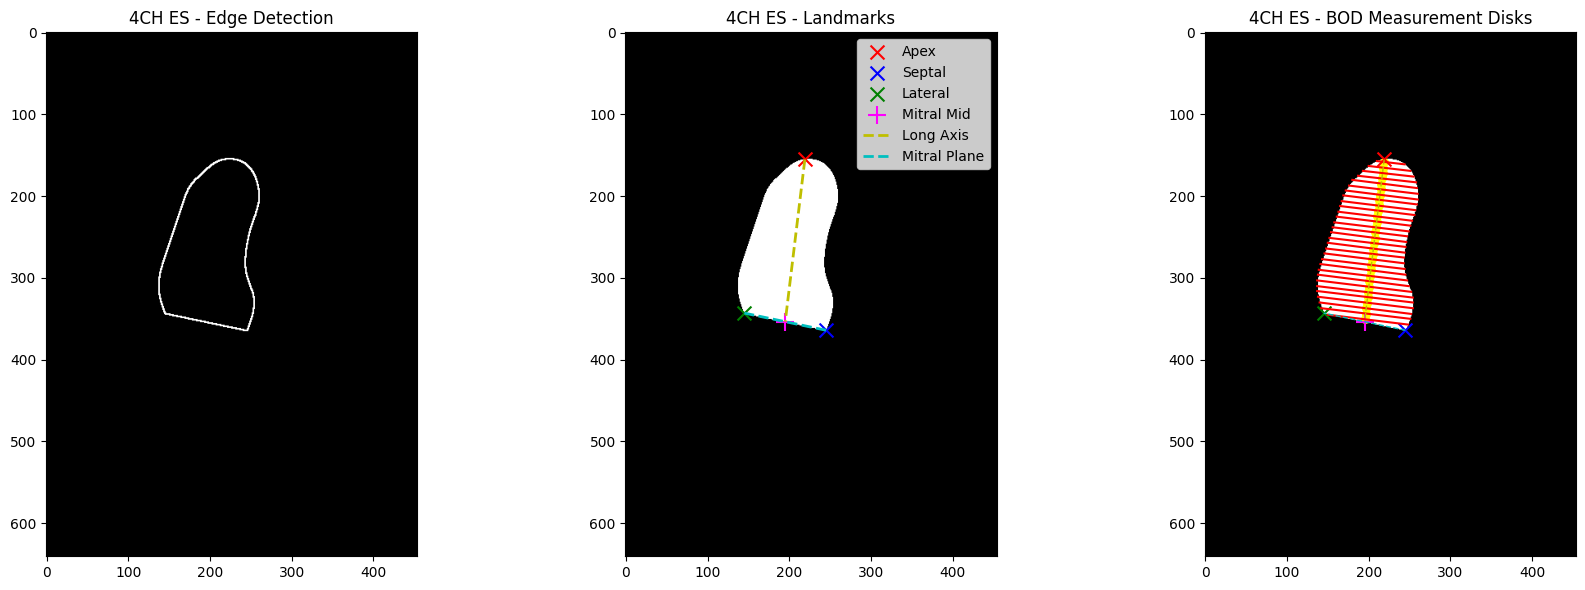


EF Calculation Successful:
EDV: 98210.33 ml
ESV: 35328.64 ml
EF: 64.03%
Using 30 disks and standard 90° angle between views


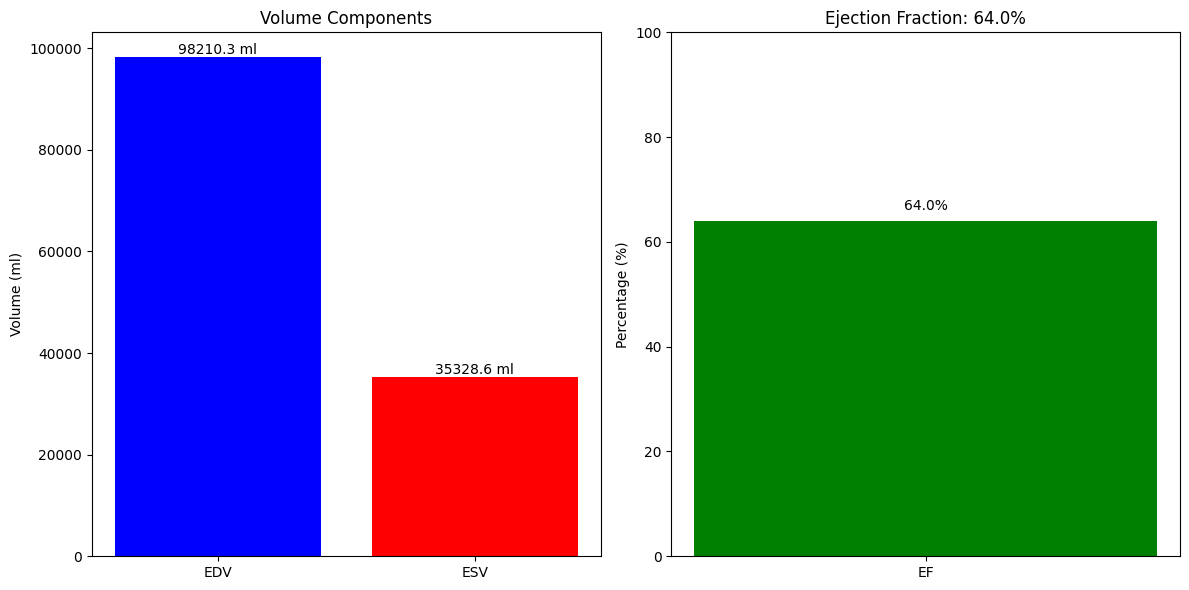

In [7]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import math
import gzip
import shutil
import tempfile
from skimage.filters import sobel
from skimage.feature import canny

def handle_compressed_file(filepath):
    """Handle both .nii.gz and .niigz files"""
    if filepath.endswith('.niigz'):
        with tempfile.NamedTemporaryFile(suffix='.nii.gz', delete=False) as tmp_file:
            with gzip.open(filepath, 'rb') as f_in:
                shutil.copyfileobj(f_in, tmp_file)
            return tmp_file.name
    return filepath

def rotate_image_clockwise(image, angle=90):
    """Rotate image clockwise with better boundary handling"""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def enhanced_edge_detection(seg_binary):
    """Improved edge detection using multiple methods"""
    # Convert to binary
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    
    # Method 1: Canny edge detector with automatic thresholds
    edges_canny = canny(seg_binary/255.0, sigma=1.5)
    
    # Method 2: Sobel edge detection
    edges_sobel = sobel(seg_binary/255.0) > 0.1
    
    # Method 3: Morphological gradient
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    gradient = cv2.morphologyEx(seg_binary, cv2.MORPH_GRADIENT, kernel)
    
    # Combine methods
    combined_edges = (edges_canny | edges_sobel) | (gradient > 0)
    
    # Clean up edges
    combined_edges = combined_edges.astype(np.uint8) * 255
    kernel = np.ones((3,3), np.uint8)
    combined_edges = cv2.morphologyEx(combined_edges, cv2.MORPH_CLOSE, kernel)
    
    return combined_edges

def detect_landmarks(seg_binary, delta_y_fraction=0.15, y_tolerance=20, curvature_threshold=0.2, min_x_separation=0.2):
    """Enhanced landmark detection combining view-specific and flexible logic."""
    # Initialize variables to avoid return issues
    curvature = None
    contour_points = None
    
    try:
        # Convert to binary and find contours
        seg_binary = (seg_binary > 0).astype(np.uint8) * 255
        contours, _ = cv2.findContours(seg_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if not contours:
            raise ValueError("No LV contour found")
        
        # Use the largest contour
        contour = max(contours, key=cv2.contourArea).squeeze()
        contour_points = contour  # Store for return
        x = contour[:, 0].astype(float)
        y = contour[:, 1].astype(float)
        img_width = seg_binary.shape[1]
        
        # Smooth contour
        x_smooth = gaussian_filter1d(x, sigma=5, mode='wrap')
        y_smooth = gaussian_filter1d(y, sigma=5, mode='wrap')
        
        # Compute curvature
        dx = np.gradient(x_smooth)
        dy = np.gradient(y_smooth)
        ddx = np.gradient(dx)
        ddy = np.gradient(dy)
        curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2 + 1e-10)**1.5
        curvature = (curvature - np.min(curvature)) / (np.max(curvature) - np.min(curvature) + 1e-10)
        
        # Find apex: min y
        apex_idx = np.argmin(y)
        apex_point = (int(x[apex_idx]), int(y[apex_idx]))
        
        # Determine view type
        mean_x = np.mean(x)
        view_type = '2CH' if abs(np.median(x) - mean_x) < 0.3*img_width else '4CH'
        
        # Calculate basal threshold
        max_y = max(y)
        min_y = min(y)
        basal_threshold = max_y - delta_y_fraction * (max_y - min_y)
        
        # Find all peaks in curvature
        peaks, _ = find_peaks(curvature, prominence=0.0005)
        
        # Basal peaks
        basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
        
        # If not enough, expand threshold
        if len(basal_peaks) < 2:
            basal_threshold = max_y - 2 * delta_y_fraction * (max_y - min_y)
            basal_peaks = [i for i in peaks if y[i] >= basal_threshold]
        
        # Get basal points (all points in basal region)
        basal_points = [i for i in range(len(y)) if y[i] >= basal_threshold]
        
        if view_type == '4CH':
            # 4CH specific logic: lateral as highest y, septal on opposite side with high curvature
            if basal_points:
                sorted_by_y = sorted(basal_points, key=lambda i: -y[i])
                lateral_idx = sorted_by_y[0]
                mean_x = np.mean(x[basal_points])
                septal_candidates = [i for i in basal_points 
                                     if (x[i] - mean_x) * (x[lateral_idx] - mean_x) < 0
                                     and curvature[i] >= curvature_threshold]
                
                if septal_candidates:
                    septal_idx = max(septal_candidates, key=lambda i: curvature[i])
                else:
                    other_points = [i for i in basal_points if i != lateral_idx]
                    if other_points:
                        septal_idx = max(other_points, key=lambda i: curvature[i])
                    else:
                        septal_idx = lateral_idx
            else:
                raise ValueError("No basal points found for 4CH")
        else:
            # 2CH logic: scoring-based selection to ensure separation and alignment
            if len(basal_peaks) >= 2:
                basal_peaks_sorted = sorted(basal_peaks, key=lambda i: curvature[i], reverse=True)
                septal_idx = basal_peaks_sorted[0]
                septal_side = "right" if x[septal_idx] > mean_x else "left"
                
                lateral_candidates = [i for i in basal_peaks_sorted[1:] 
                                      if ((x[i] > mean_x and septal_side == "left") or 
                                          (x[i] < mean_x and septal_side == "right")) 
                                      and curvature[i] >= curvature_threshold / 2]
                
                if lateral_candidates:
                    scores = []
                    for i in lateral_candidates:
                        curvature_score = curvature[i] * 0.6
                        y_alignment_score = (1 - min(1, abs(y[i] - y[septal_idx]) / y_tolerance)) * 0.4
                        scores.append(curvature_score + y_alignment_score)
                    lateral_idx = lateral_candidates[np.argmax(scores)]
                else:
                    lateral_idx = basal_peaks_sorted[1]
                
                # Ensure minimum x separation
                min_x_dist = min_x_separation * img_width
                if abs(x[septal_idx] - x[lateral_idx]) < min_x_dist:
                    outward_dir = 1 if x[lateral_idx] > mean_x else -1
                    for i in basal_peaks_sorted[2:]:
                        if abs(x[i] - x[septal_idx]) > min_x_dist and \
                           ((x[i] > mean_x and outward_dir > 0) or (x[i] < mean_x and outward_dir < 0)):
                            lateral_idx = i
                            break
                
                # Final check
                if abs(x[septal_idx] - x[lateral_idx]) < min_x_dist:
                    print(f"Warning: Points still close after fallback. Distance: {abs(x[septal_idx] - x[lateral_idx]):.1f} px")
            else:
                # Fallback for 2CH
                if basal_points:
                    left_idx = basal_points[np.argmin(x[basal_points])]
                    right_idx = basal_points[np.argmax(x[basal_points])]
                    if curvature[left_idx] > curvature[right_idx]:
                        septal_idx = left_idx
                        lateral_idx = right_idx
                    else:
                        septal_idx = right_idx
                        lateral_idx = left_idx
                else:
                    raise ValueError("No basal points found for 2CH")
        
        septal_point = (int(x[septal_idx]), int(y[septal_idx]))
        lateral_point = (int(x[lateral_idx]), int(y[lateral_idx]))
        
        # Mitral mid
        mitral_mid = ((septal_point[0] + lateral_point[0]) / 2, (septal_point[1] + lateral_point[1]) / 2)
        
        print(f"View type: {view_type}")
        print(f"Apex: {apex_point}")
        print(f"Septal: {septal_point}")
        print(f"Lateral: {lateral_point}")
        print(f"Mitral Mid: {mitral_mid}")
        
        return apex_point, septal_point, lateral_point, mitral_mid, curvature, contour_points
        
    except Exception as e:
        print(f"Error in detect_landmarks: {str(e)}")
        # Return default values to prevent unpacking errors
        return (0, 0), (0, 0), (0, 0), (0, 0), curvature, contour_points

def compute_bod_diameters(seg_binary, apex, septal, lateral, mitral_mid, pixel_spacing=(0.1, 0.1), nr_disks=30):
    """Compute BOD diameters with disks perpendicular to the long axis."""
    # Create filled mask
    seg_binary = (seg_binary > 0).astype(np.uint8) * 255
    contours, _ = cv2.findContours(seg_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return 0.0, [], [], None
    
    max_contour = max(contours, key=cv2.contourArea)
    filled_mask = np.zeros_like(seg_binary, dtype=np.uint8)
    cv2.drawContours(filled_mask, [max_contour], -1, 1, thickness=cv2.FILLED)
    
    # Calculate long axis length
    dx_long = apex[0] - mitral_mid[0]
    dy_long = apex[1] - mitral_mid[1]
    L_cm = np.sqrt((dx_long * pixel_spacing[0])**2 + (dy_long * pixel_spacing[1])**2)
    
    if L_cm == 0:
        return L_cm, [], [], None
    
    # Normalize long axis vector
    long_norm = np.sqrt(dx_long**2 + dy_long**2)
    long_dir = np.array([dx_long/long_norm, dy_long/long_norm])
    
    # Calculate perpendicular direction (normal to long axis)
    perp_dir = np.array([-long_dir[1], long_dir[0]])
    
    diameters_cm = []
    disk_info = []
    
    for i in range(nr_disks):
        t = (i + 0.5) / nr_disks
        center_x = mitral_mid[0] + t * dx_long
        center_y = mitral_mid[1] + t * dy_long
        
        # Search for boundary points in both perpendicular directions
        point1 = None
        point2 = None
        max_dist = max(seg_binary.shape) // 2
        
        for direction in [-1, 1]:
            for dist in range(1, max_dist):
                px = int(round(center_x + direction * dist * perp_dir[0]))
                py = int(round(center_y + direction * dist * perp_dir[1]))
                
                if not (0 <= px < seg_binary.shape[1] and 0 <= py < seg_binary.shape[0]):
                    break
                
                if filled_mask[py, px] == 0:  # Found boundary
                    if direction == -1:
                        point1 = (px, py)
                    else:
                        point2 = (px, py)
                    break
        
        if point1 and point2:
            dx_px = point2[0] - point1[0]
            dy_px = point2[1] - point1[1]
            diameter_cm = np.sqrt((dx_px * pixel_spacing[0])**2 + (dy_px * pixel_spacing[1])**2)
            
            diameters_cm.append(diameter_cm)
            disk_info.append({
                'center': (center_x, center_y),
                'point1': point1,
                'point2': point2,
                'diameter_cm': diameter_cm
            })
        else:
            diameters_cm.append(0.0)
            disk_info.append({
                'center': (center_x, center_y),
                'point1': None,
                'point2': None,
                'diameter_cm': 0.0
            })
    
    return L_cm, diameters_cm, disk_info, filled_mask

def compute_biplane_volume(L4_cm, L2_cm, diameters4_cm, diameters2_cm, nr_disks=30):
    """Compute biplane Simpson's volume with standard 90° angle."""
    L_avg_cm = (L4_cm + L2_cm) / 2
    h_cm = L_avg_cm / nr_disks
    
    total_volume = 0.0
    disk_volumes = []
    
    for i in range(nr_disks):
        a_i = diameters4_cm[i] if i < len(diameters4_cm) else 0
        b_i = diameters2_cm[i] if i < len(diameters2_cm) else 0
        
        if a_i < 0.1 or b_i < 0.1:
            disk_volume = 0
        else:
            # Standard formula for orthogonal views (90° angle)
            disk_volume = (np.pi / 4) * a_i * b_i * h_cm
        
        total_volume += disk_volume
        disk_volumes.append(disk_volume)
    
    return total_volume, disk_volumes

def visualize_processing(seg_data, landmarks, disk_info, view, phase, pixel_spacing):
    """Enhanced visualization with BOD method results"""
    apex, septal, lateral, mitral_mid = landmarks
    
    plt.figure(figsize=(18, 6))
    
    edges = enhanced_edge_detection(seg_data)
    plt.subplot(131)
    plt.imshow(edges, cmap='gray')
    plt.title(f'{view} {phase} - Edge Detection')
    
    plt.subplot(132)
    plt.imshow(seg_data, cmap='gray')
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x', label='Apex')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x', label='Septal')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x', label='Lateral')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+', label='Mitral Mid')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=2, label='Long Axis')
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=2, label='Mitral Plane')
    plt.legend(loc='upper right')
    plt.title(f'{view} {phase} - Landmarks')
    
    plt.subplot(133)
    plt.imshow(seg_data, cmap='gray')
    
    # Plot disks perpendicular to long axis
    for disk in disk_info:
        if disk['point1'] and disk['point2']:
            plt.plot([disk['point1'][0], disk['point2'][0]], 
                     [disk['point1'][1], disk['point2'][1]], 
                     'r-', linewidth=1.5)
            plt.scatter(disk['center'][0], disk['center'][1], c='yellow', s=30)
    
    # Plot landmarks and axes
    plt.scatter(apex[0], apex[1], c='red', s=100, marker='x')
    plt.scatter(septal[0], septal[1], c='blue', s=100, marker='x')
    plt.scatter(lateral[0], lateral[1], c='green', s=100, marker='x')
    plt.scatter(mitral_mid[0], mitral_mid[1], c='magenta', s=150, marker='+')
    plt.plot([apex[0], mitral_mid[0]], [apex[1], mitral_mid[1]], 'y--', linewidth=1)
    plt.plot([septal[0], lateral[0]], [septal[1], lateral[1]], 'c--', linewidth=1)
    
    plt.title(f'{view} {phase} - BOD Measurement Disks')
    
    plt.tight_layout()
    plt.show()

def process_patient(patient_dir, visualize=False):
    """Main processing function with BOD method"""
    patient_id = os.path.basename(patient_dir)
    print(f"\nProcessing Patient: {patient_id}")
    
    volumes = {'2CH': {'ED': None, 'ES': None}, '4CH': {'ED': None, 'ES': None}}
    all_landmarks = {}
    all_disk_info = {}
    
    try:
        for file in os.listdir(patient_dir):
            if not (file.endswith('_gt.niigz') or file.endswith('_gt.nii.gz')):
                continue
                
            view = None
            phase = None
            
            if '4ch' in file.lower():
                view = '4CH'
            elif '2ch' in file.lower():
                view = '2CH'
                
            if 'ed' in file.lower():
                phase = 'ED'
            elif 'es' in file.lower():
                phase = 'ES'
                
            if not view or not phase:
                continue
                
            print(f"\nProcessing {view} {phase}...")
            
            filepath = os.path.join(patient_dir, file)
            temp_file = None
            
            try:
                if file.endswith('.niigz'):
                    temp_file = handle_compressed_file(filepath)
                    gt_img = nib.load(temp_file)
                else:
                    gt_img = nib.load(filepath)
                    
                gt_data = gt_img.get_fdata()
                pixel_spacing = gt_img.header.get_zooms()[:2]
                
                mask = np.zeros_like(gt_data, dtype=np.uint8)
                mask[gt_data == 1] = 255
                rotated_mask = rotate_image_clockwise(mask)
                
                try:
                    landmarks = detect_landmarks(rotated_mask)
                    apex, septal, lateral, mitral_mid, curvature, contour = landmarks
                    
                    # Check if landmarks are valid (not all zeros)
                    if apex == (0, 0) and septal == (0, 0) and lateral == (0, 0):
                        raise Exception("Landmark detection failed completely")
                    
                    # Use BOD method with 30 disks
                    L_cm, diameters_cm, disk_info, filled_mask = compute_bod_diameters(
                        rotated_mask, apex, septal, lateral, mitral_mid, pixel_spacing, nr_disks=30
                    )
                    
                    volumes[view][phase] = {
                        'L_cm': L_cm,
                        'diameters_cm': diameters_cm,
                        'status': 'success'
                    }
                    
                    all_landmarks[(view, phase)] = (apex, septal, lateral, mitral_mid)
                    all_disk_info[(view, phase)] = disk_info
                    
                    if visualize:
                        visualize_processing(rotated_mask, (apex, septal, lateral, mitral_mid), 
                                             disk_info, view, phase, pixel_spacing)
                        
                except Exception as landmark_error:
                    print(f"Landmark detection failed for {view} {phase}: {str(landmark_error)}")
                    volumes[view][phase] = {
                        'status': f'landmark_error: {str(landmark_error)}'
                    }
                    
            except Exception as file_error:
                print(f"Error processing file {file}: {str(file_error)}")
                if view and phase:
                    volumes[view][phase] = {
                        'status': f'file_error: {str(file_error)}'
                    }
                    
            finally:
                if temp_file and os.path.exists(temp_file):
                    os.unlink(temp_file)
    
    except Exception as patient_error:
        print(f"Error processing patient {patient_id}: {str(patient_error)}")
        return None, None, None
    
    missing = []
    for view in ['2CH', '4CH']:
        for phase in ['ED', 'ES']:
            if not volumes[view][phase] or volumes[view][phase].get('status') != 'success':
                missing.append(f"{view} {phase}")
    
    if missing:
        print(f"\nIncomplete data for EF calculation. Missing: {', '.join(missing)}")
    else:
        try:
            # Calculate volumes with standard 90° angle and 30 disks
            ed_vol, ed_disk_volumes = compute_biplane_volume(
                volumes['4CH']['ED']['L_cm'],
                volumes['2CH']['ED']['L_cm'],
                volumes['4CH']['ED']['diameters_cm'],
                volumes['2CH']['ED']['diameters_cm'],
                nr_disks=30
            )
            
            es_vol, es_disk_volumes = compute_biplane_volume(
                volumes['4CH']['ES']['L_cm'],
                volumes['2CH']['ES']['L_cm'],
                volumes['4CH']['ES']['diameters_cm'],
                volumes['2CH']['ES']['diameters_cm'],
                nr_disks=30
            )
            
            ef = ((ed_vol - es_vol) / ed_vol) * 100 if ed_vol > 0 else 0
            
            volumes['EDV'] = ed_vol
            volumes['ESV'] = es_vol
            volumes['EF'] = ef
            volumes['ED_disk_volumes'] = ed_disk_volumes
            volumes['ES_disk_volumes'] = es_disk_volumes
            
            print(f"\nEF Calculation Successful:")
            print(f"EDV: {ed_vol:.2f} ml")
            print(f"ESV: {es_vol:.2f} ml")
            print(f"EF: {ef:.2f}%")
            print(f"Using 30 disks and standard 90° angle between views")
            
            if visualize:
                plt.figure(figsize=(12, 6))
                
                # Volume components
                plt.subplot(121)
                volumes_data = [ed_vol, es_vol]
                labels = ['EDV', 'ESV']
                colors = ['blue', 'red']
                bars = plt.bar(labels, volumes_data, color=colors)
                plt.ylabel('Volume (ml)')
                plt.title('Volume Components')
                for bar in bars:
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height,
                             f'{height:.1f} ml', ha='center', va='bottom')
                
                # Ejection fraction
                plt.subplot(122)
                plt.bar(['EF'], [ef], color='green' if ef > 50 else 'orange' if ef > 30 else 'red')
                plt.ylim(0, 100)
                plt.ylabel('Percentage (%)')
                plt.title(f'Ejection Fraction: {ef:.1f}%')
                plt.text(0, ef + 2, f'{ef:.1f}%', ha='center')
                
                plt.tight_layout()
                plt.show()
                
        except Exception as vol_error:
            print(f"Volume calculation error: {str(vol_error)}")
    
    return volumes, all_landmarks, all_disk_info

if __name__ == "__main__":
    base_dir = r"E:\echo heart\Resources"
    patient_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    if not patient_dirs:
        print("No patient directories found")
    else:
        print("Available patients:")
        for i, patient in enumerate(patient_dirs):
            print(f"{i+1}. {patient}")
        
        choice = input("Enter patient number to process (or 'all' for all patients): ")
        
        if choice.lower() == 'all':
            for patient_dir in patient_dirs:
                full_path = os.path.join(base_dir, patient_dir)
                process_patient(full_path, visualize=True)
        elif choice.isdigit():
            idx = int(choice) - 1
            if 0 <= idx < len(patient_dirs):
                full_path = os.path.join(base_dir, patient_dirs[idx])
                process_patient(full_path, visualize=True)
            else:
                print("Invalid patient number")
        else:
            print("Invalid input")

In [5]:
#Disk Orientation: Changed to be perpendicular to the long axis rather than following the mitral plane

#Angle Correction: Uses standard 90° angle between views in volume calculation

#Removed Dead Space: Eliminated the non-standard dead space calculation

#Standard Formula: Uses the standard Simpson's rule formula for orthogonal views